# 🍯 Hexagonal heatmap

In [528]:
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt


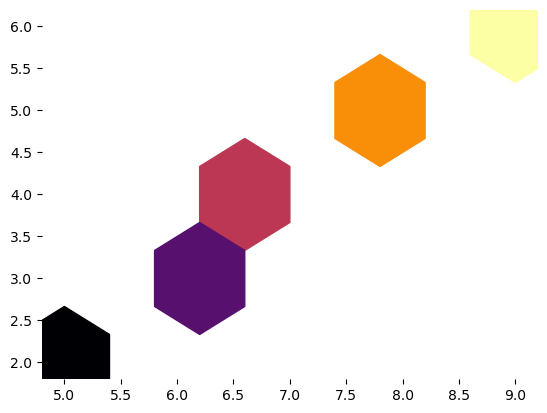

In [529]:
plt.hexbin(
    x = np.arange(5,10)       
    , y = np.arange(2,7)       
    , C=np.arange(2,7)       
    , gridsize = 5       
    , cmap='inferno'
)

sns.despine(bottom=True, left=True)

In [530]:
np.arange(5,10)

array([5, 6, 7, 8, 9])

## Application to `space_seg`

In [531]:
from space_seg.space_seg_classes import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [534]:
gen_fams_dict = {
    "PA": {
        "k": {
            "generator_path": GEN_PATH+"k.gen",
            "number_generated":N_GRAPHS
        }
    },
    "ER": {
        "c1": {
            "generator_path": GEN_PATH+"c1.gen",
            "number_generated":N_GRAPHS
        },
    },
    "ID": {
        "id": {
            "generator_path": GEN_PATH+"id.gen",
            "number_generated":N_GRAPHS
        }
    },
    "d": {
        "d": {
            "generator_path": GEN_PATH+"d.gen",
            "number_generated":N_GRAPHS
        }
    },
}
v_values = [
    #50,
    500,
    #5000,
]

ve_values = [(v, e) for v in v_values for e in [numbers_of_edges(v)[0]]#numbers_of_edges(v)
             if coherent_max_edges(nodes=v, edges=e) #and e<100000
            ]

ve_values = [(100,552)]

In [609]:
%%capture
netgen = SynNetsGenerator(
    generator_dict=gen_fams_dict,
    ve_pairs_list=ve_values,
    compute_files=False, # SET To ` True ` to generate the network files
    do_overwrite = False,
)

#netgen.init_files()

embmeth = load_embedder(
    "DL_module/saved/best_models/GraphMAE_GCNversion_o64/"
    #"DL_module/saved/best_models/trad_degs/"
)

netemb = netgen.make_embedder(
    **{
        #"embedding_method": lambda net: emb_degs(net, **{"bins":bins, "range":(0,max_val)}),
        "embedding_method": lambda net: embed_deep(net, embedder_method=embmeth),
        "reducer": TSNE()#PCA(n_components=2)
    }
)

In [610]:
netana = netemb.make_analyzer()

In [611]:
np.unique(netana.ve_dicts[list(netana.ve_dicts.keys())[0]]["labels"])

array(['ER', 'ID', 'PA', 'd'], dtype='<U2')

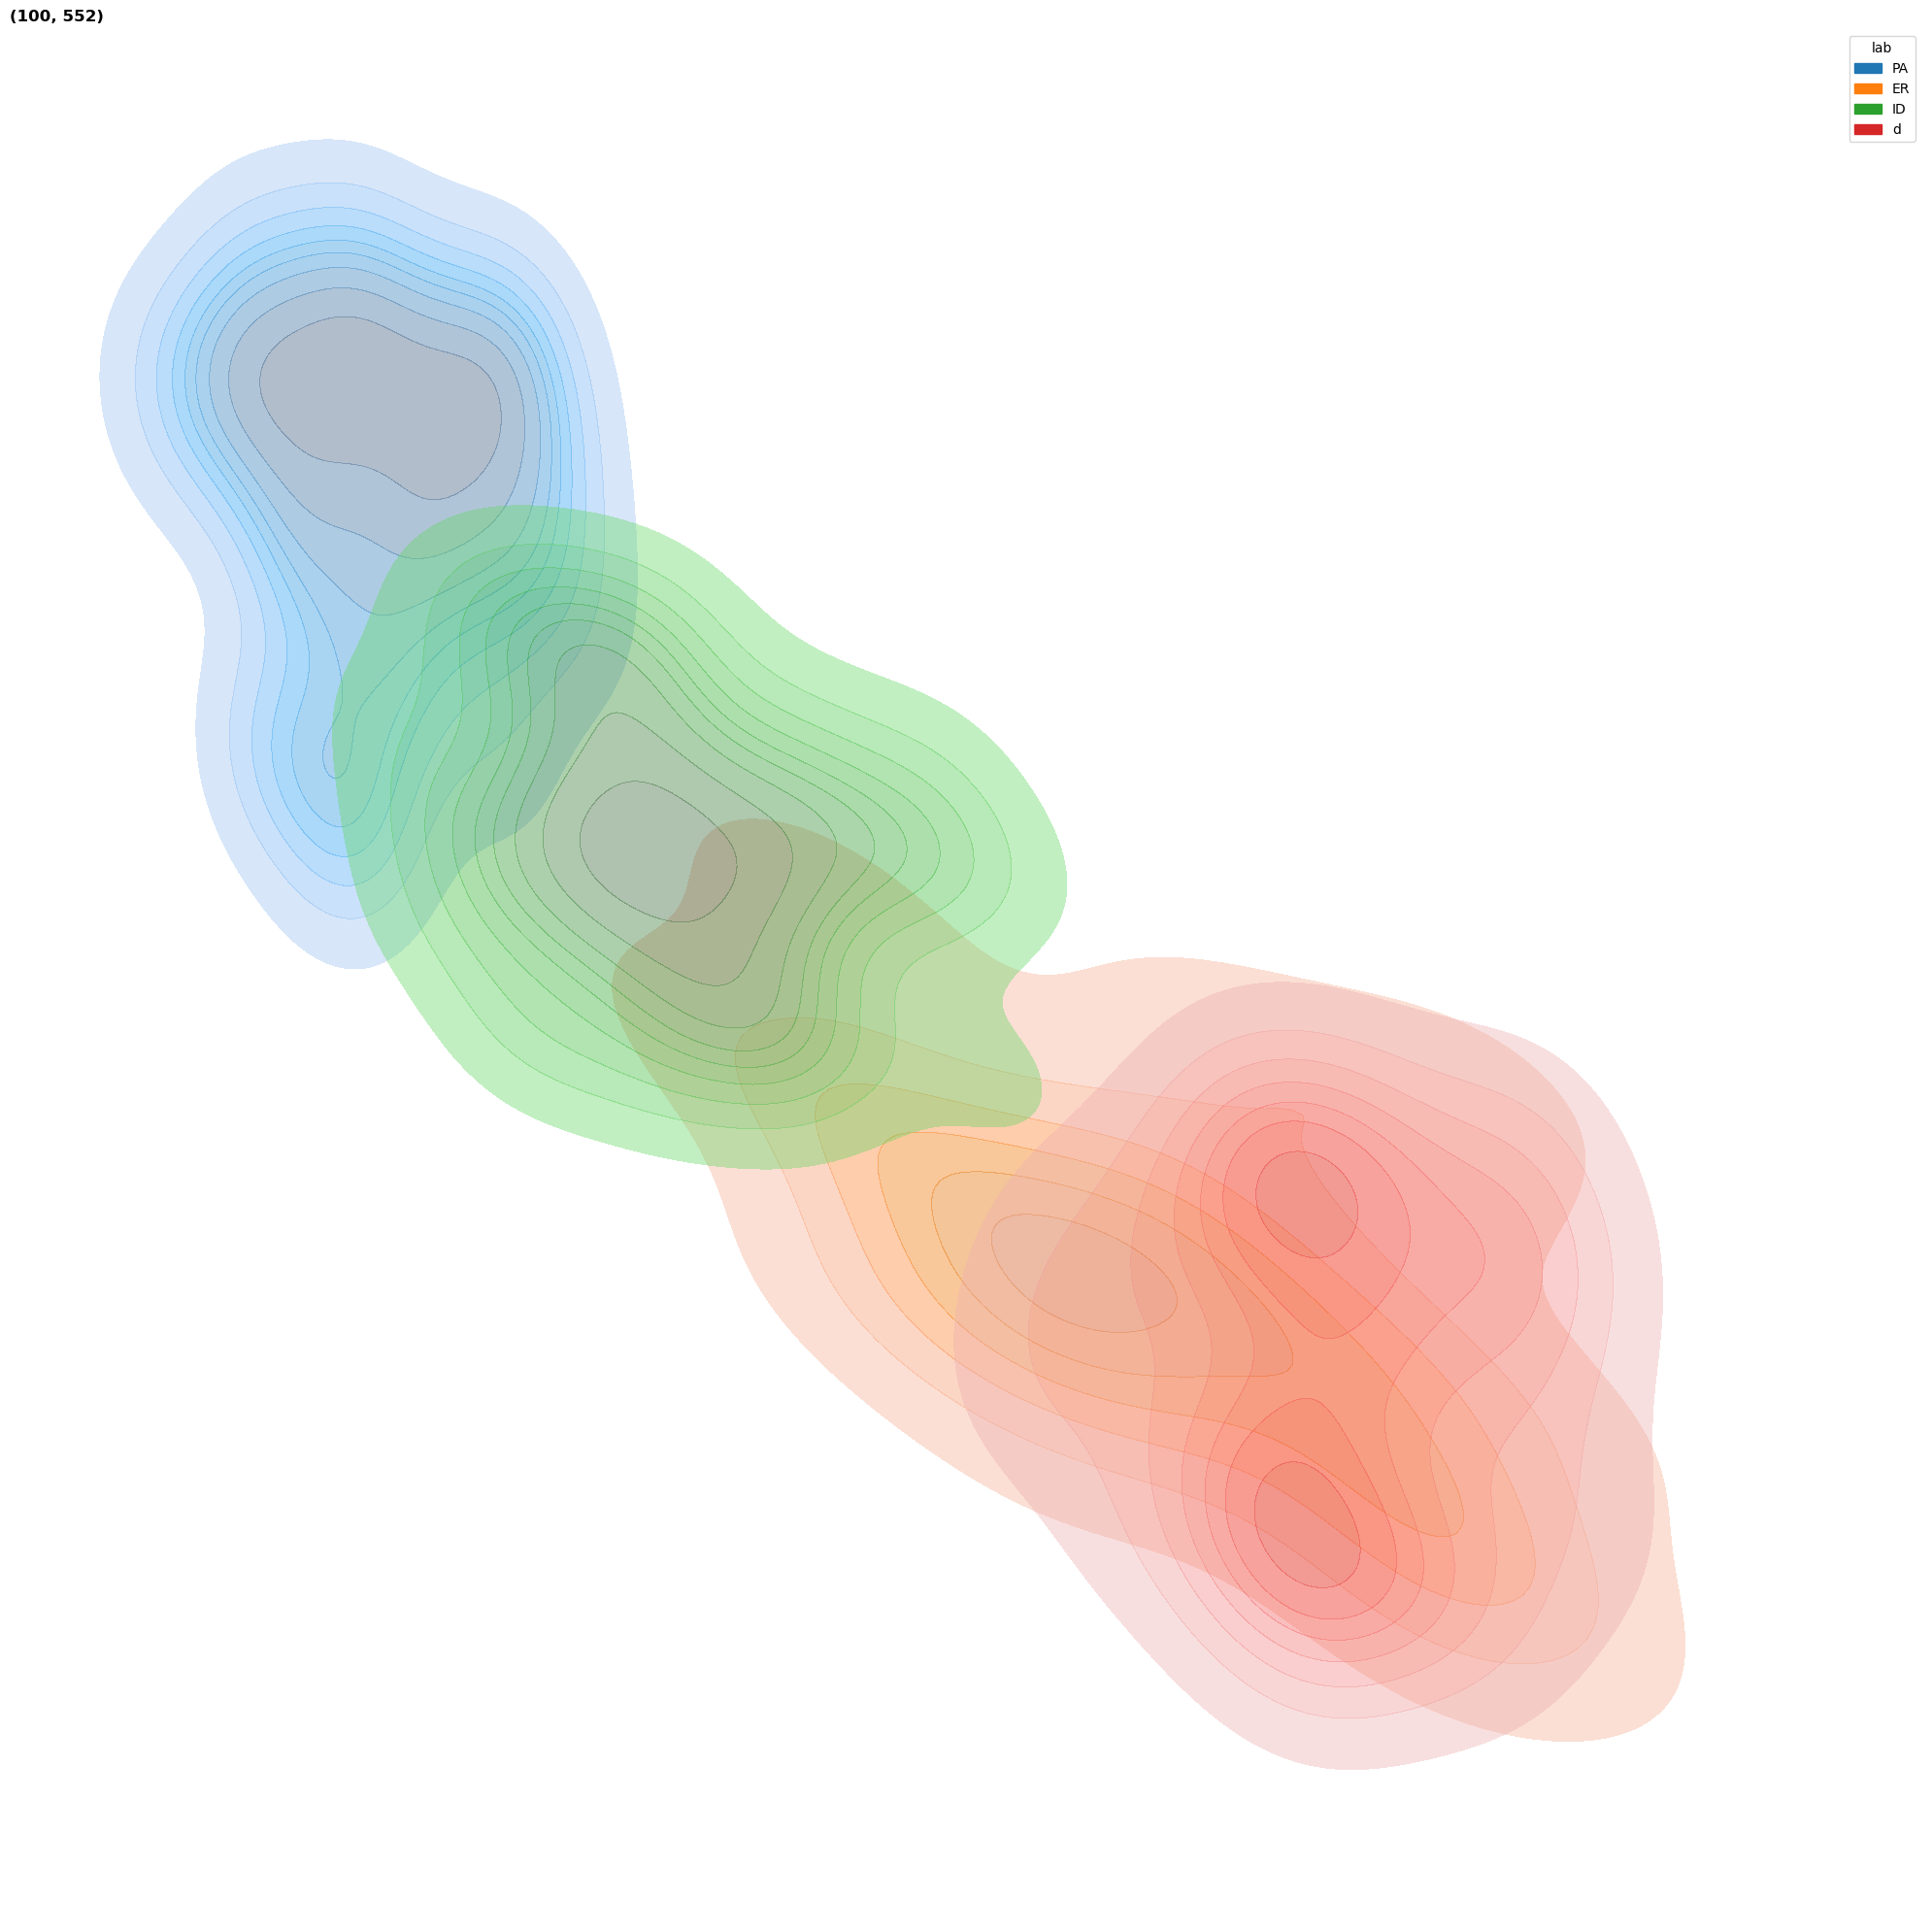

In [612]:
fig = netana.visualise(visualise_ve=visualise_kde, dark_mode=False, return_fig = True)

In [613]:
def get_gmms(list_embs):
    gmms = []
    for embs in list_embs:
        gmm = mixture.GaussianMixture(n_components=1#n_comps
                                      , covariance_type="full"
                                     )
        gmm.fit(embs)
        
        gmms += [gmm]
        
    return gmms

In [614]:
embs = np.array([arg['emb'] for arg in netemb.generated_args])

xs = np.array([e[0] for e in embs])
ys = np.array([e[1] for e in embs])

fams = np.array([arg['family'] for arg in netemb.generated_args])

unique_fams = np.unique(fams)

In [615]:
list_embs = [[emb for emb, fam in zip(embs, fams) if fam == curr_family]
             for curr_family in unique_fams
            ]

gmms = get_gmms(list_embs)

In [616]:
bins_size = 1
nb_bins= 500

x_bins, y_bins, fams_bins = [], [], []

for x in np.linspace(np.min(xs), np.max(xs), nb_bins):#int((np.max(xs)-np.min(xs))/bins_size)):
    for y in np.linspace(np.min(ys), np.max(ys), nb_bins):#int((np.max(ys)-np.min(ys))/bins_size)):
        x_bins += [x]
        y_bins += [y]
        fams_bins += [np.argmax([gmm.score([(x,y)]) for gmm in gmms])]

In [617]:
for i, f in enumerate(unique_fams):
    print(i, f)
    
print(np.unique(fams_bins))

0 ER
1 ID
2 PA
3 d
[0 1 2 3]


In [618]:
def most_frequent(List):
    return max(set(List), key = List.count)

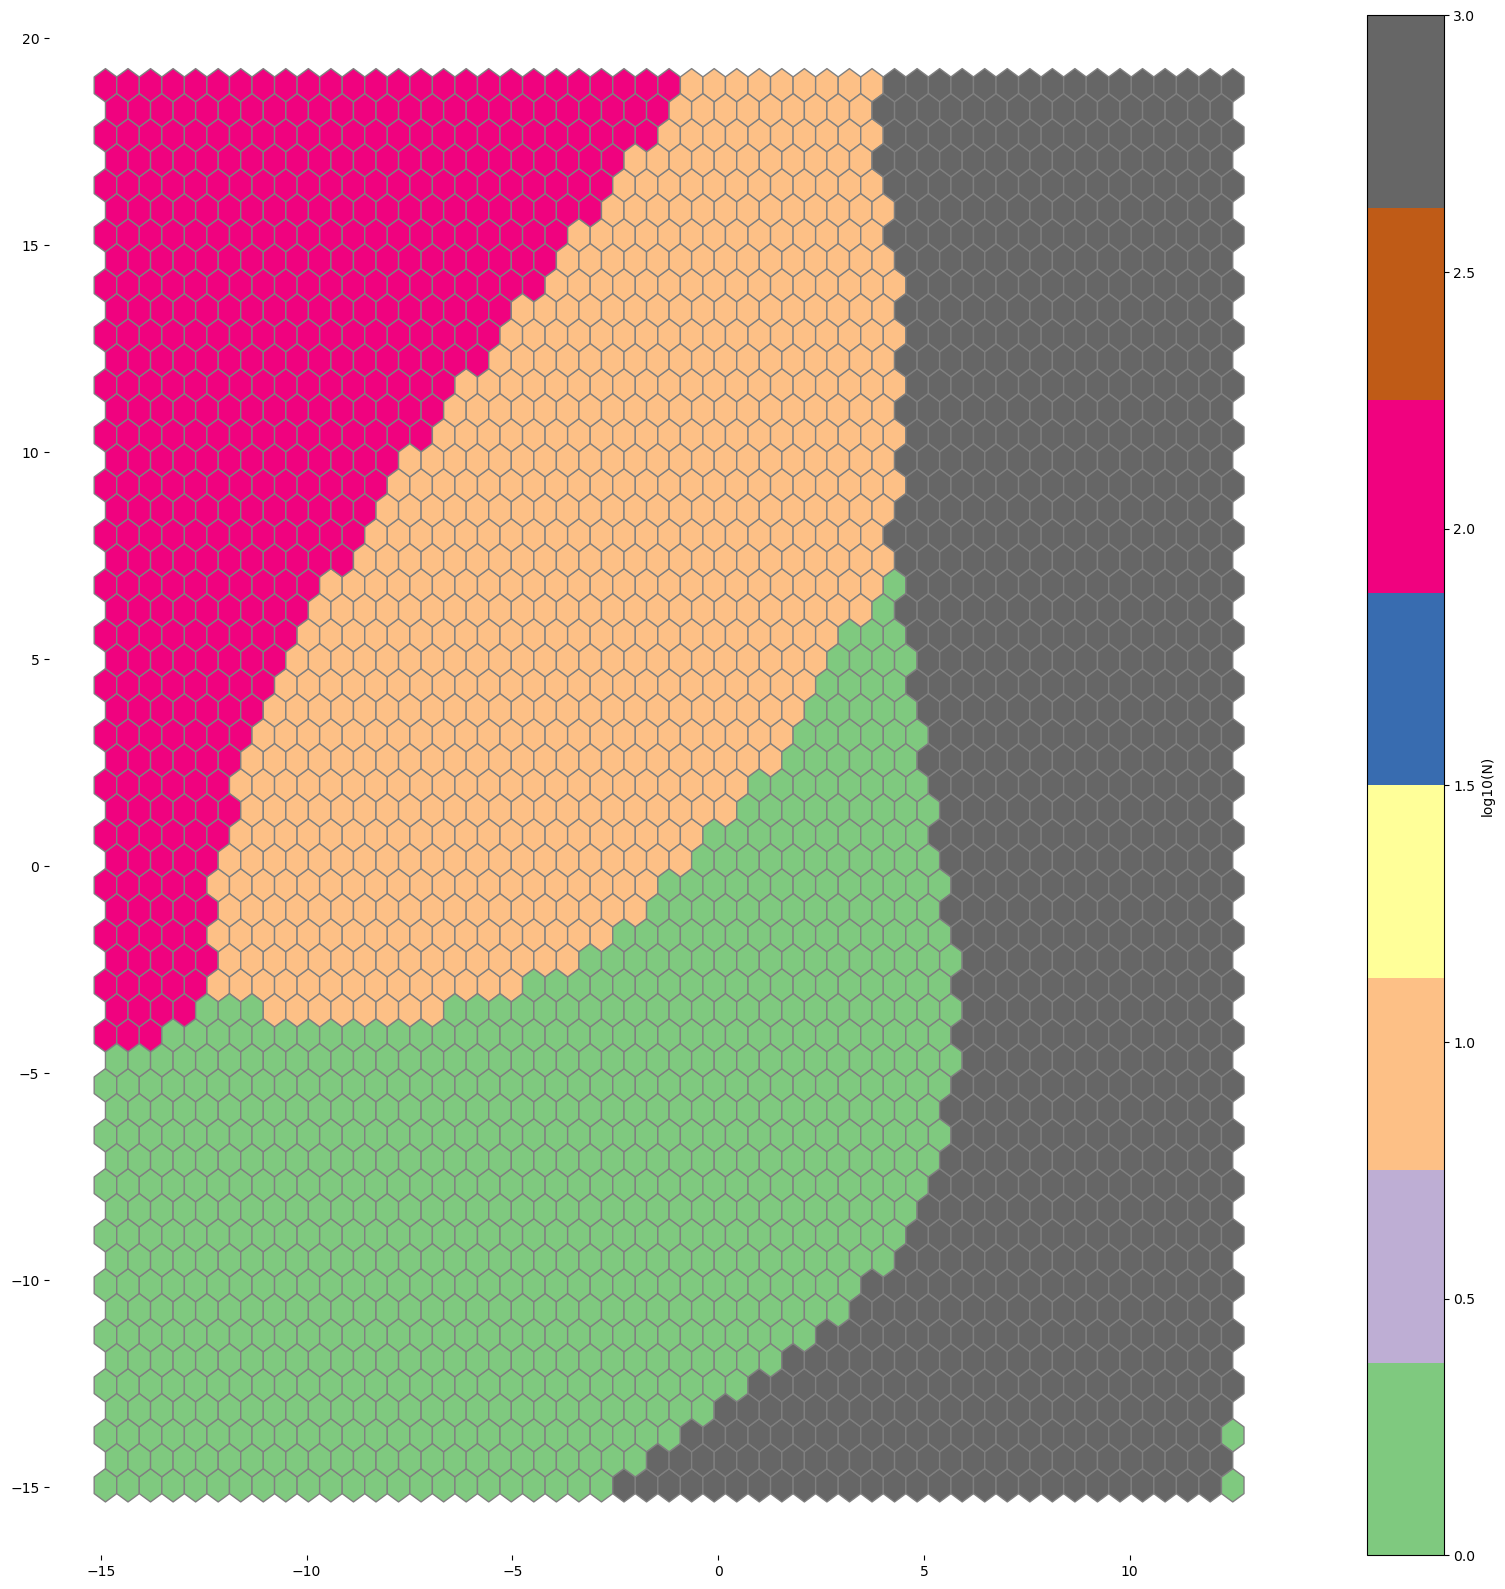

In [620]:
fig, ax = plt.subplots(figsize=(20,20))

hb = ax.hexbin(
    x = x_bins,
    y = y_bins,
    C= fams_bins,
    reduce_C_function = most_frequent,
    #gridsize = 5,
    cmap='Accent',
    gridsize = 50,
    edgecolors='grey',
)


sns.despine(bottom=True, left=True)
cb = fig.colorbar(hb, ax=ax)
cb.set_label('log10(N)')

# ✂️ Voronoi plot

In [623]:
from scipy.spatial import Voronoi, voronoi_plot_2d

In [624]:
vor = Voronoi([gmm.means_[0] for gmm in gmms])

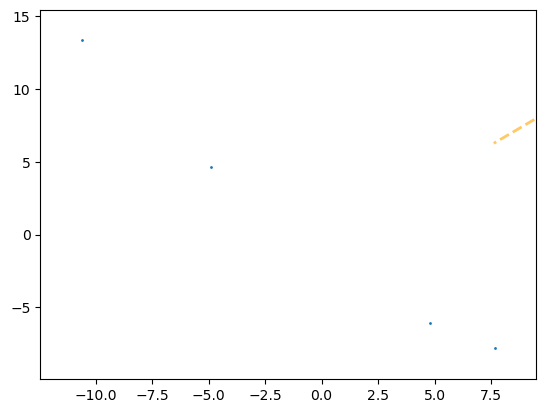

In [625]:
fig = voronoi_plot_2d(vor, show_vertices=True, line_colors='orange',
                      line_width=2, line_alpha=0.6, point_size=2)
plt.show()

In [626]:
def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.

    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.

    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.

    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

--
[[2, 3, 1], [5, 1, 0, 4], [6, 0, 7], [1, 9, 8, 0]]
--
[[48.7623866  46.25563381]
 [23.27285187 20.51043778]
 [ 5.53789076  4.37534256]
 [10.62864079  0.13903455]
 [28.74503663 33.0580642 ]
 [ 5.53789076  4.37534256]
 [28.74503663 33.0580642 ]
 [66.88989995 61.94841569]
 [66.88989995 61.94841569]
 [10.62864079  0.13903455]]


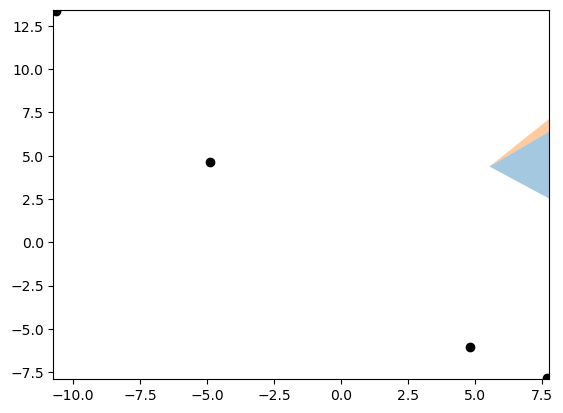

In [627]:
# compute Voronoi tesselation
points = np.array([gmm.means_[0] for gmm in gmms])
vor = Voronoi(points)

# plot
regions, vertices = voronoi_finite_polygons_2d(vor)
print("--")
print(regions)
print("--")
print(vertices)

# colorize
for region in regions:
    polygon = vertices[region]
    plt.fill(*zip(*polygon), alpha=0.4)

plt.plot(points[:,0], points[:,1], 'ko')
plt.xlim(vor.min_bound[0] - 0.1, vor.max_bound[0] + 0.1)
plt.ylim(vor.min_bound[1] - 0.1, vor.max_bound[1] + 0.1)

plt.show()

# 🧶 All-encompassing embedding — GIF!

In [189]:
from space_seg.space_seg_classes import *

%load_ext autoreload
%autoreload 2

gen_fams_dict = {
    "PA": {
        "k": {
            "generator_path": GEN_PATH+"k.gen",
            "number_generated":N_GRAPHS
        }
    },
    "ER": {
        "c1": {
            "generator_path": GEN_PATH+"c1.gen",
            "number_generated":N_GRAPHS
        },
    },
    "ID": {
        "id": {
            "generator_path": GEN_PATH+"id.gen",
            "number_generated":N_GRAPHS
        }
    },
    "PA'": {
        "k^k": {
            "generator_path": GEN_PATH+"k^k.gen",
            "number_generated":N_GRAPHS
        }
    },
    "d": {
        "d": {
            "generator_path": GEN_PATH+"d.gen",
            "number_generated":N_GRAPHS
        }
    },
    "SC": {
        "SC-a": {
            "generator_path": GEN_PATH+"sc-a2.gen",
            "number_generated":N_GRAPHS
        }
    },
}
v_values = [
    #50,
    100,
    #5000,
]

ve_values = [(v, e) for v in v_values for e in numbers_of_edges(v
                                                                , np.linspace(0.01, .5, 50)
                                                               )
             if coherent_max_edges(nodes=v, edges=e) #and e<100000
            ]

print(ve_values)


netgen = SynNetsGenerator(
    generator_dict=gen_fams_dict,
    ve_pairs_list=ve_values,
    compute_files=False, # SET To ` True ` to generate the network files
    do_overwrite = False,
)

#netgen.init_files()

bins = 51
max_val = 50


embmeth = load_embedder(
    #"DL_module/saved/best_models/GraphMAE_GCNversion/"
    "DL_module/saved/best_models/trad_degs/"
)

netemb = netgen.make_embedder(
    **{
        #"embedding_method": lambda net: emb_degs(net, **{"bins":bins, "range":(0,max_val)}),
        "embedding_method": lambda net: embed_deep(net, embedder_method=embmeth),
        "reducer": TSNE()#PCA(n_components=2)
    }
)

netana = netemb.make_analyzer()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[(100, 50), (100, 99), (100, 148), (100, 198), (100, 248), (100, 297), (100, 346), (100, 396), (100, 446), (100, 495), (100, 544), (100, 594), (100, 644), (100, 693), (100, 743), (100, 792), (100, 842), (100, 891), (100, 940), (100, 990), (100, 1040), (100, 1089), (100, 1138), (100, 1188), (100, 1238), (100, 1287), (100, 1336), (100, 1386), (100, 1436), (100, 1485), (100, 1534), (100, 1584), (100, 1634), (100, 1683), (100, 1733), (100, 1782), (100, 1832), (100, 1881), (100, 1930), (100, 1980), (100, 2030), (100, 2079), (100, 2128), (100, 2178), (100, 2228), (100, 2277), (100, 2326), (100, 2376), (100, 2426), (100, 2475)]


/Users/nmm/miniforge3/envs/env_gdl/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/nmm/miniforge3/envs/env_gdl/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [185]:
# make GIF$
import imageio

/var/folders/fw/thz6qyfn5373yws3ryp_ktfh0000gn/T/ipykernel_68008/3770169973.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(nrows=1,ncols=1, figsize=(10,10))


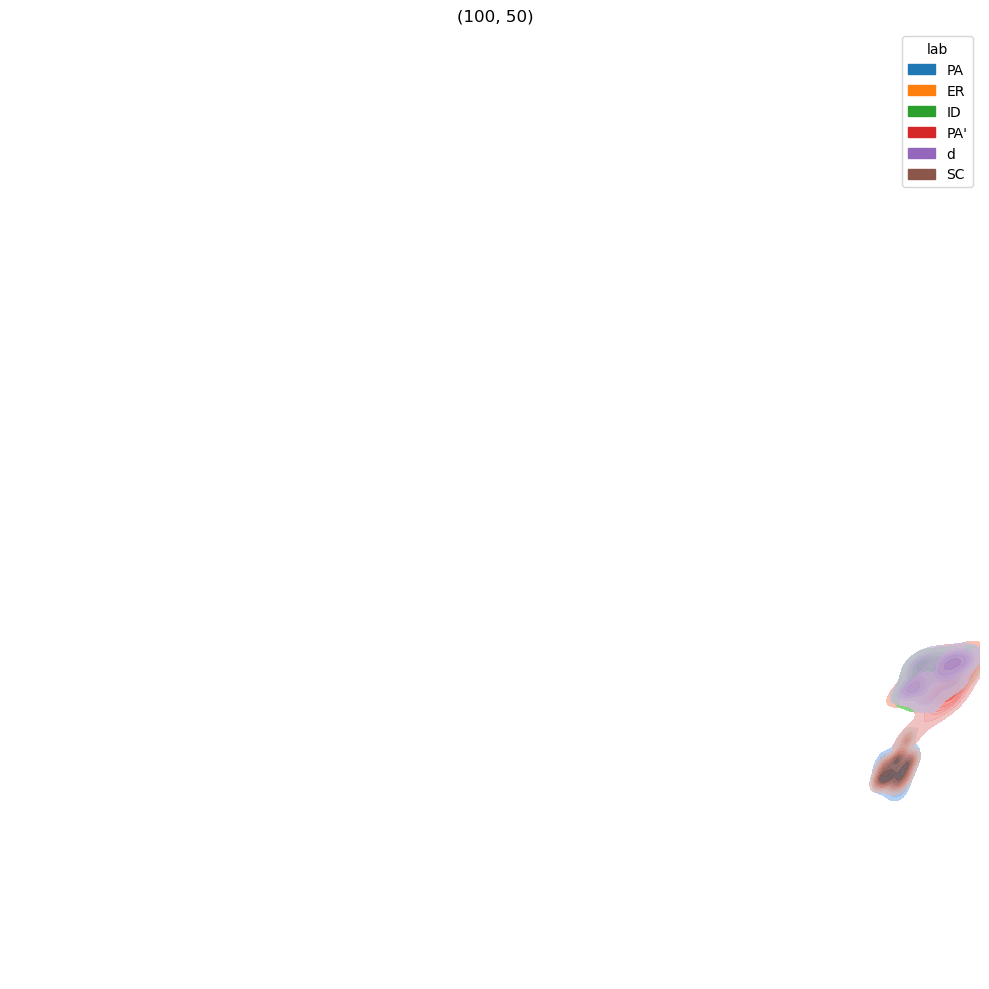

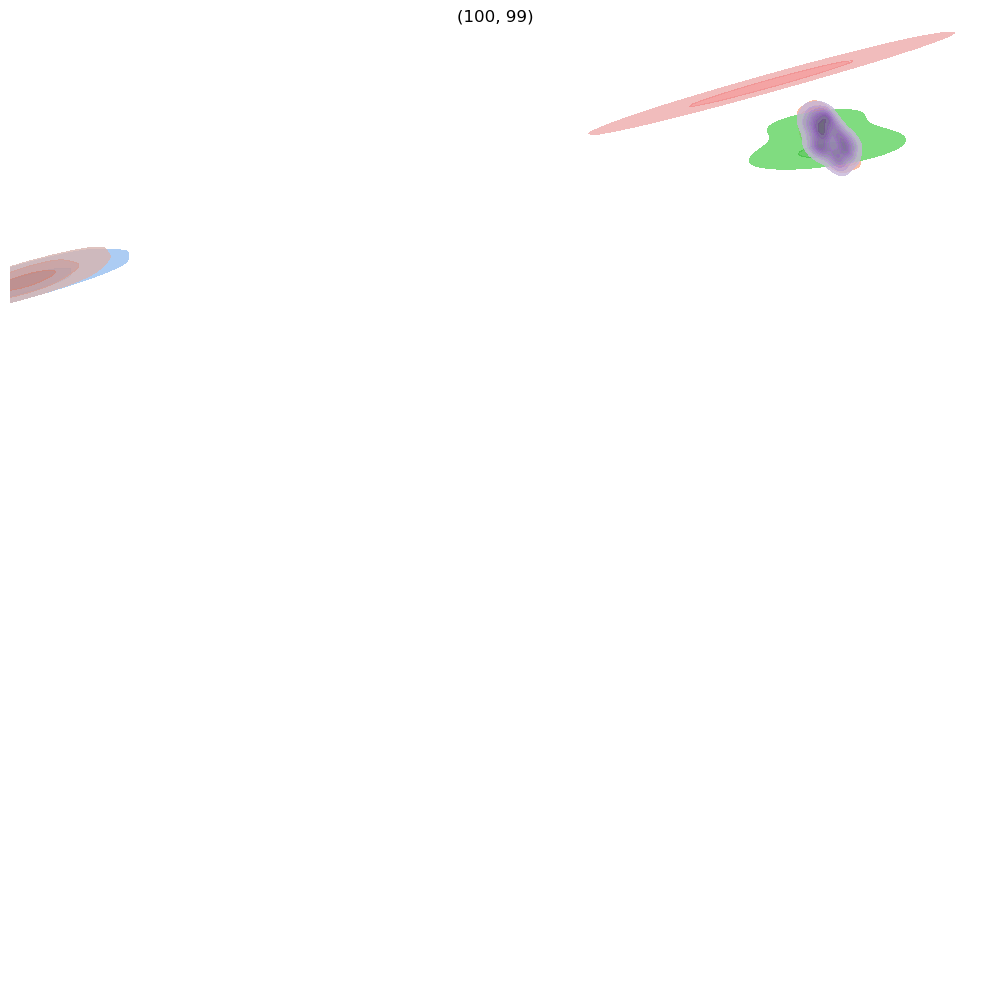

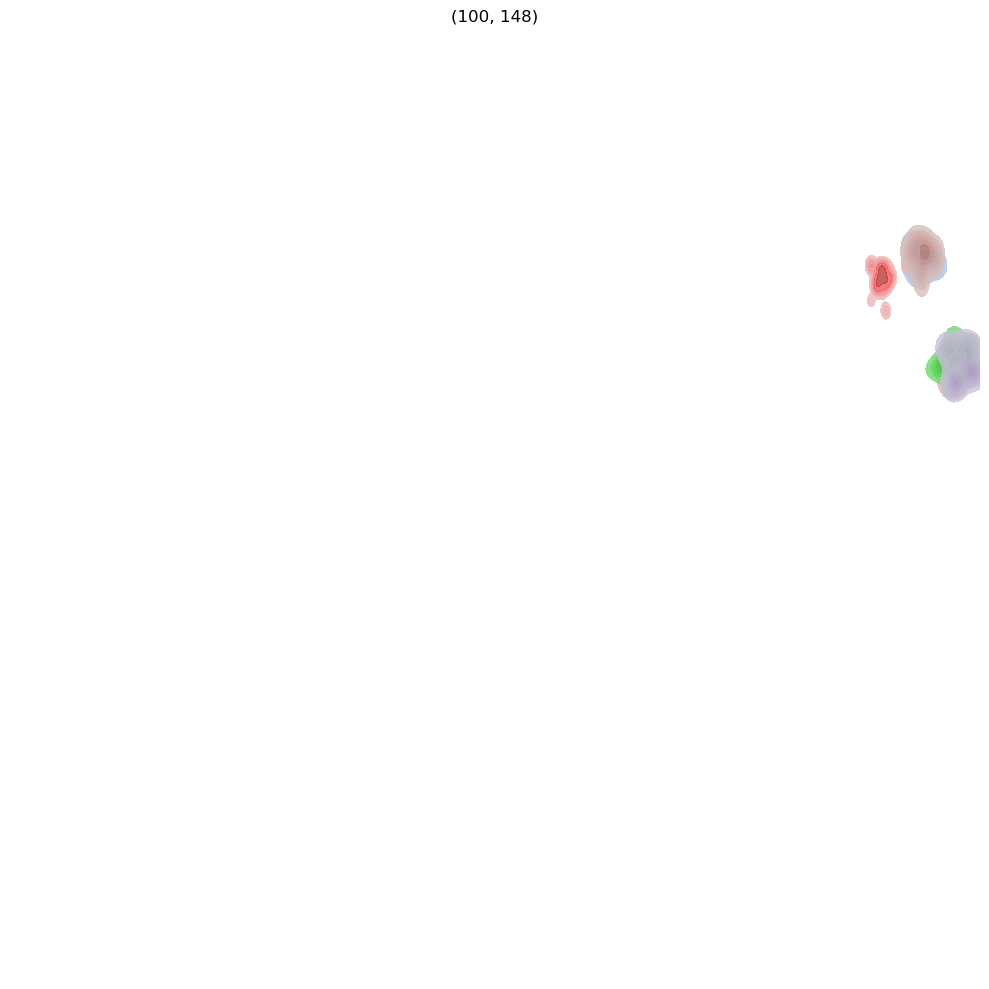

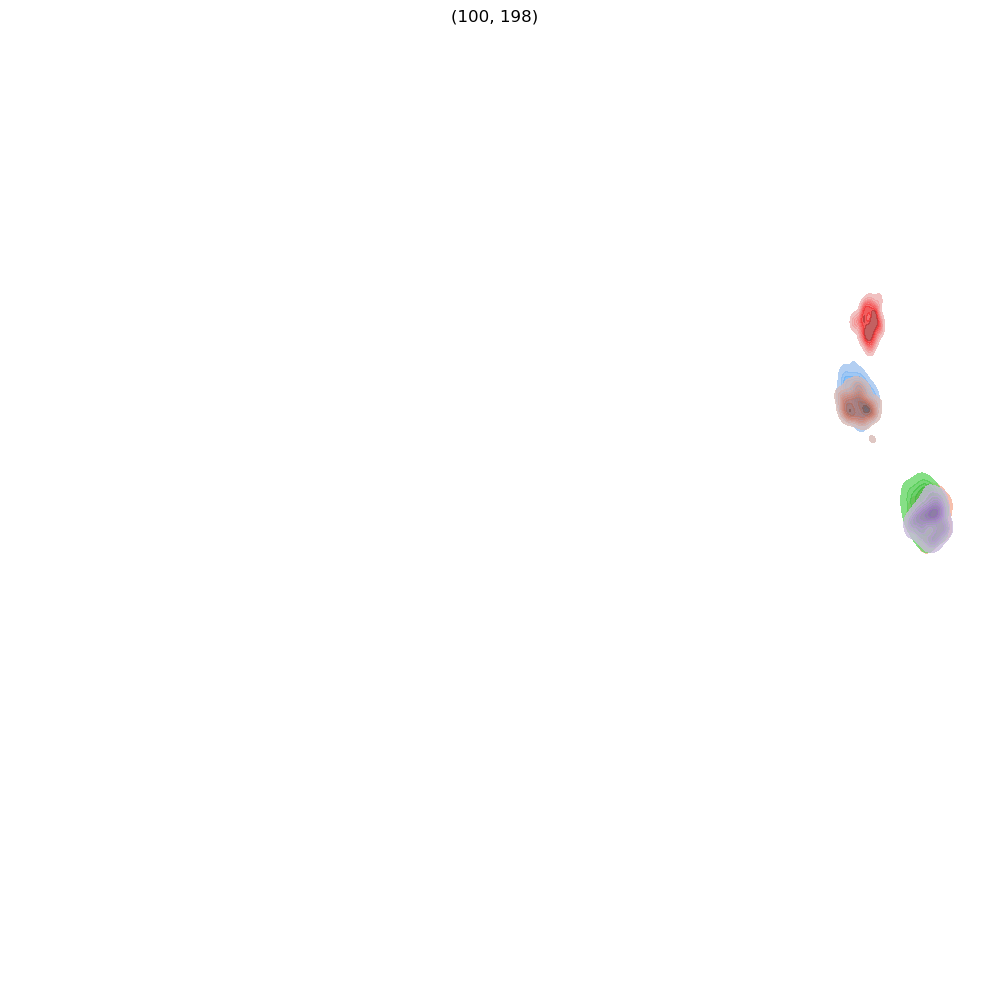

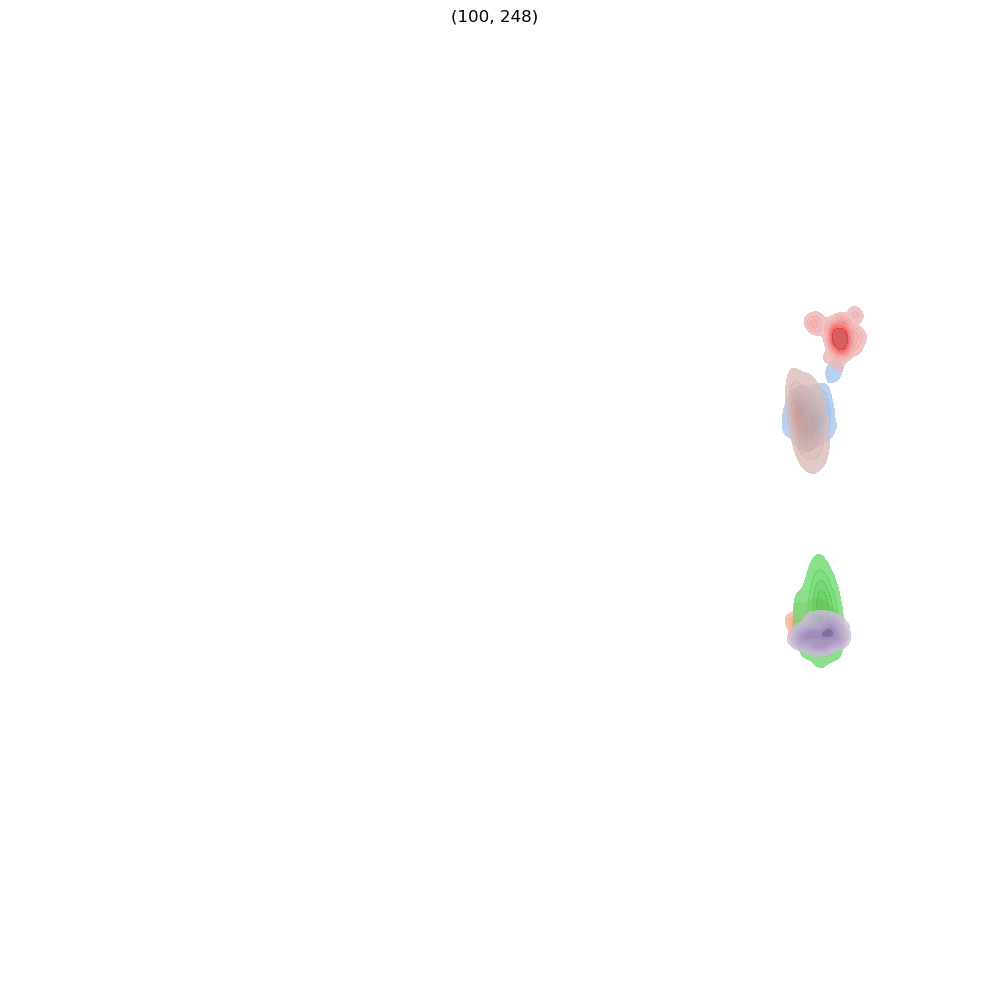

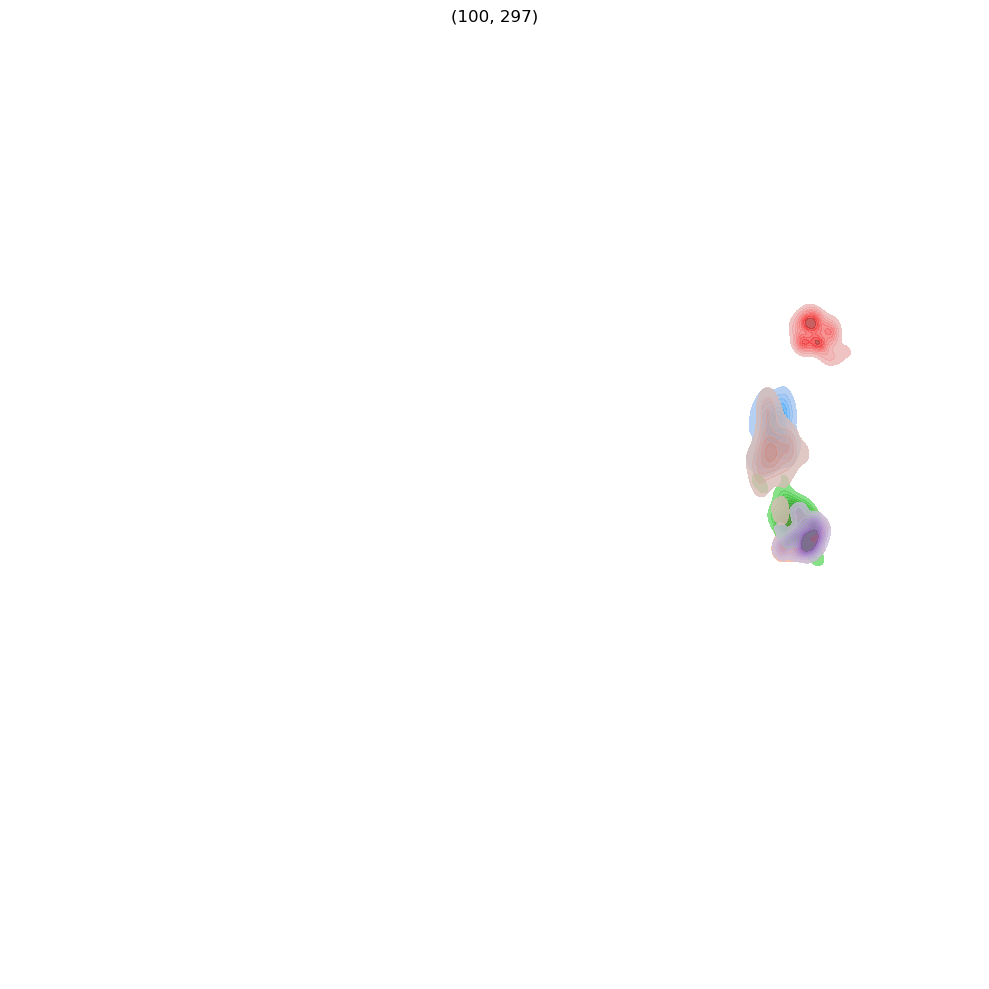

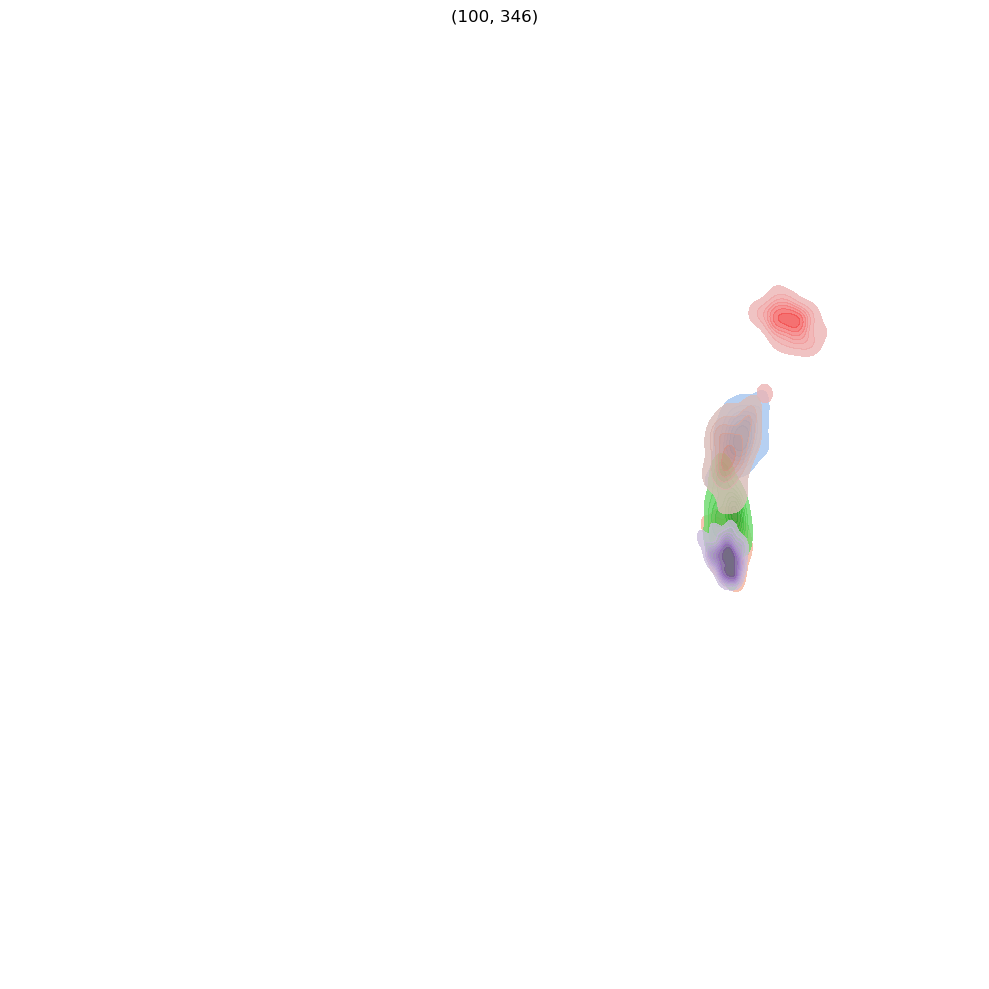

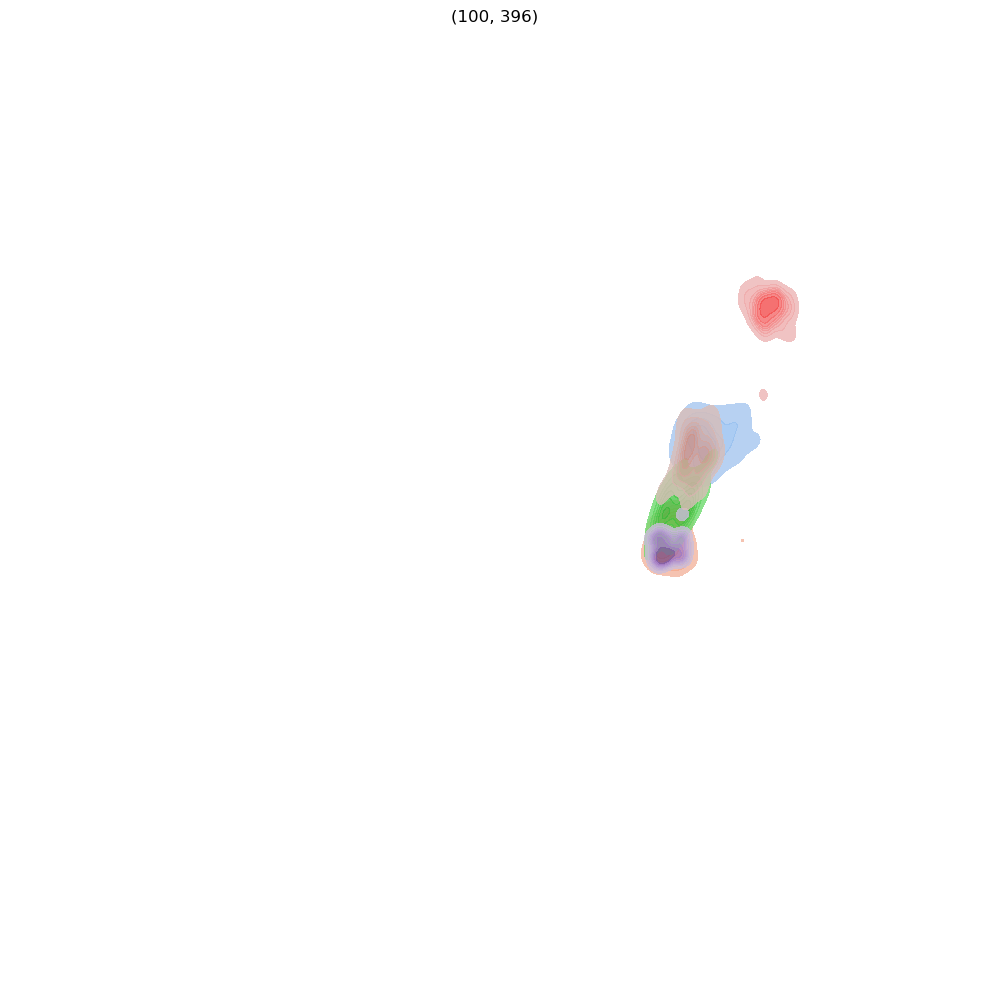

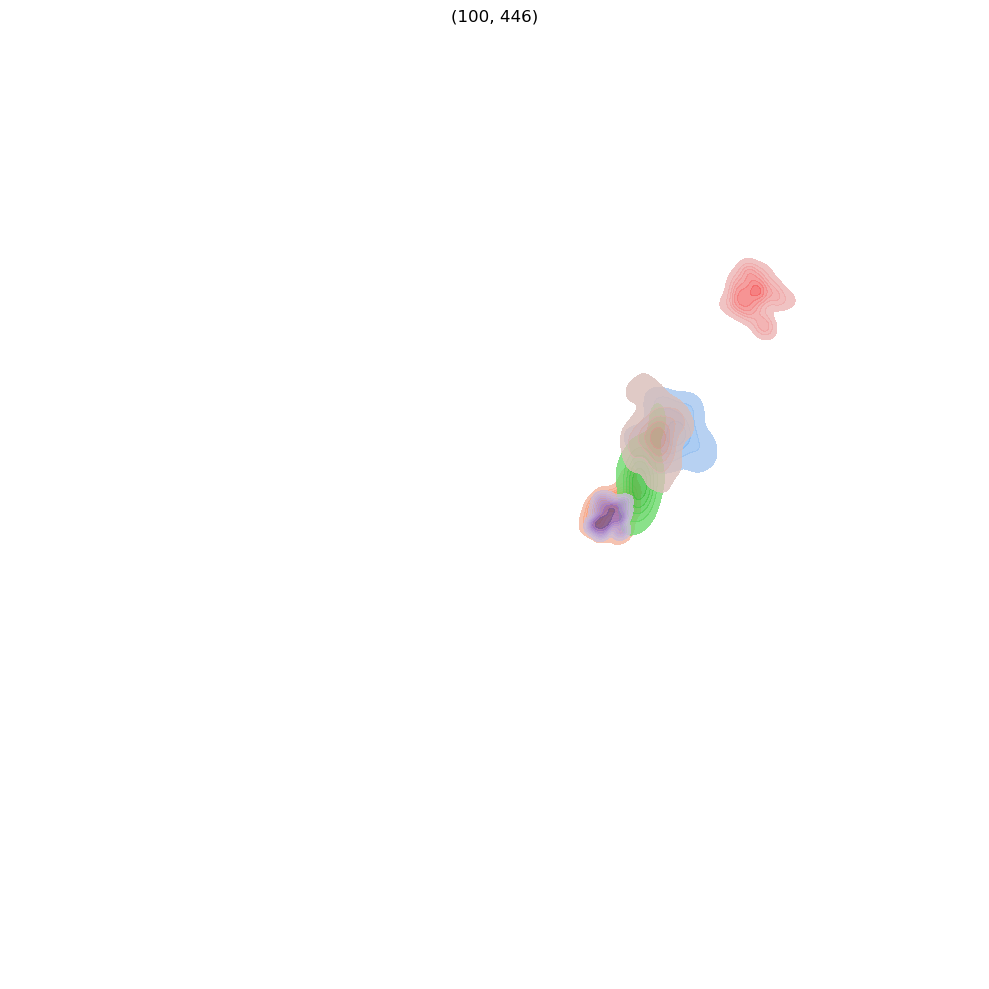

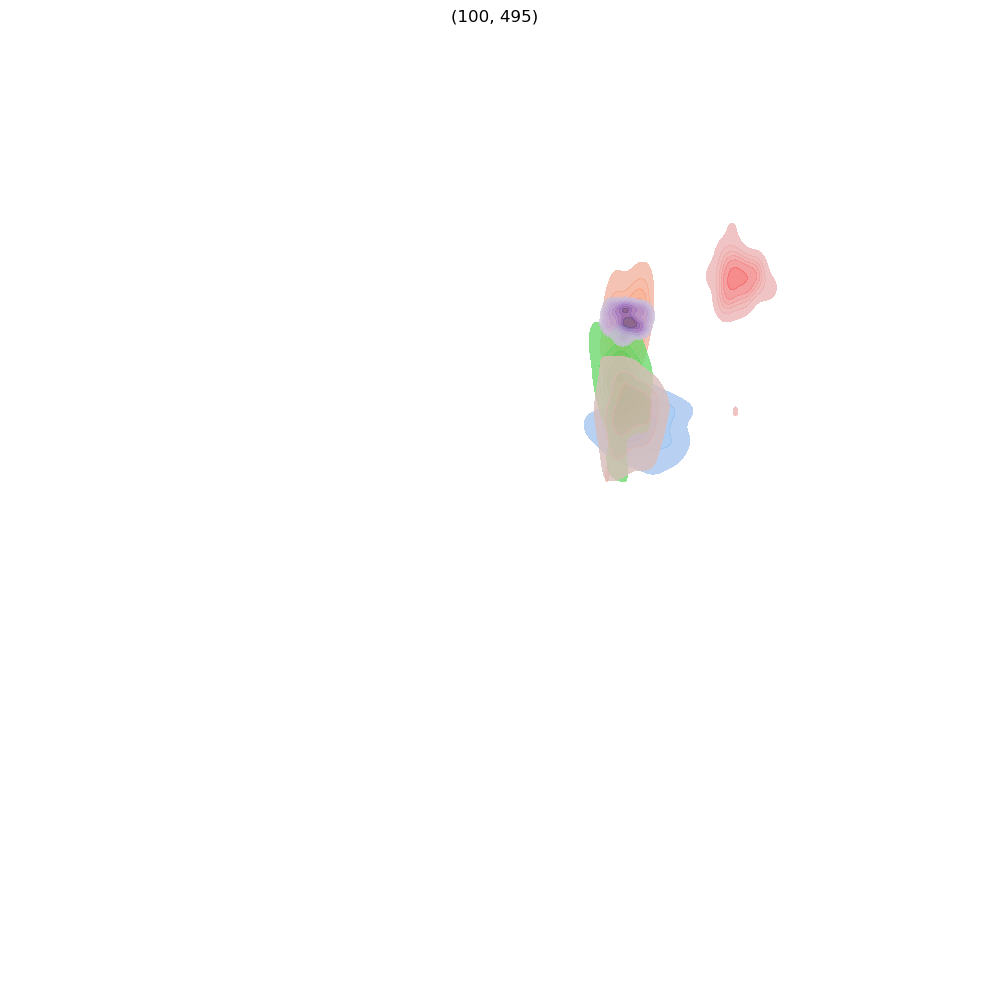

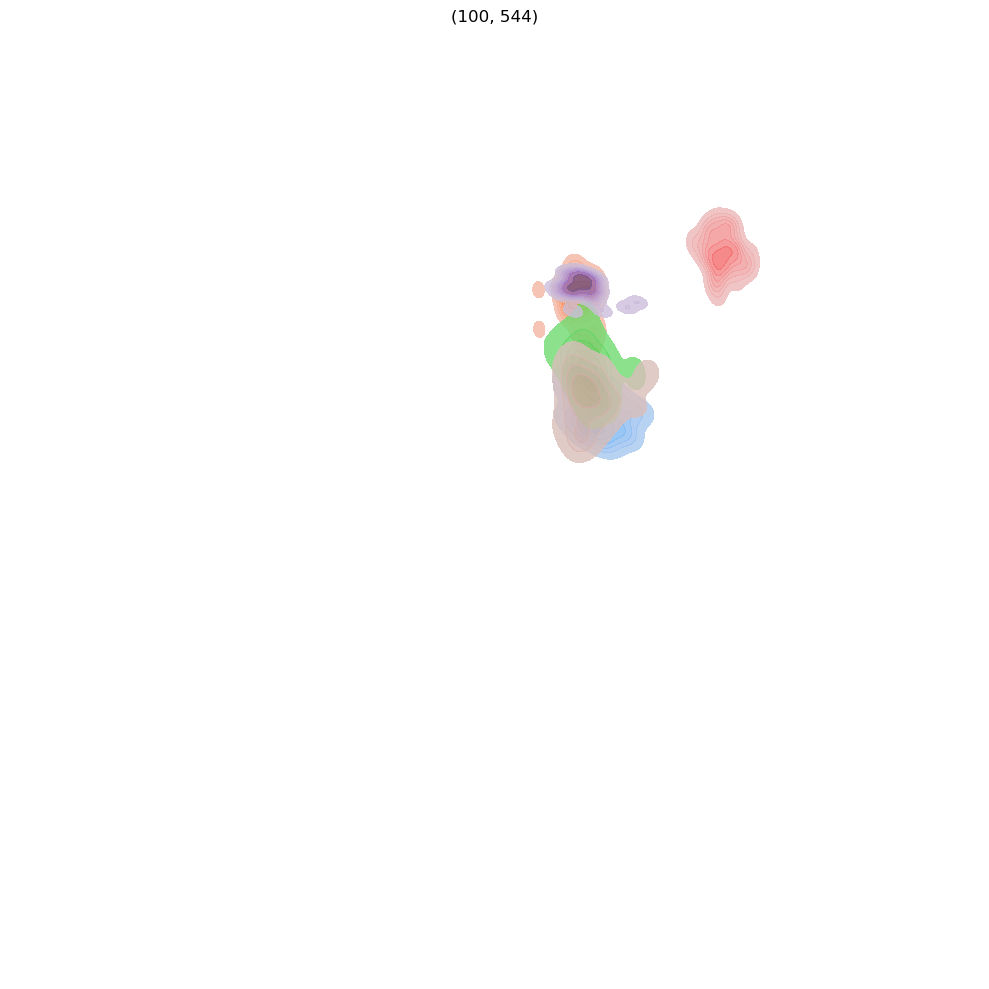

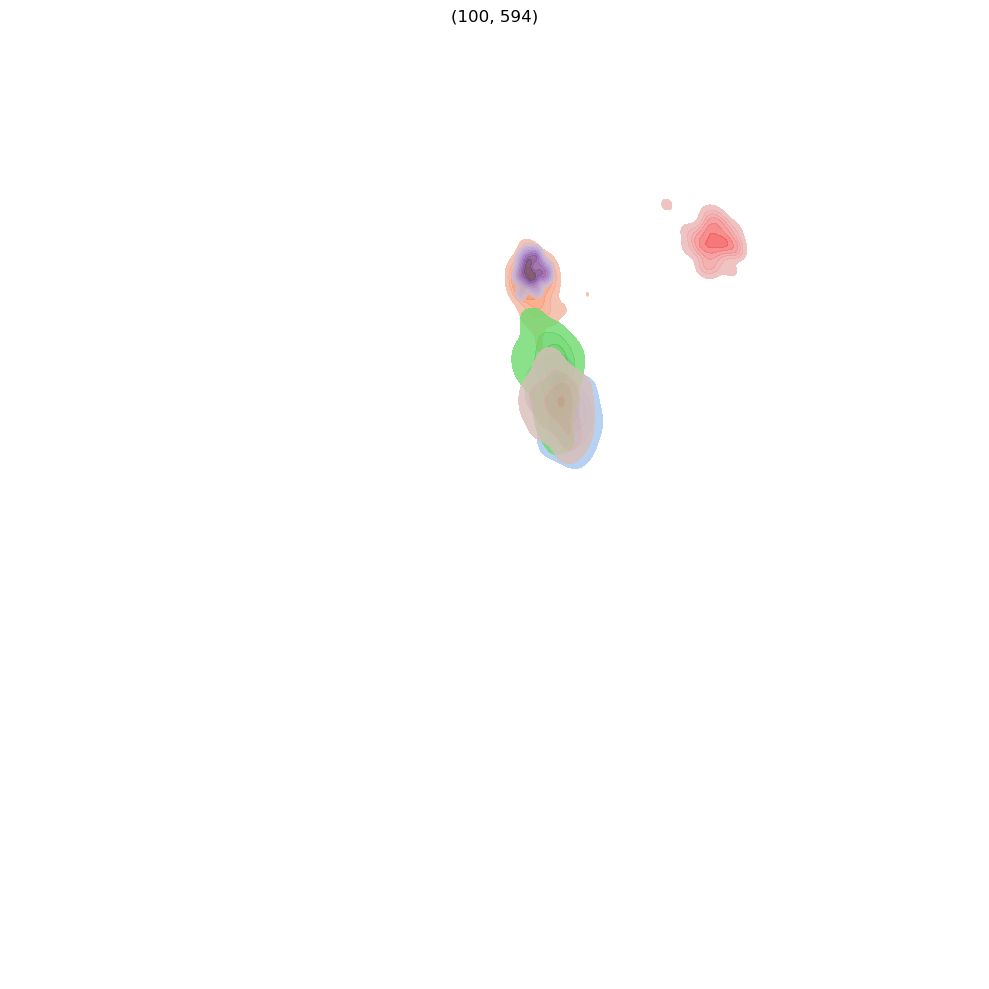

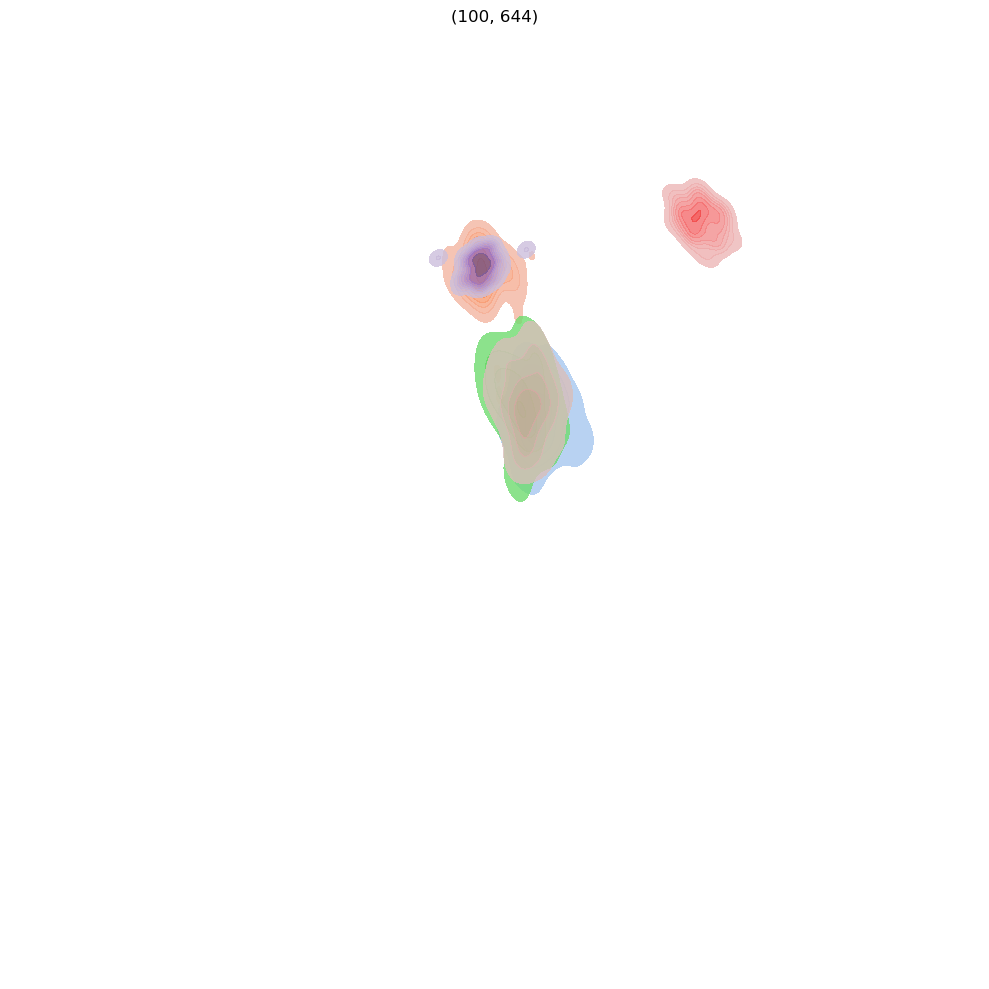

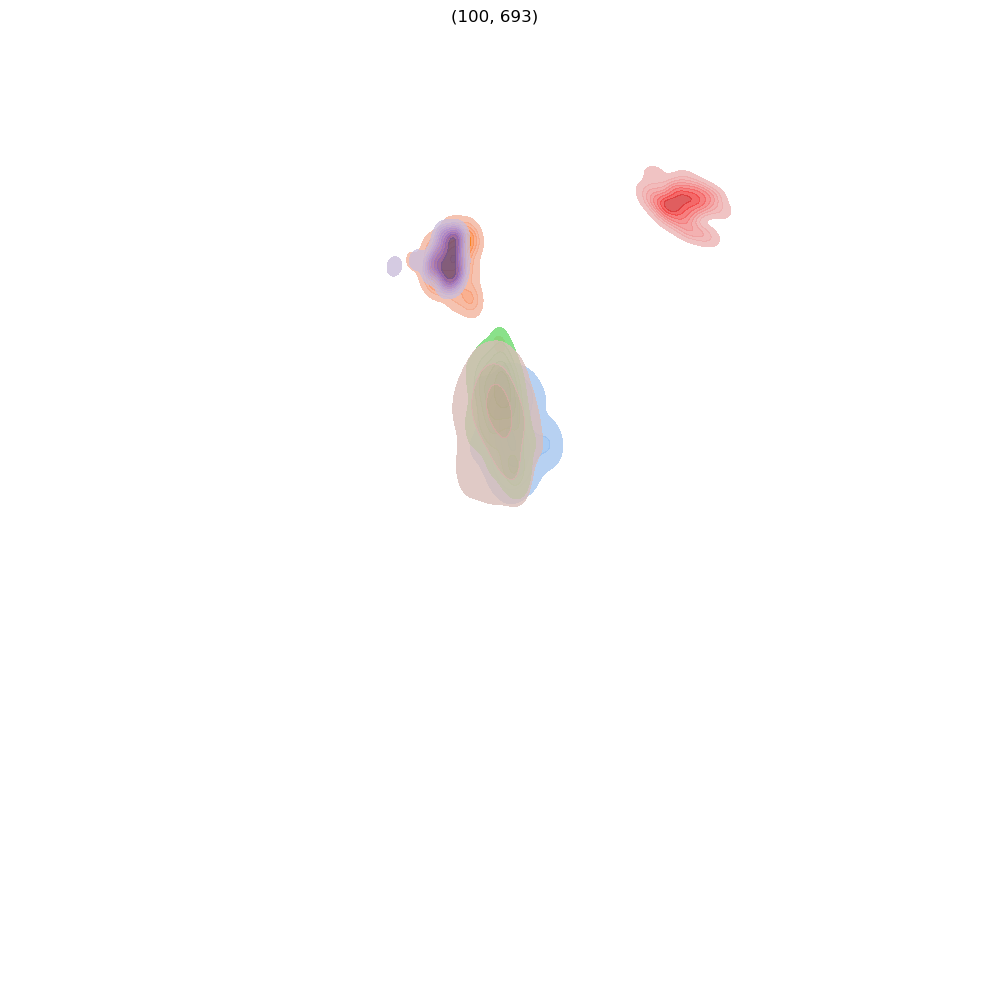

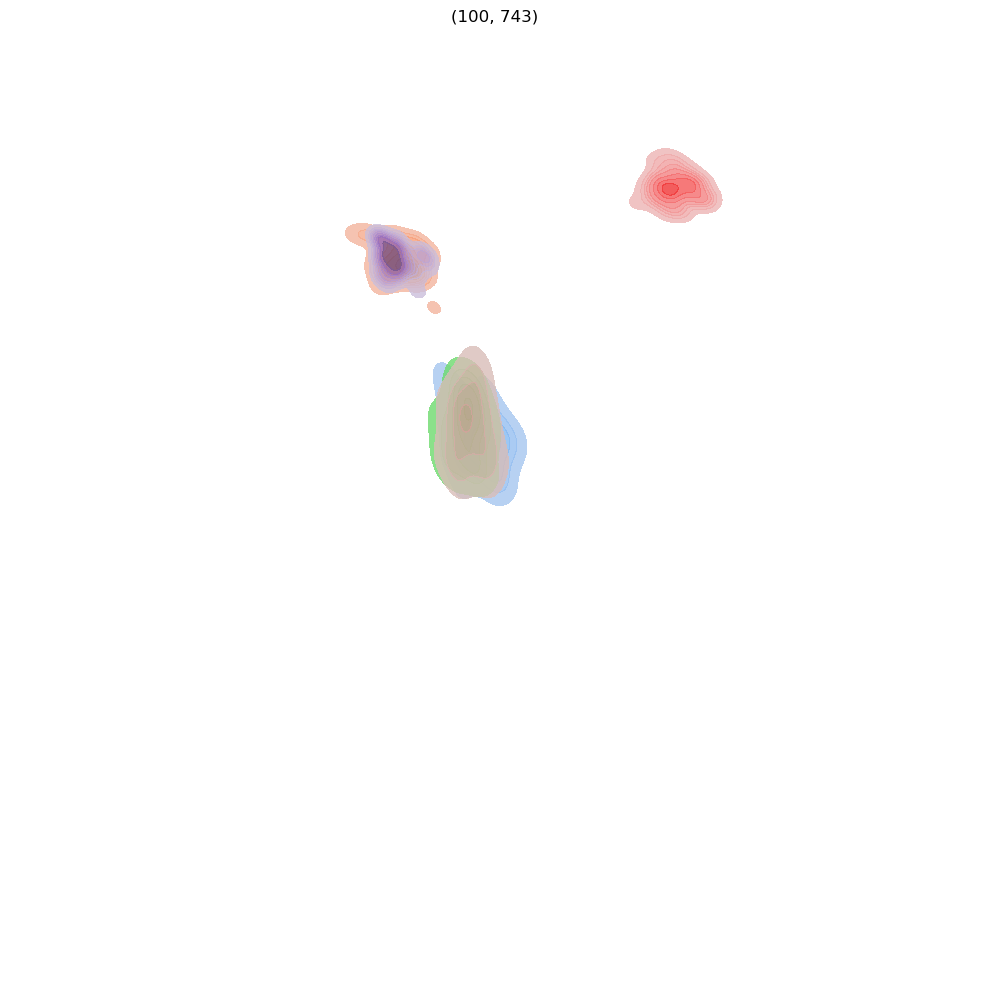

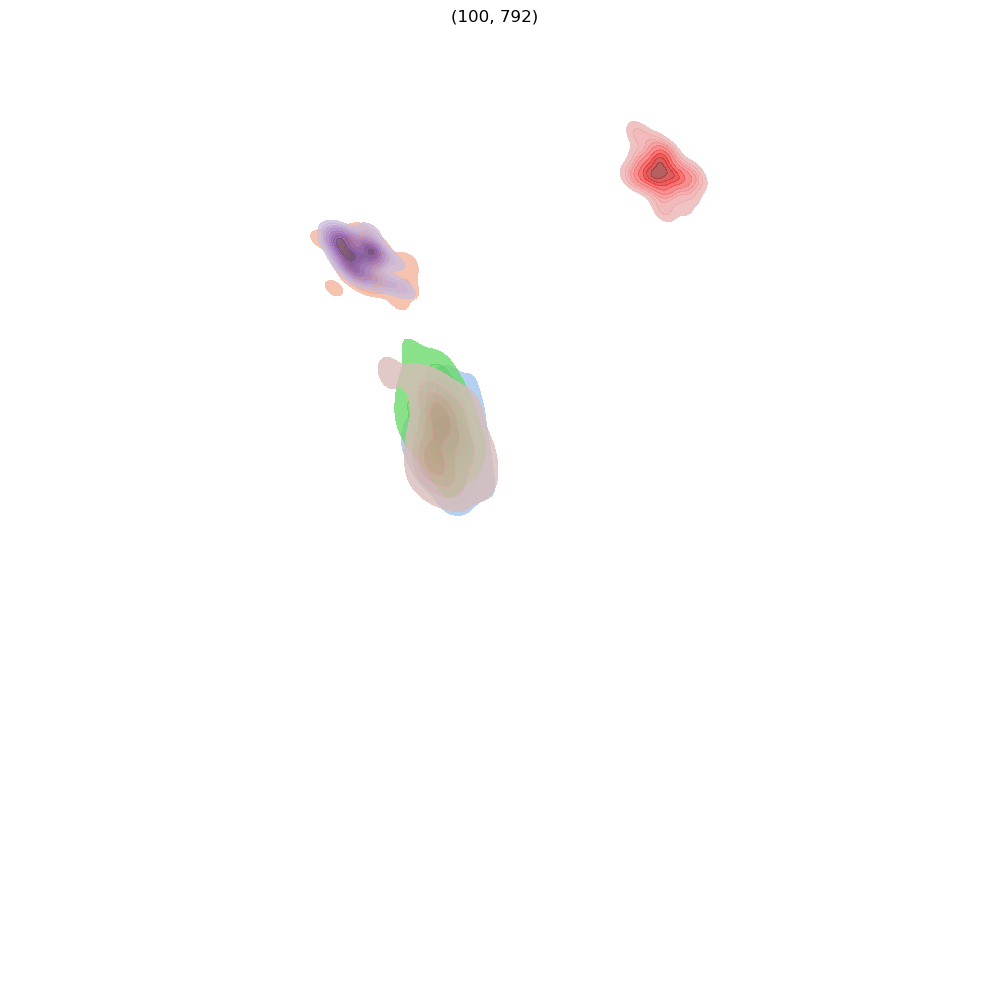

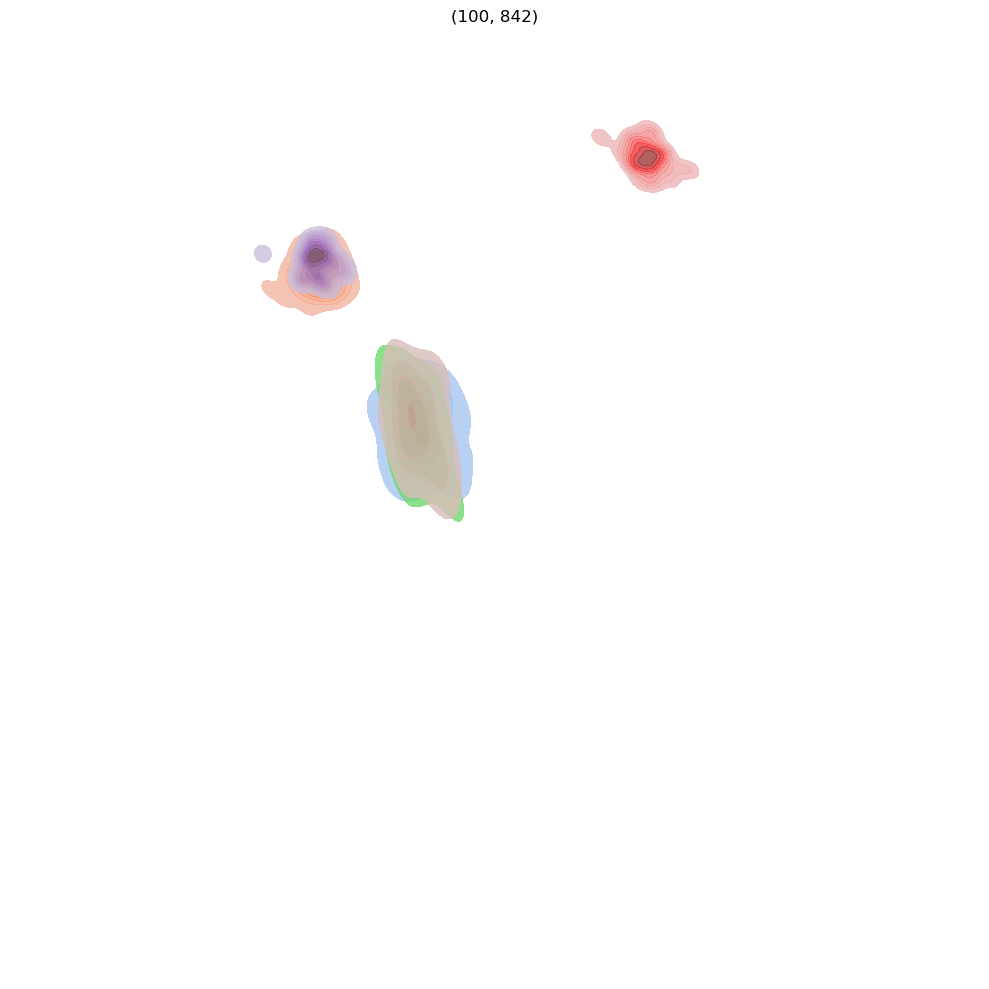

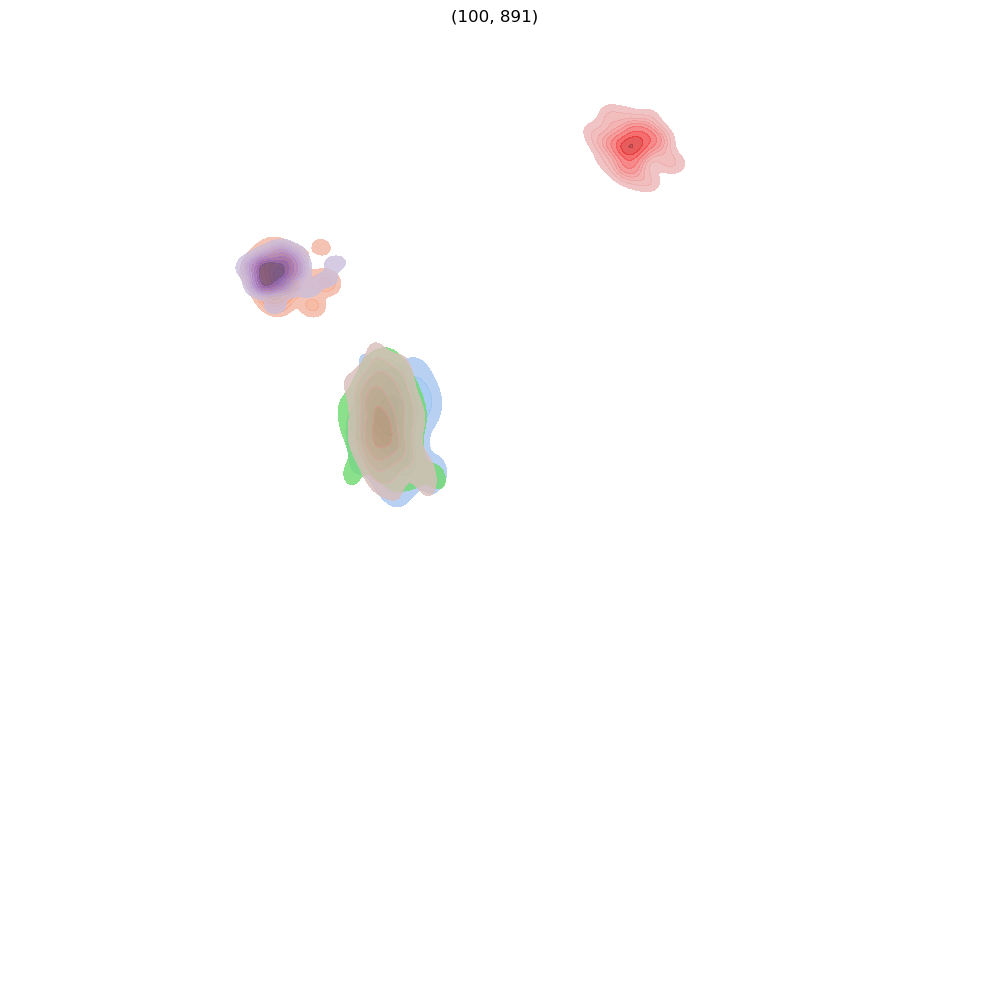

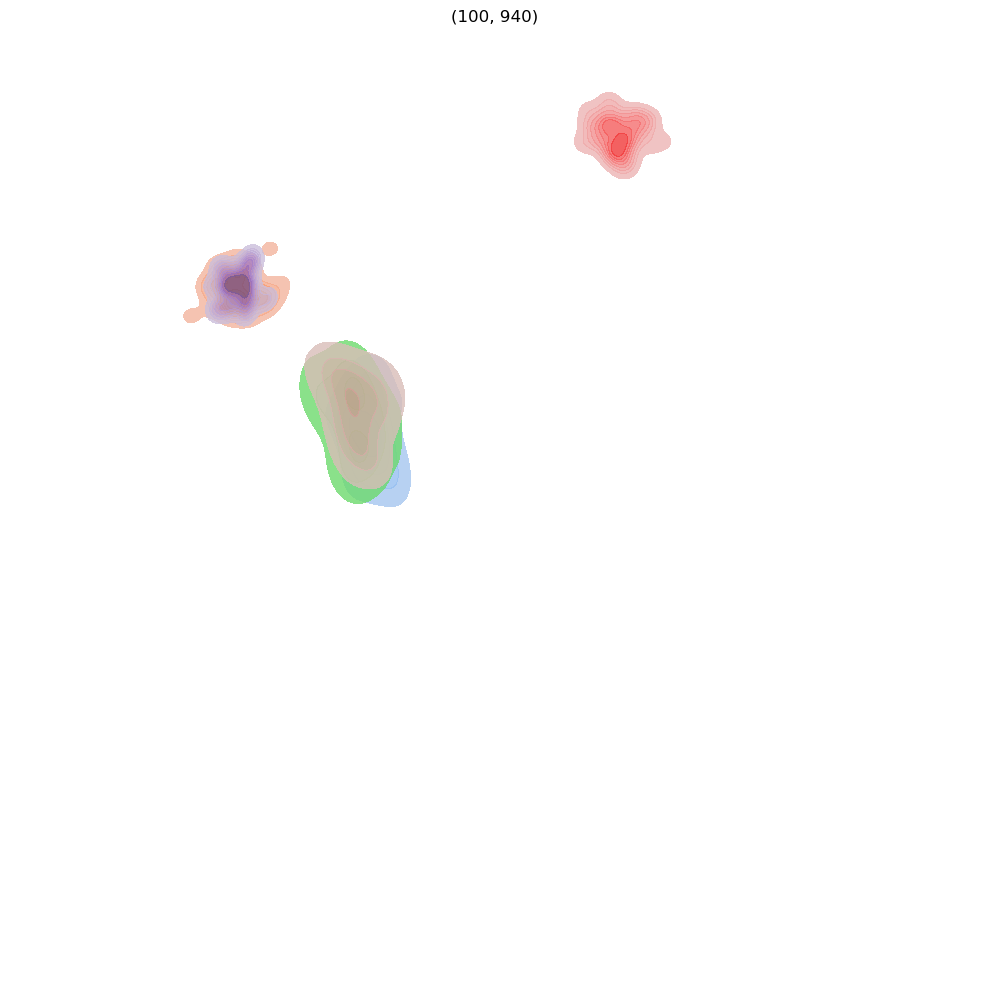

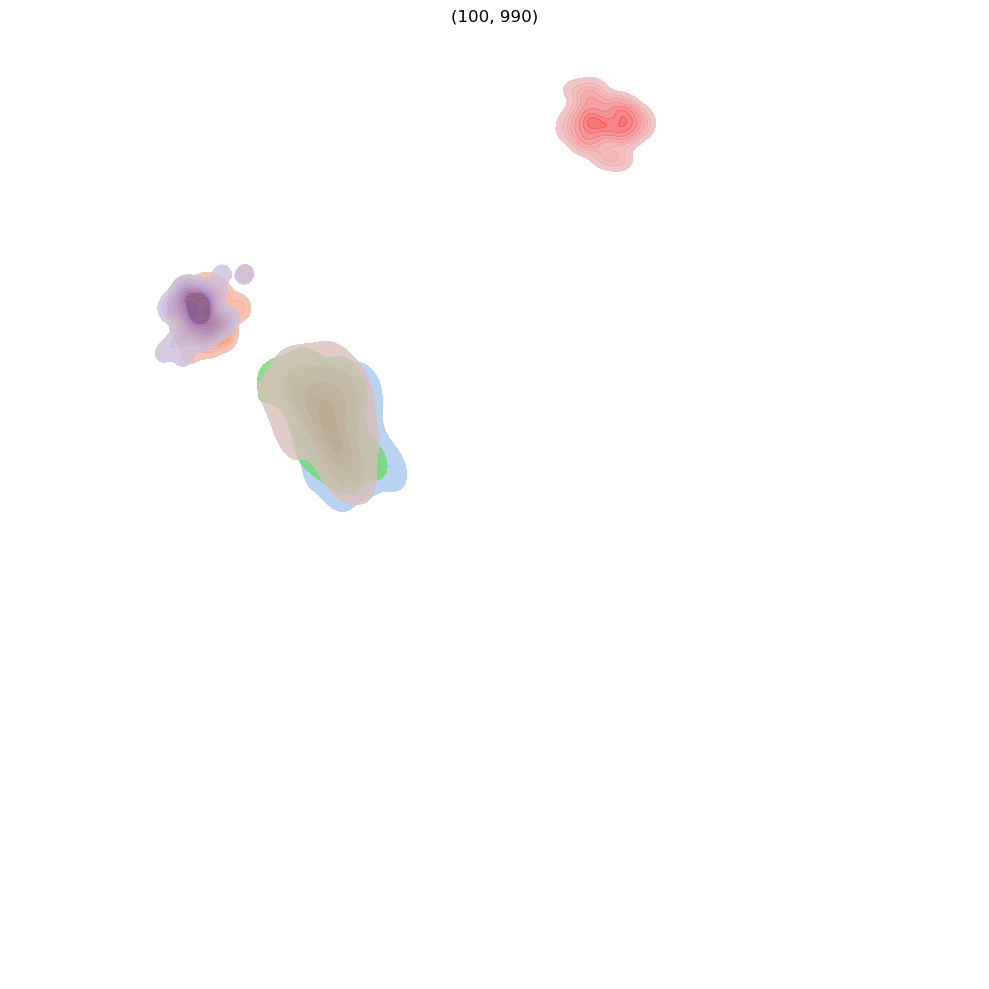

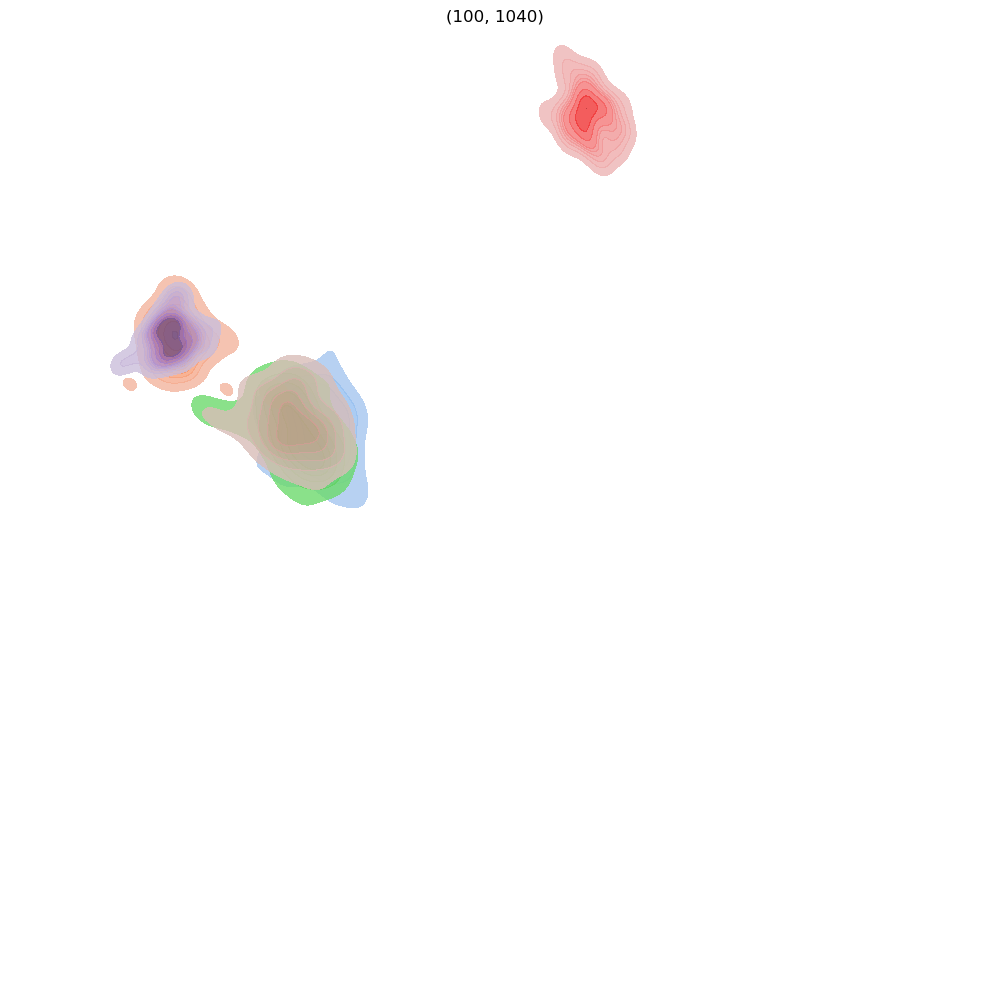

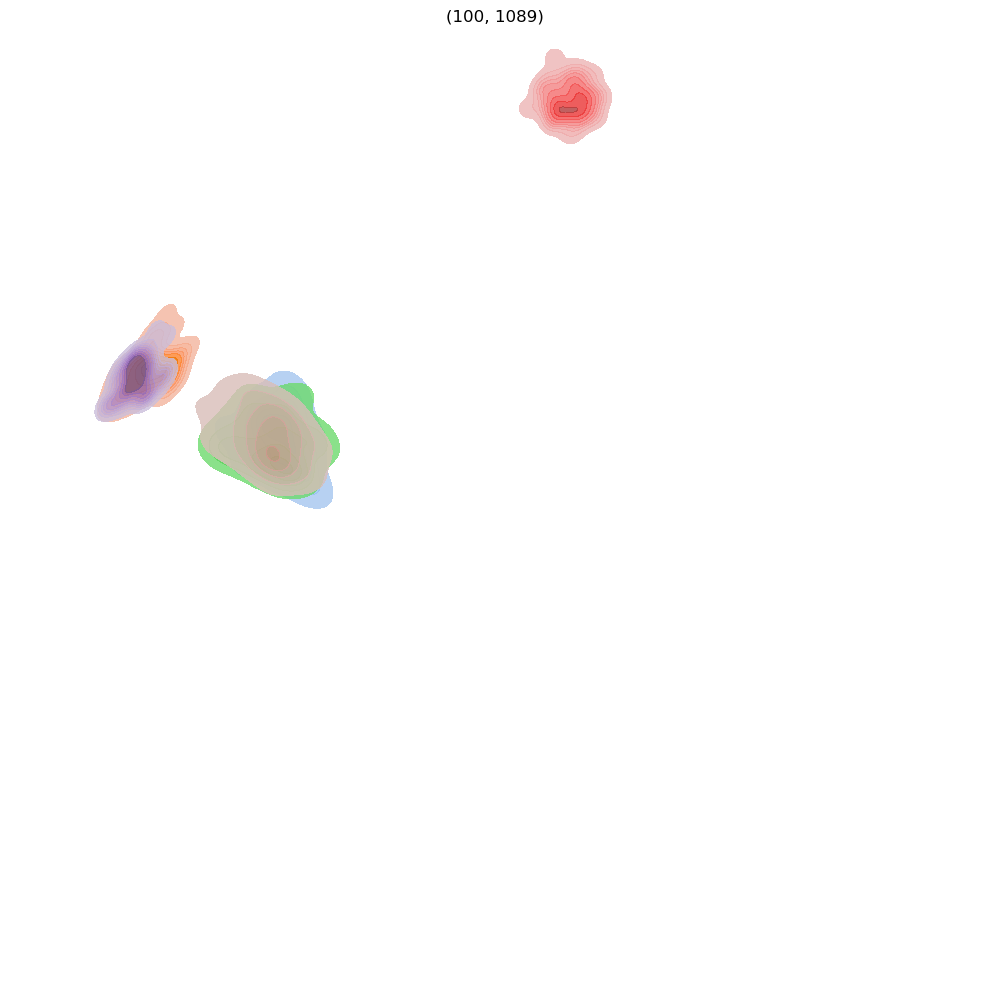

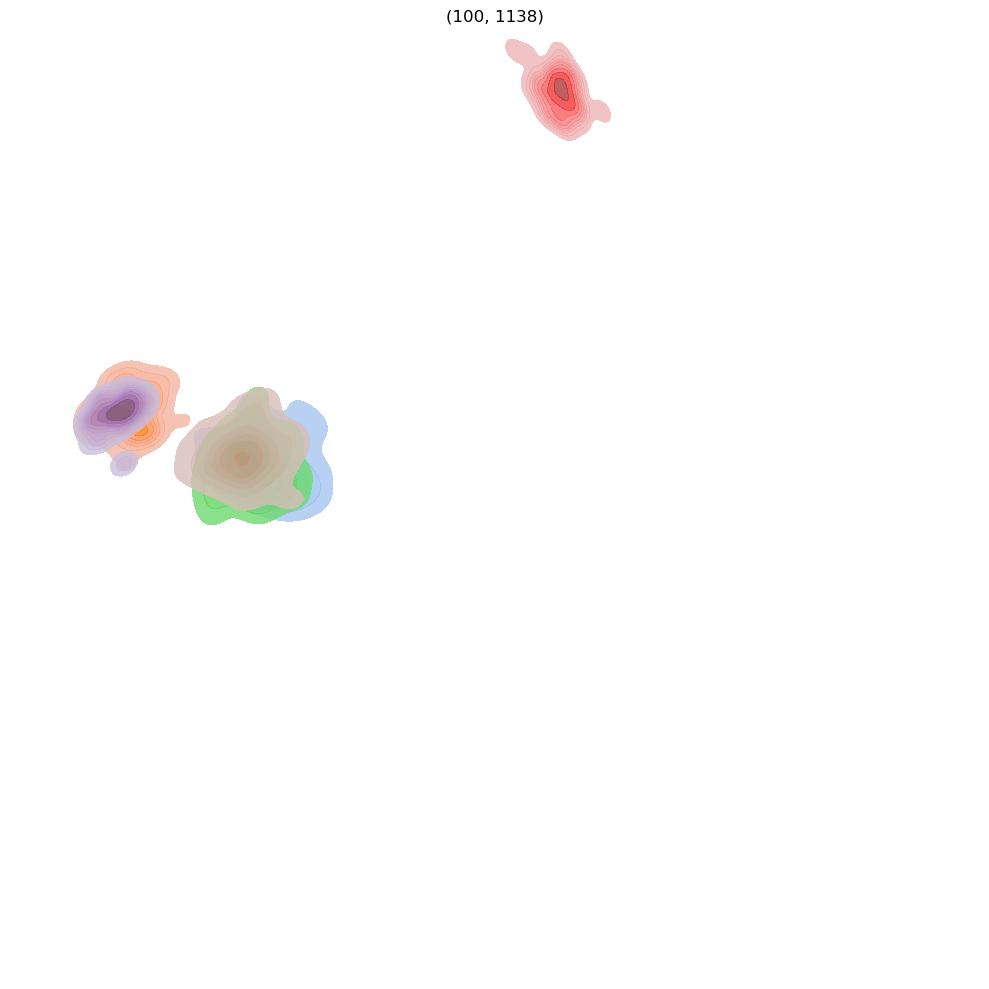

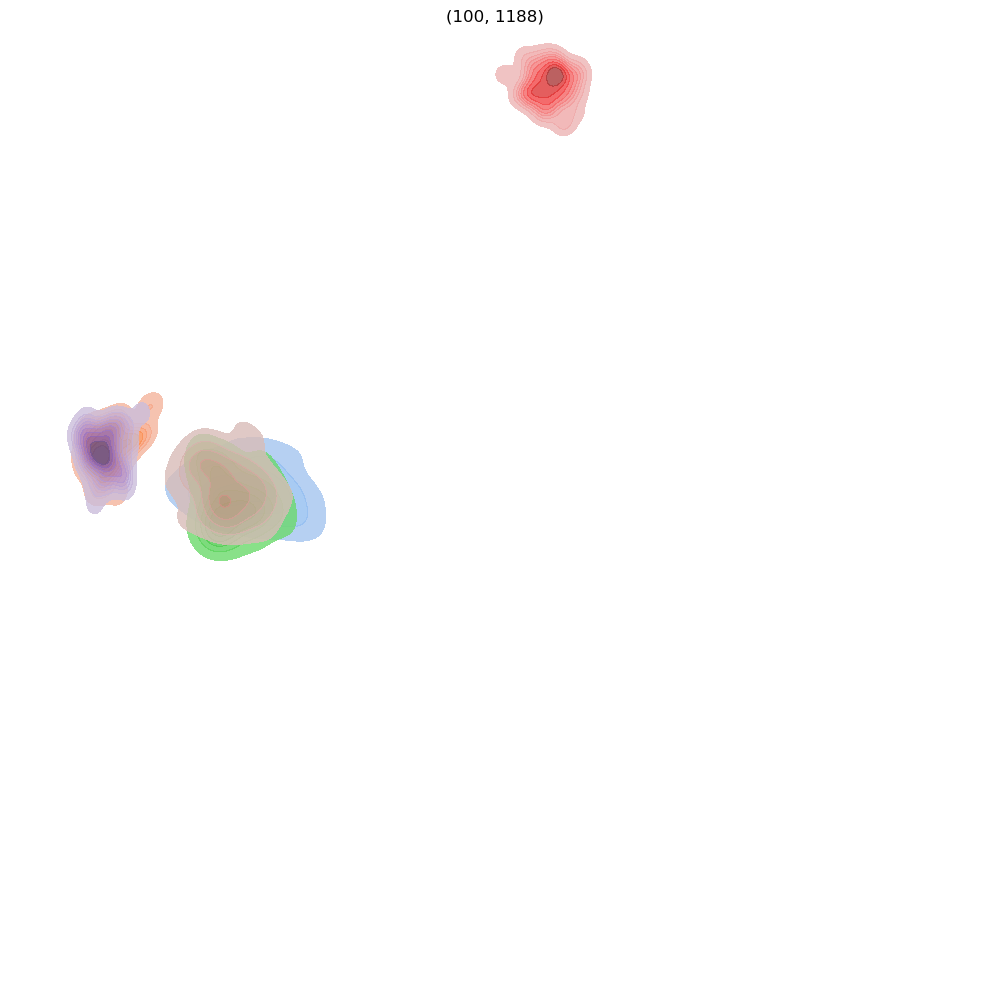

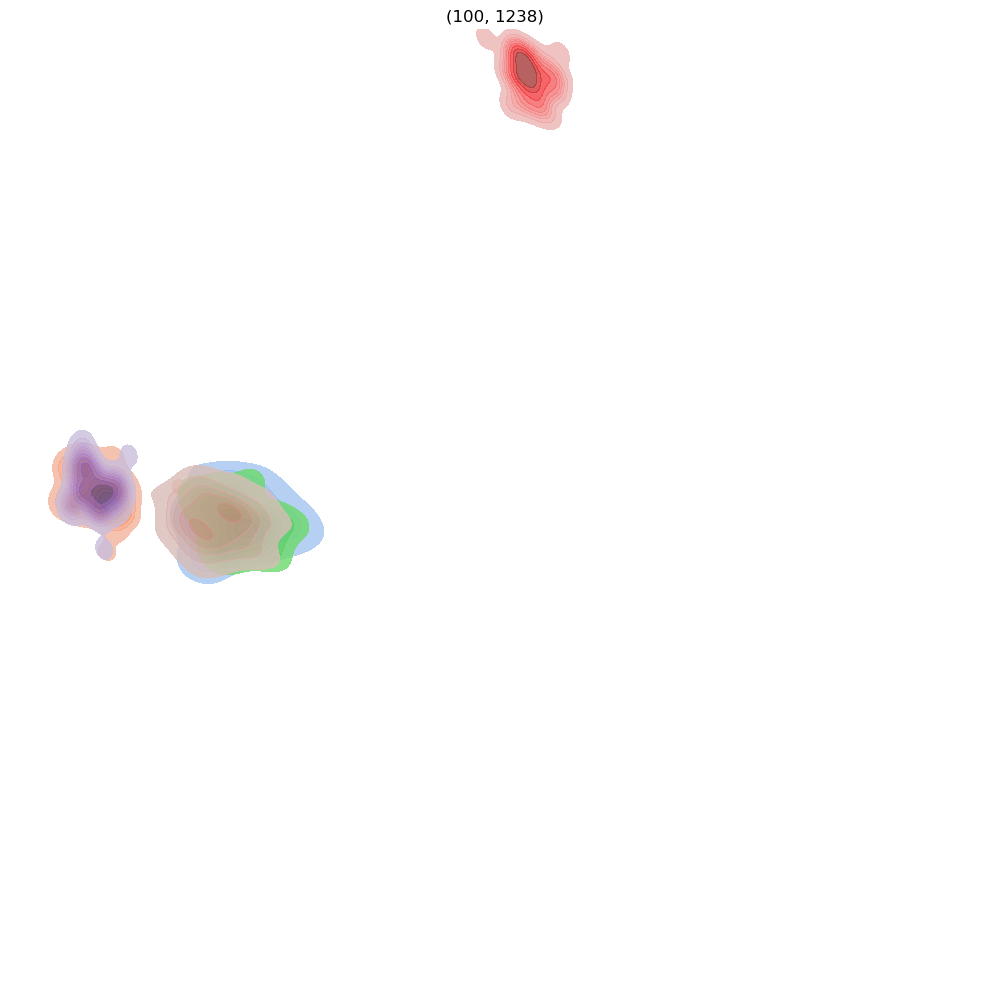

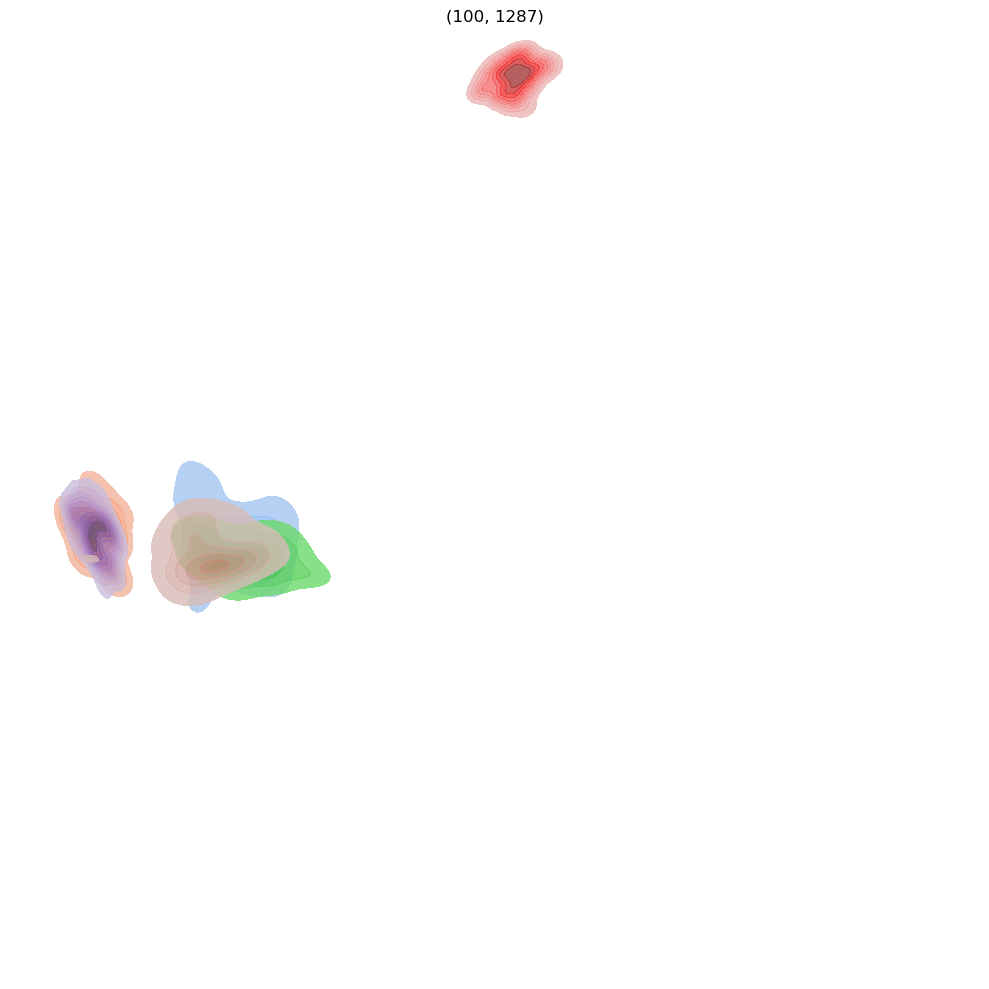

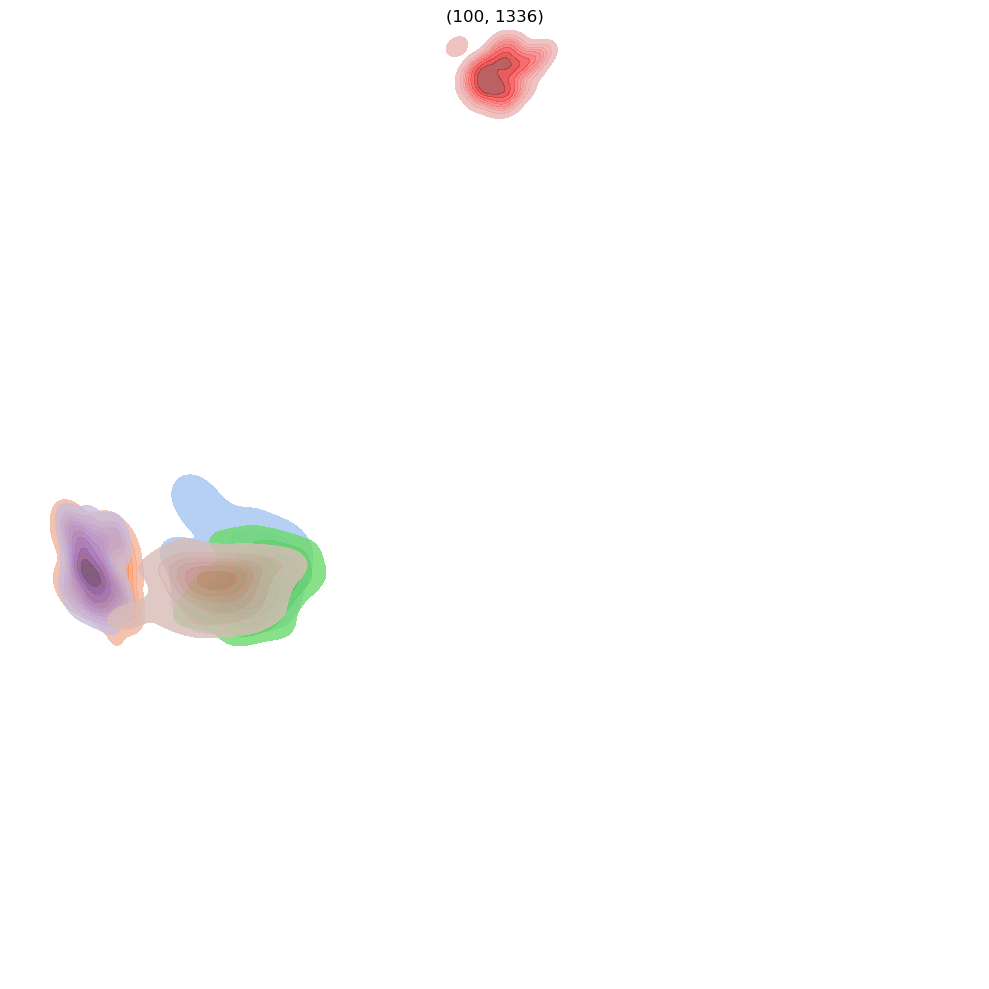

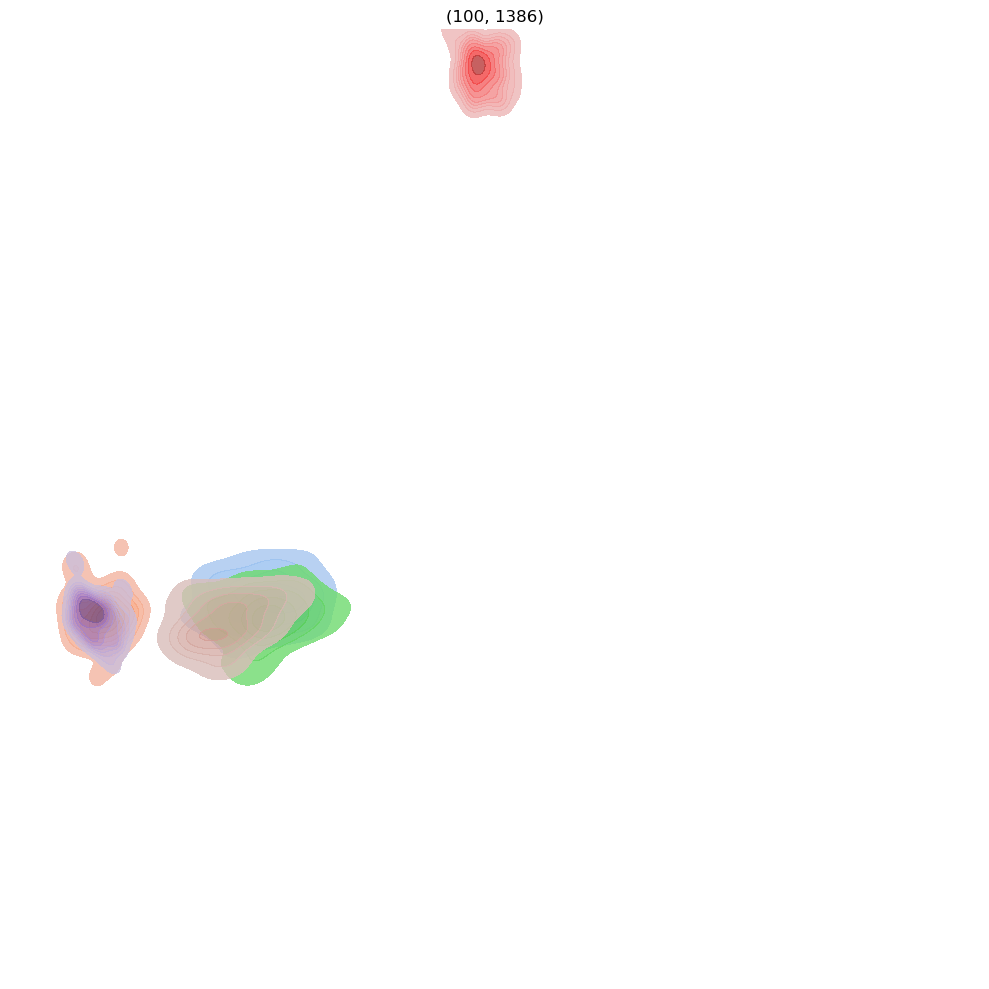

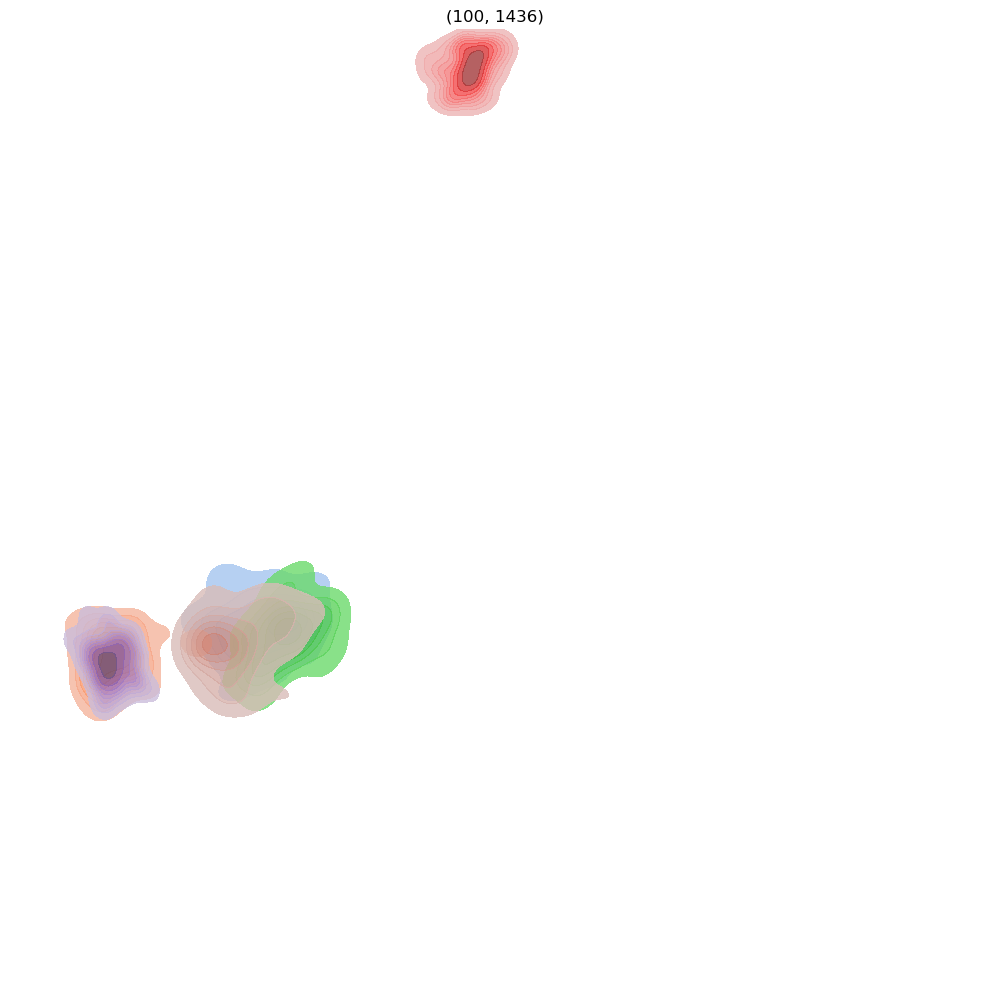

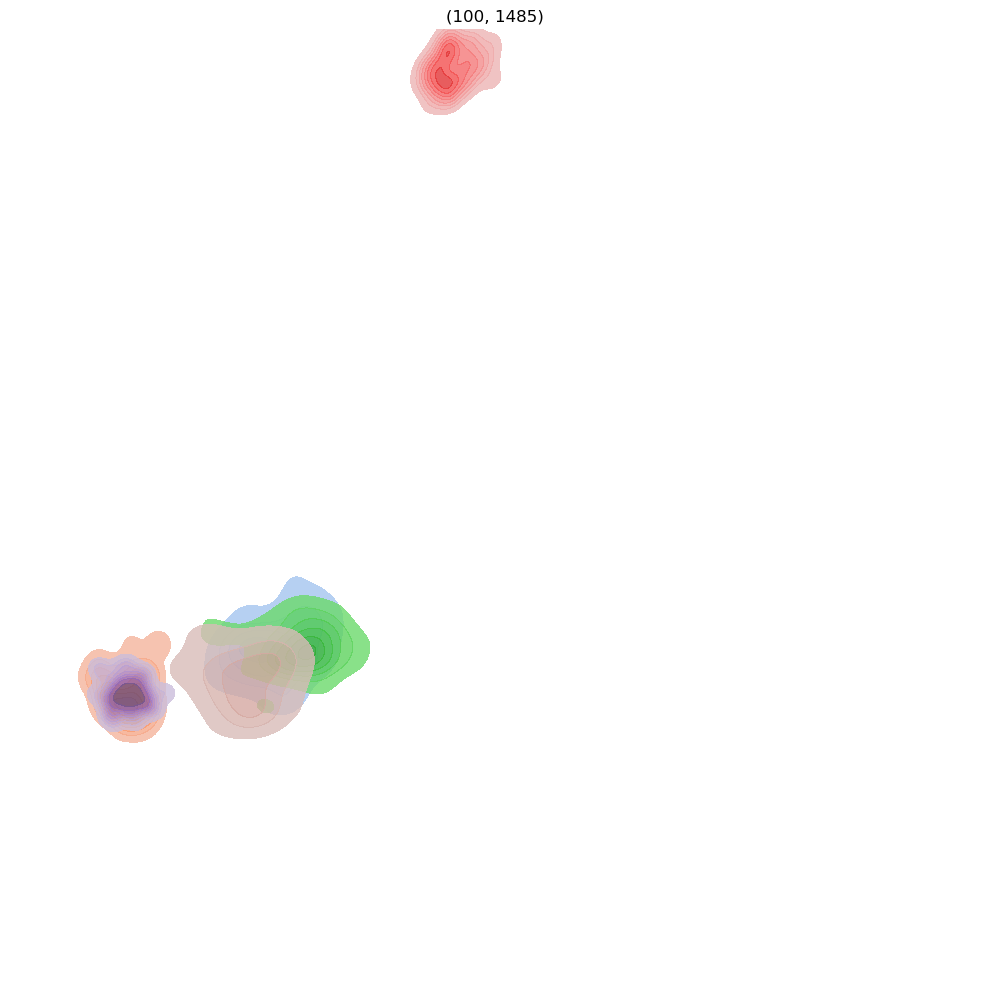

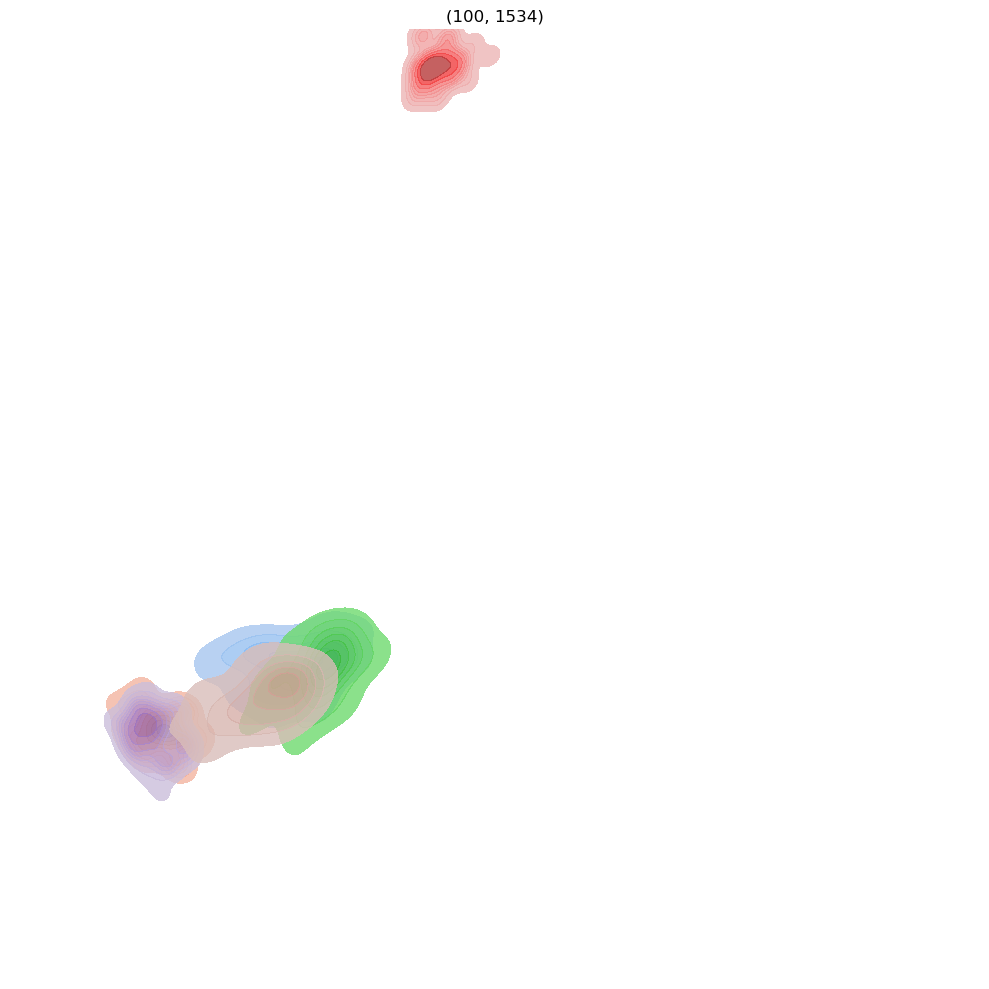

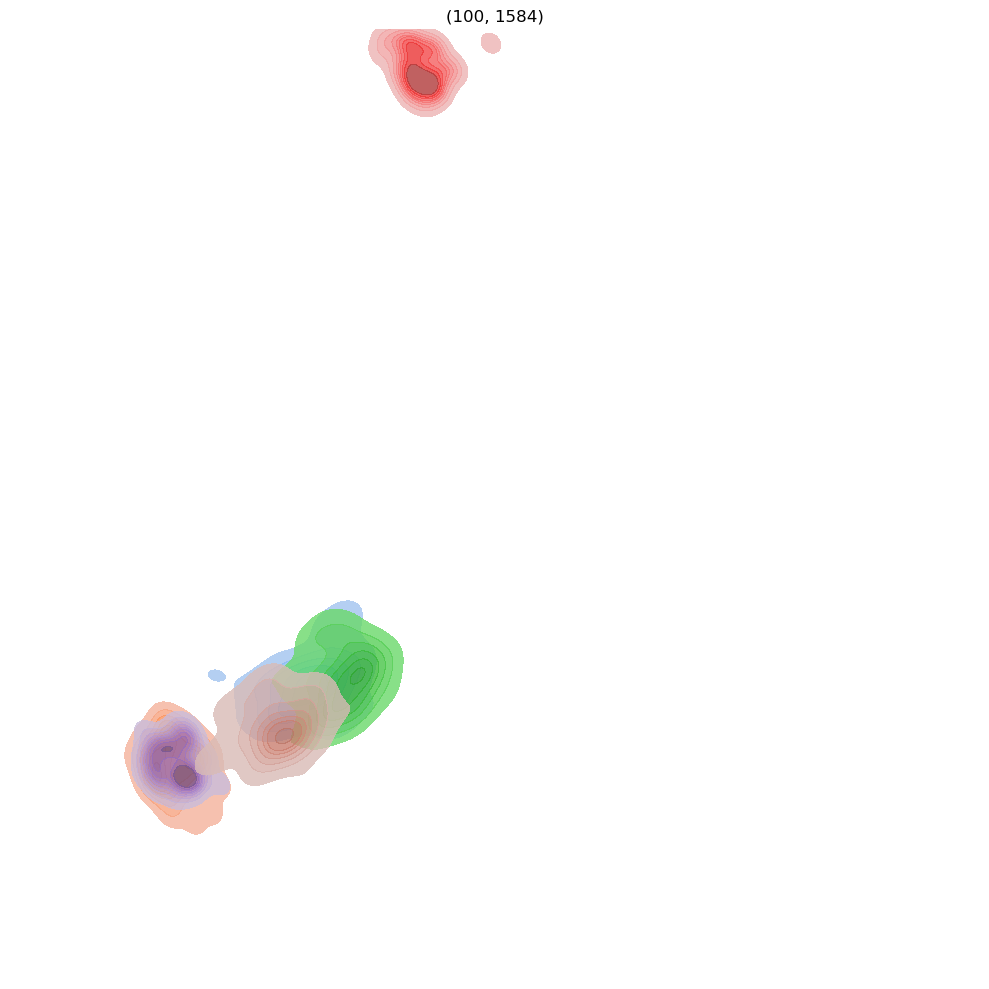

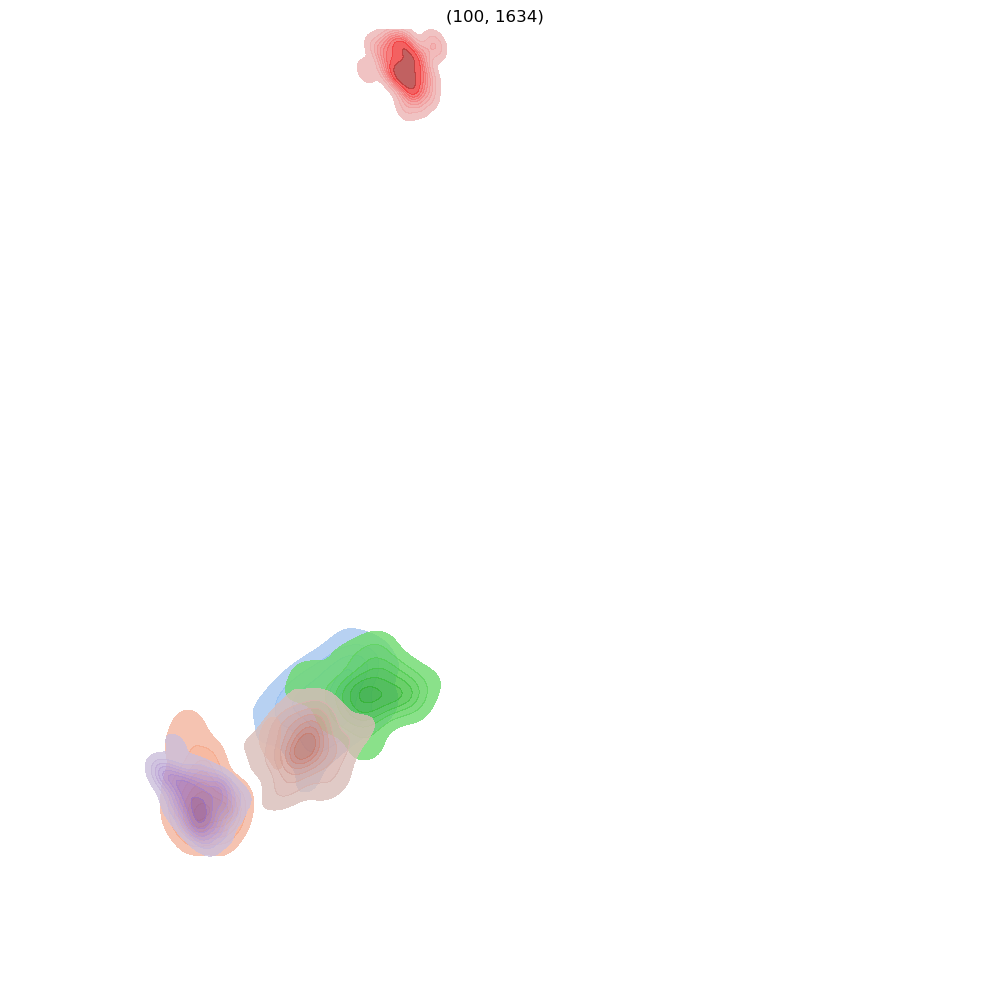

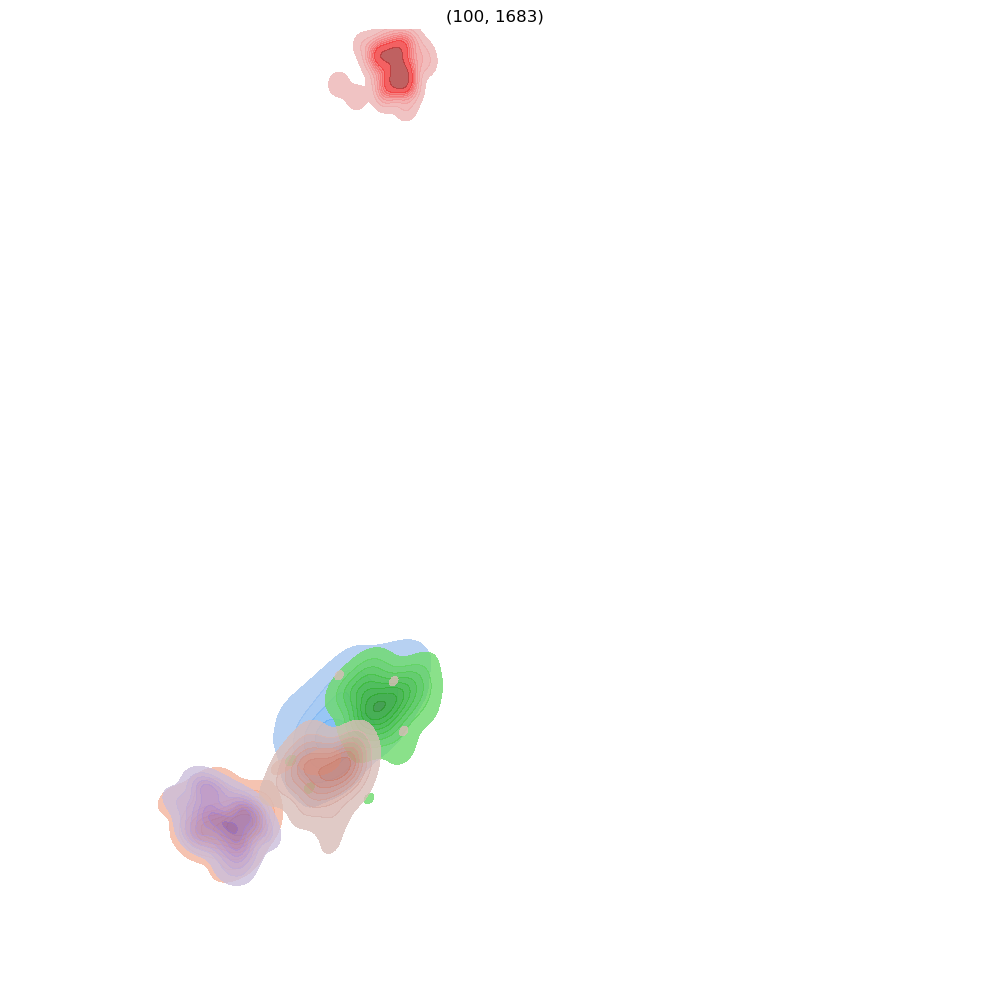

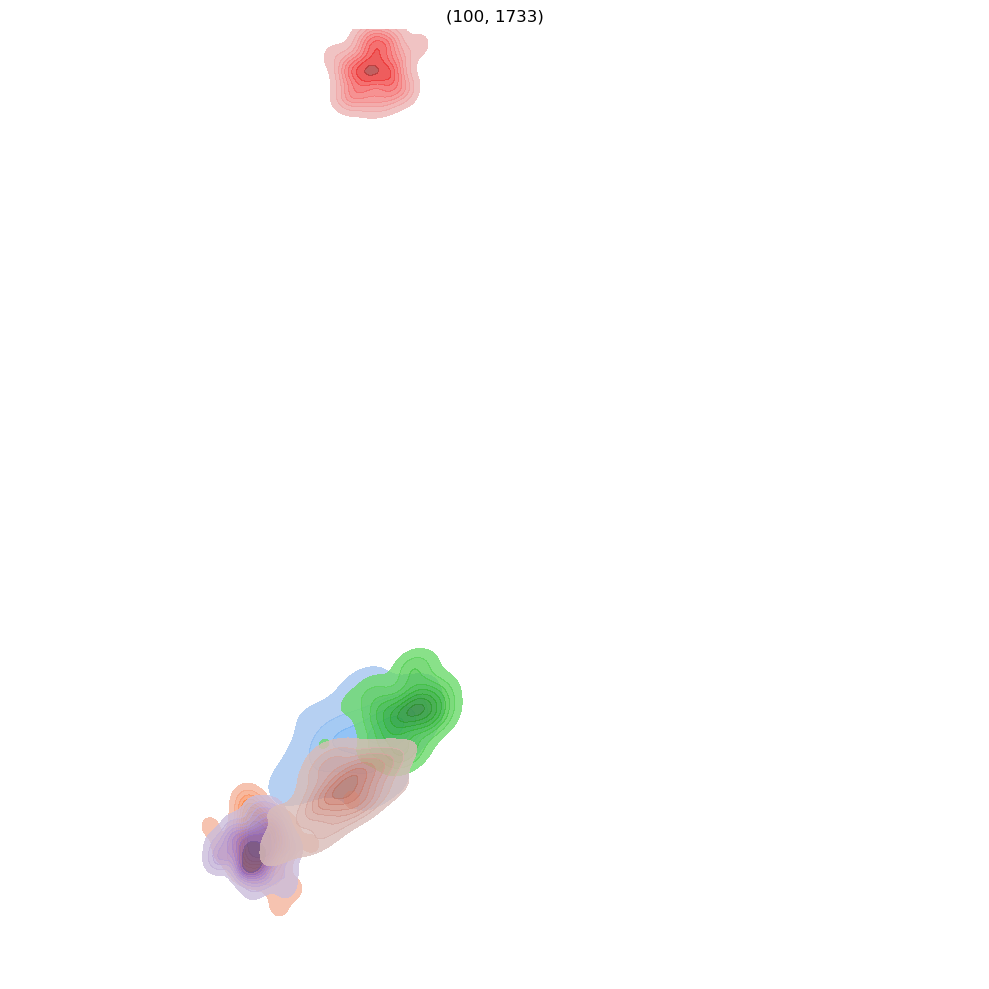

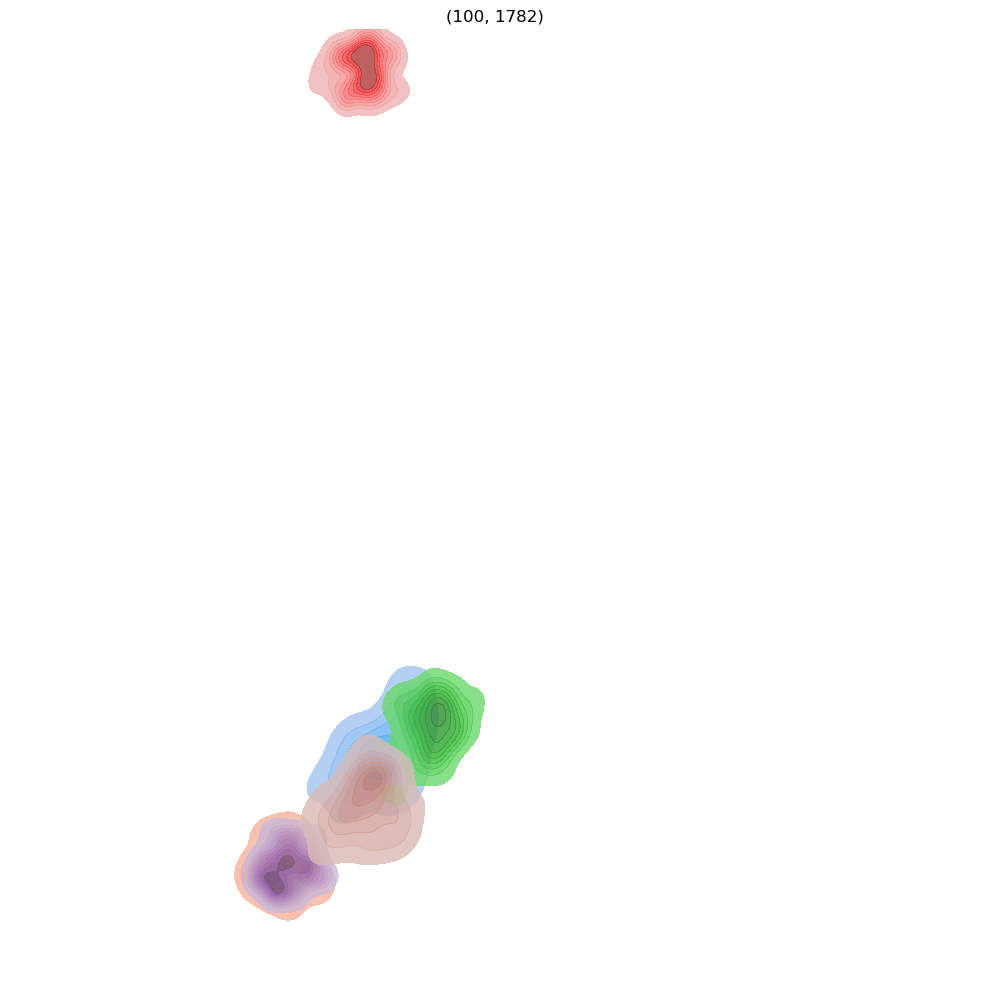

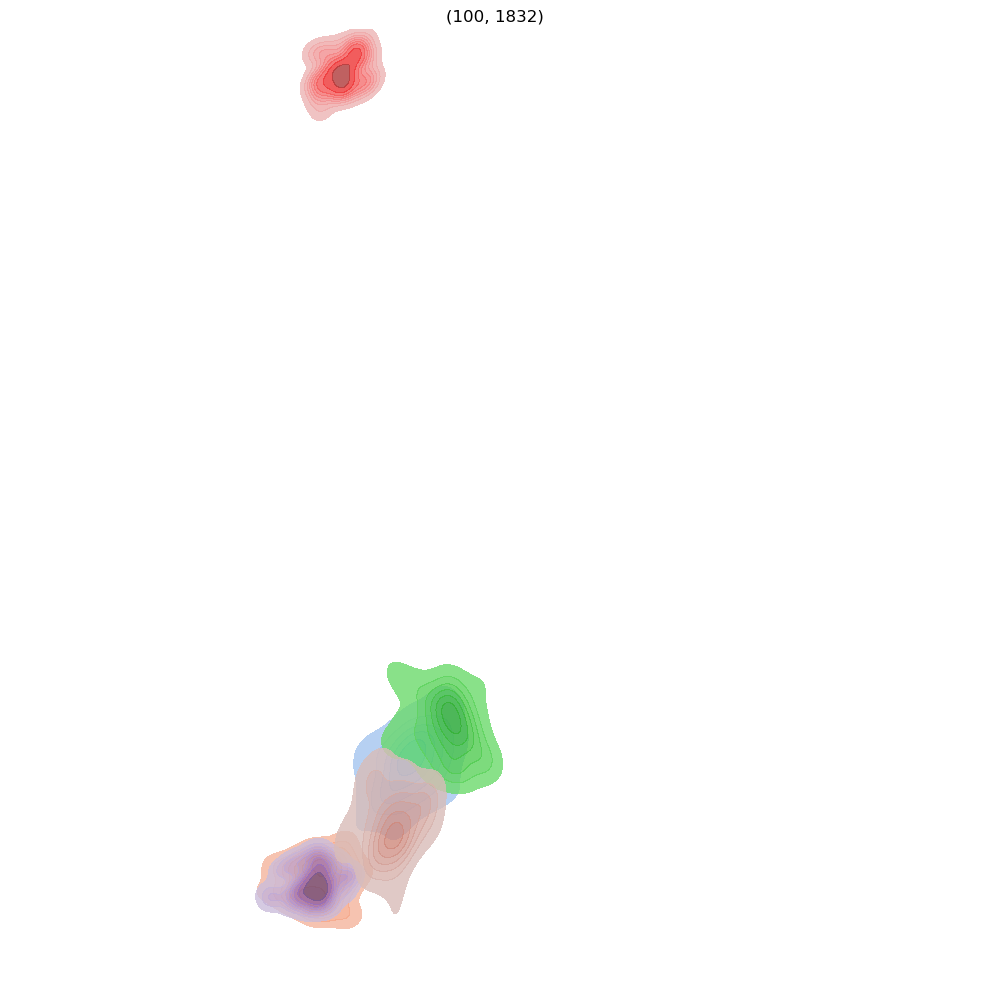

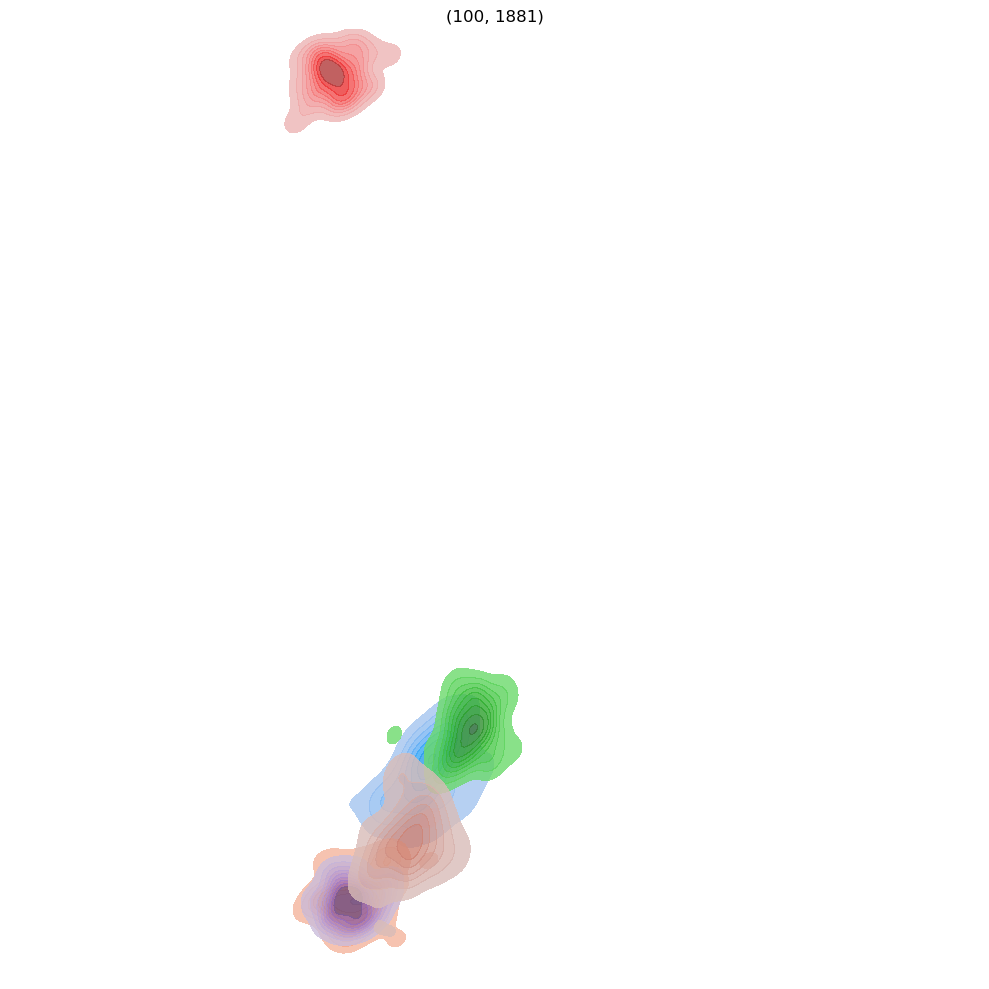

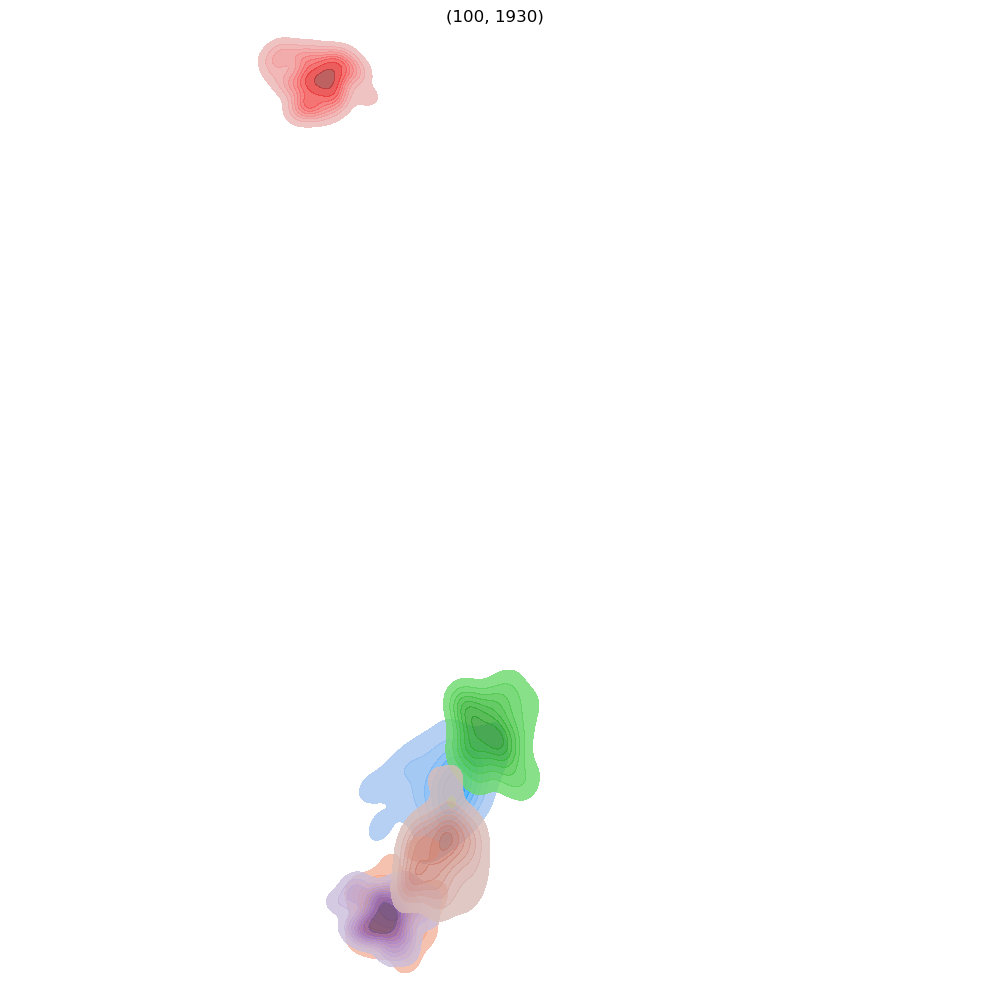

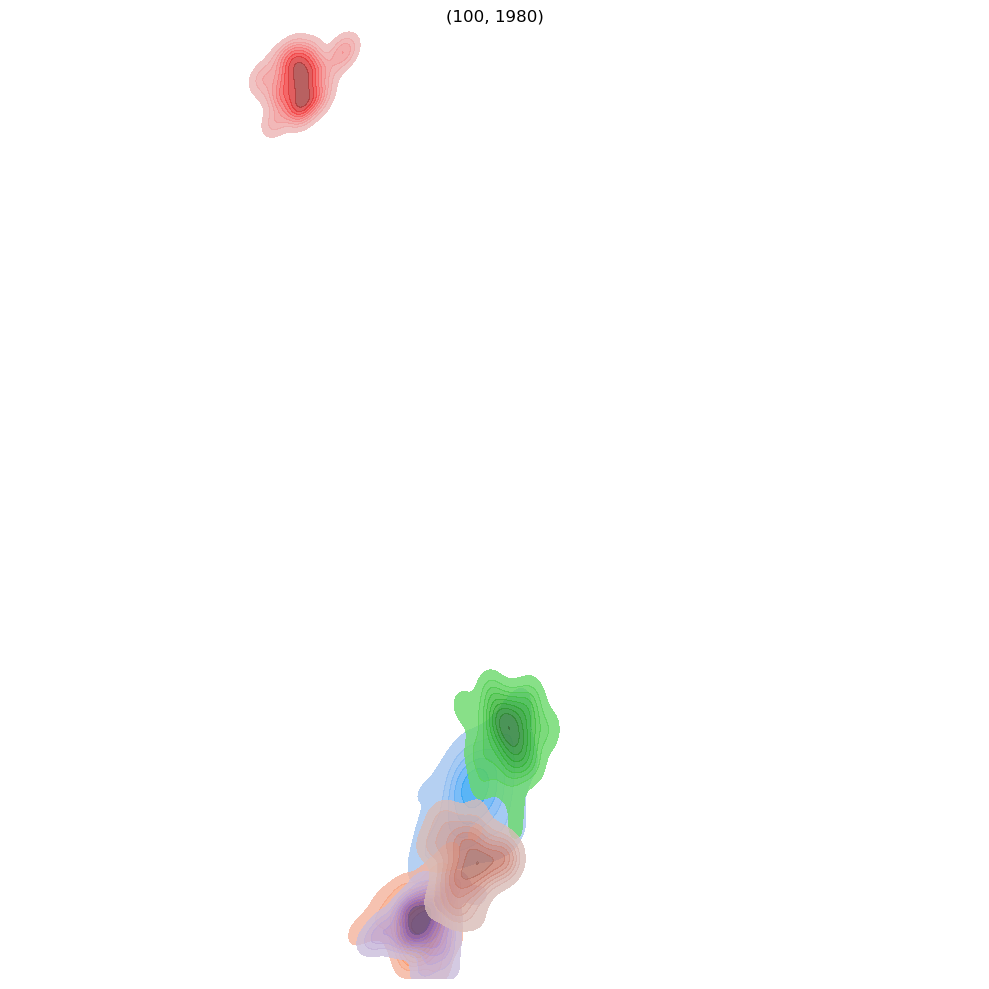

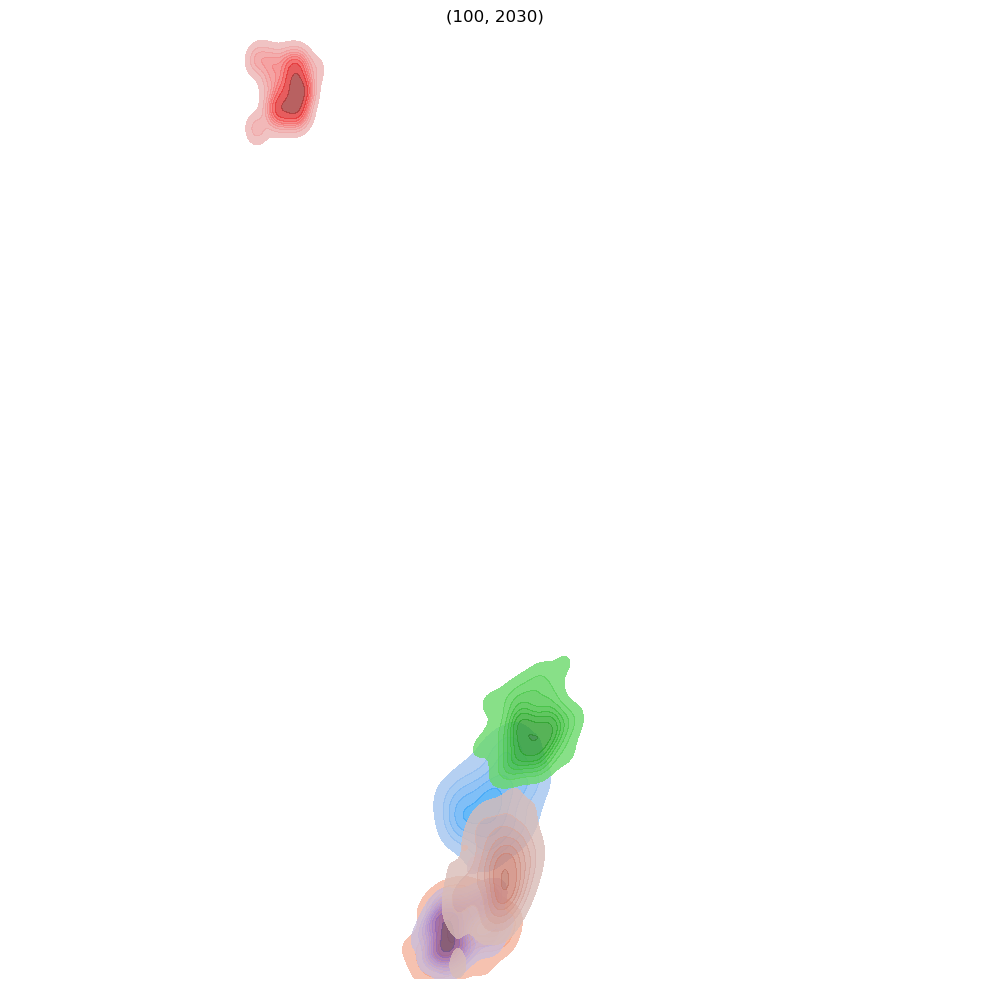

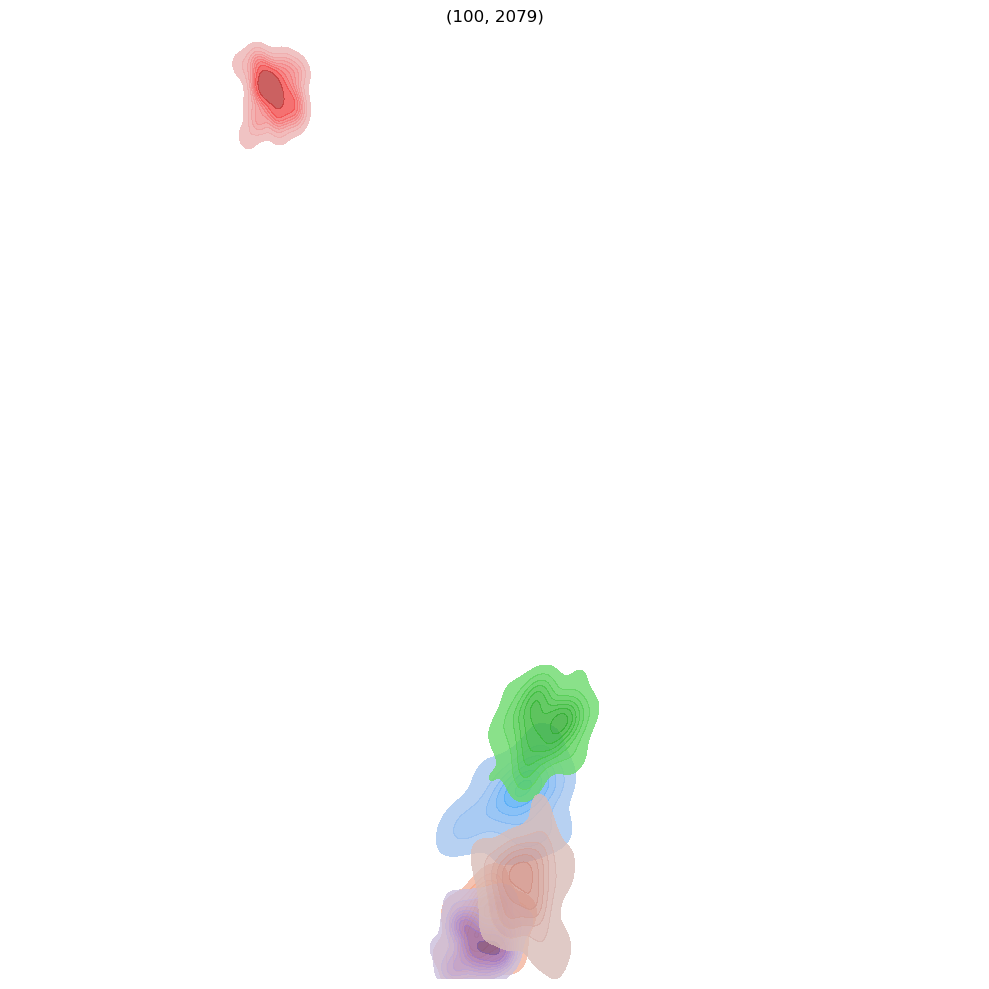

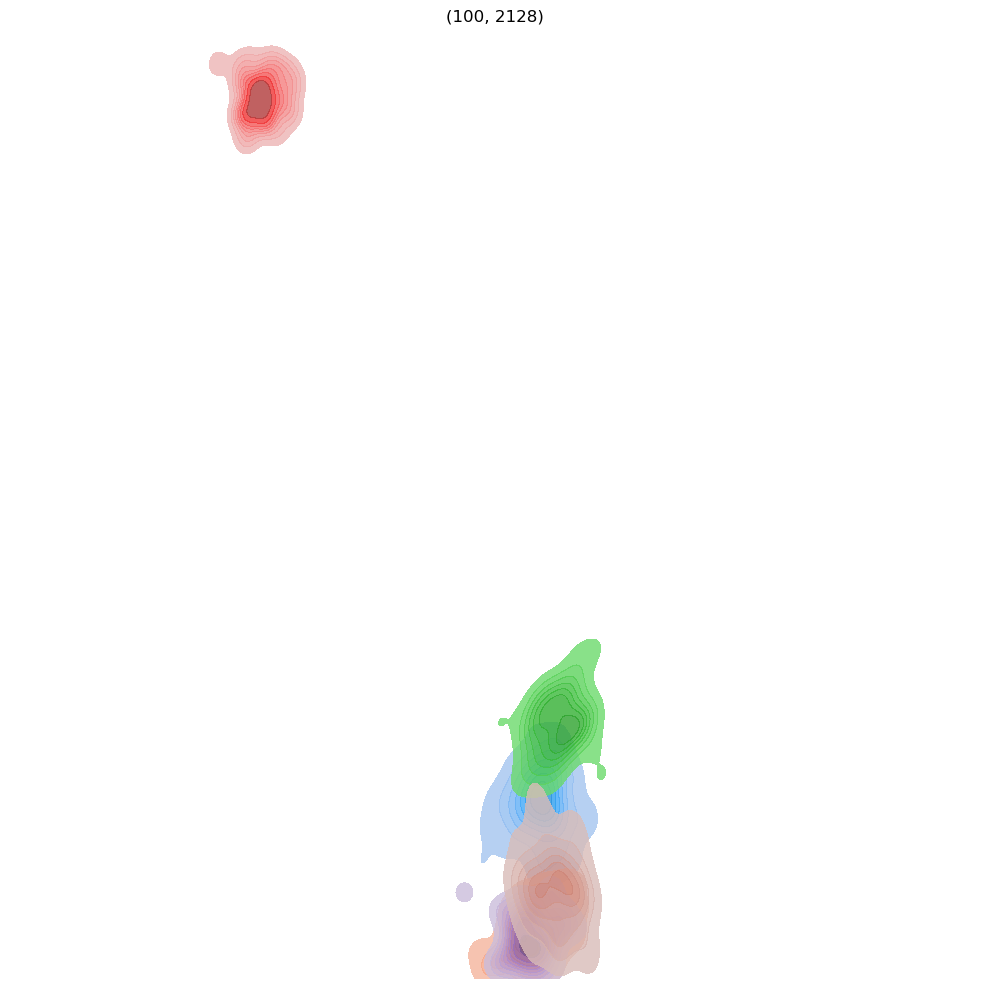

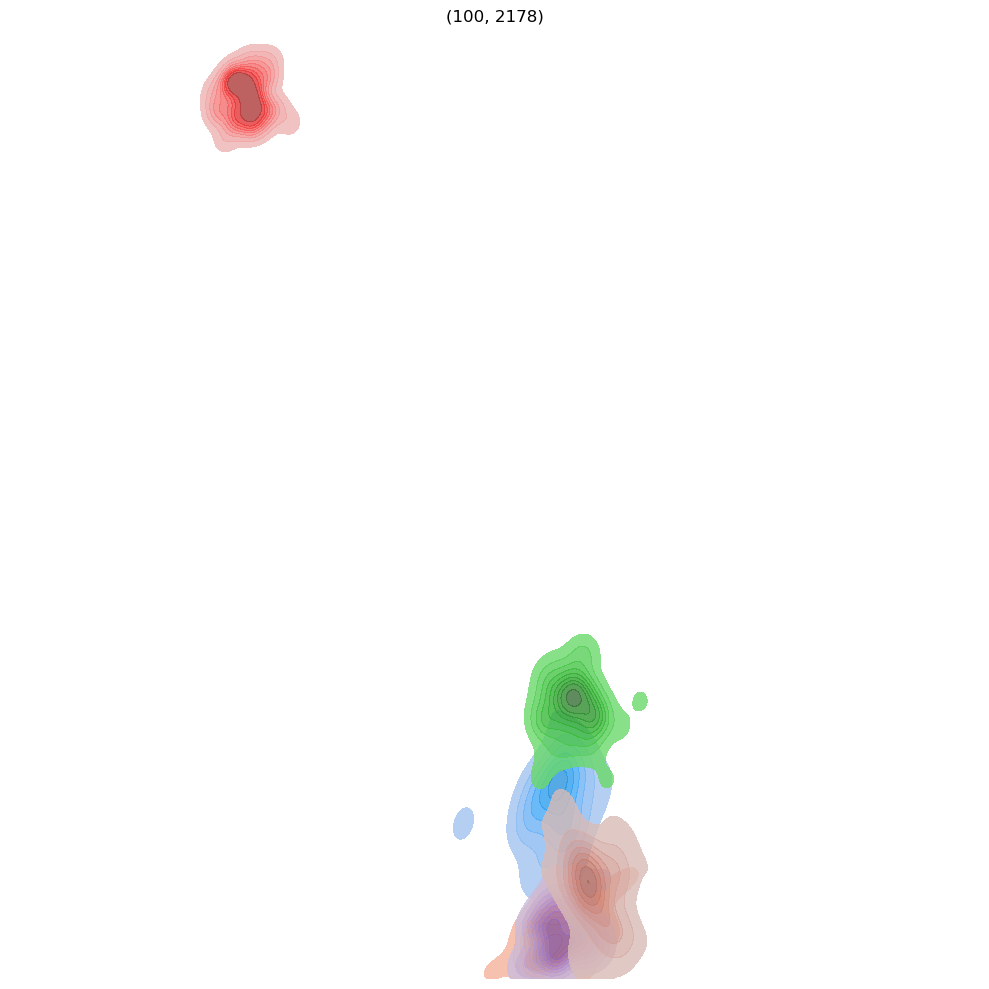

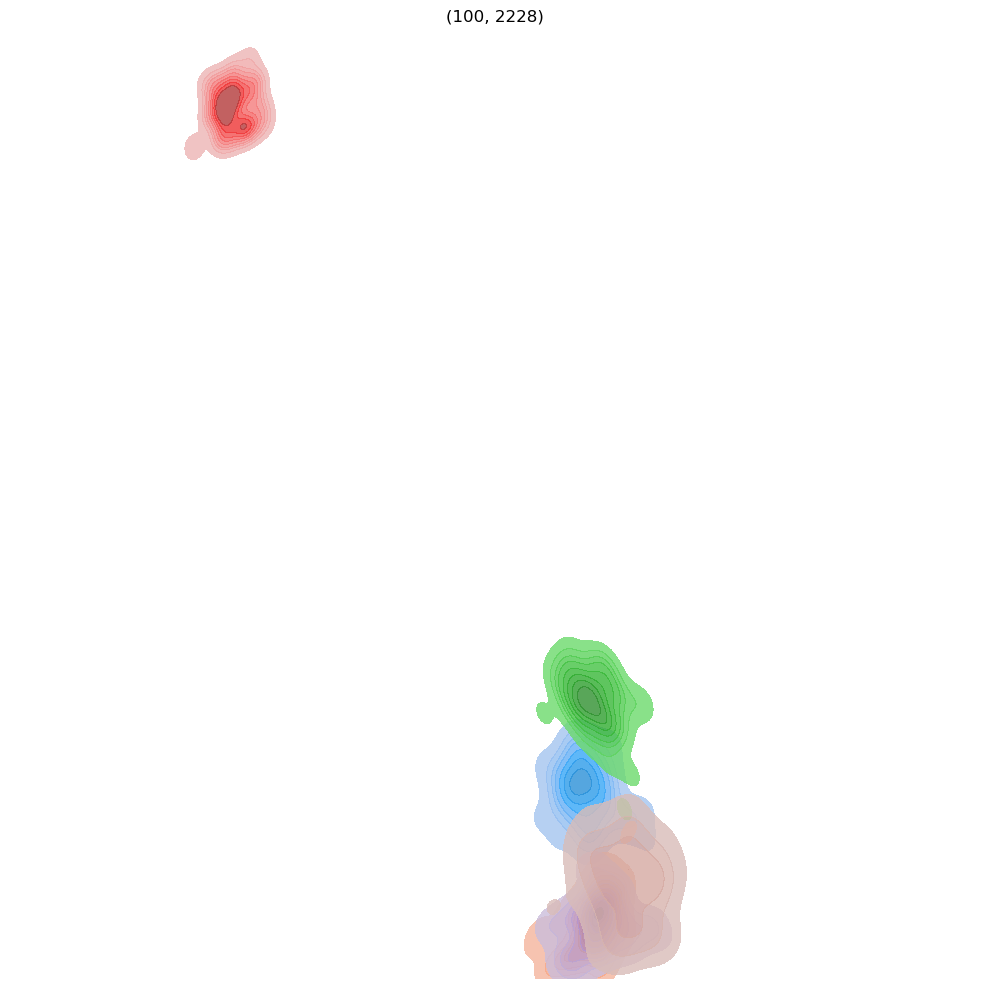

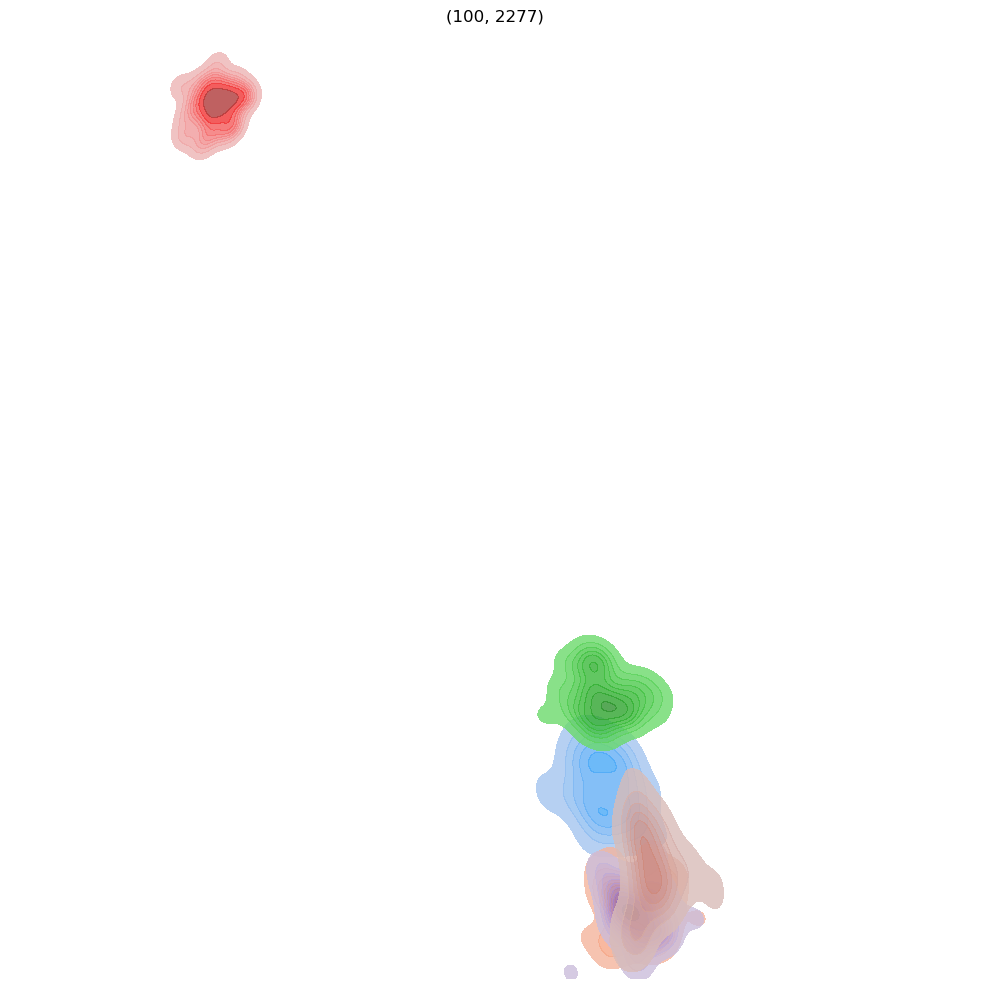

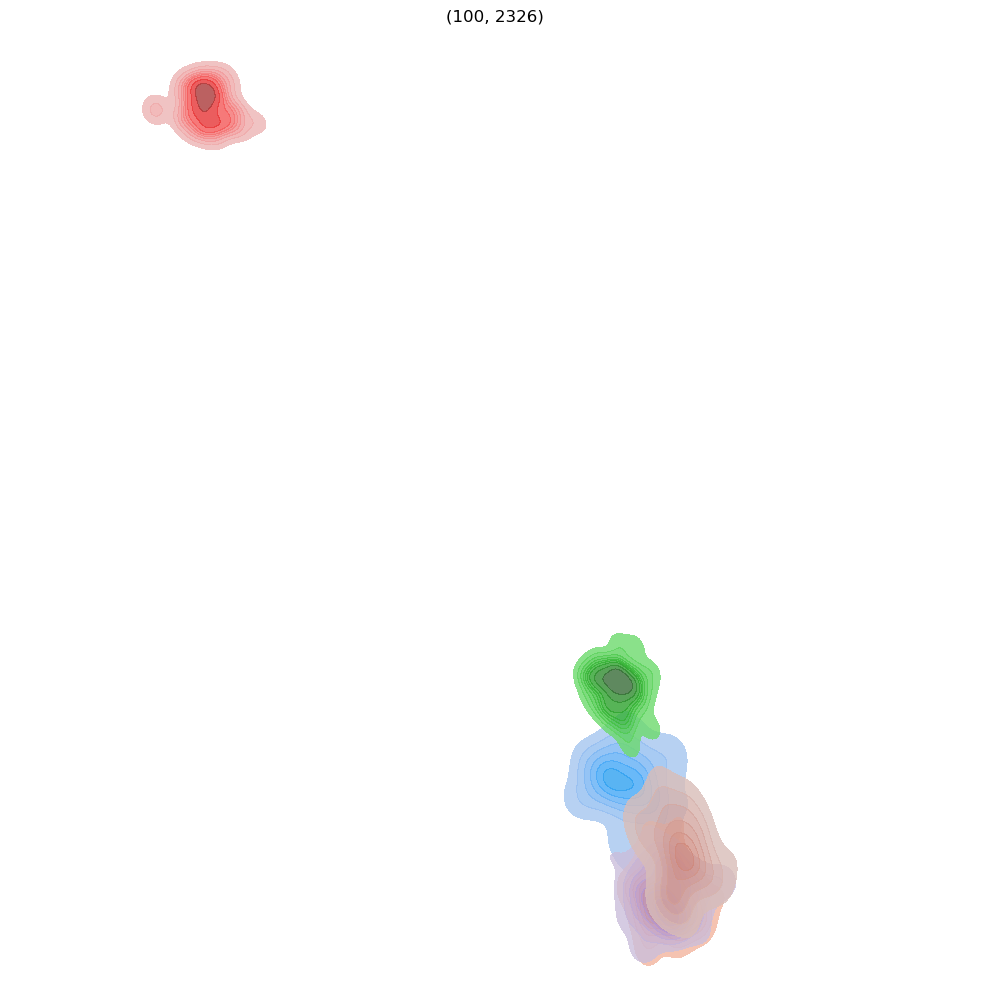

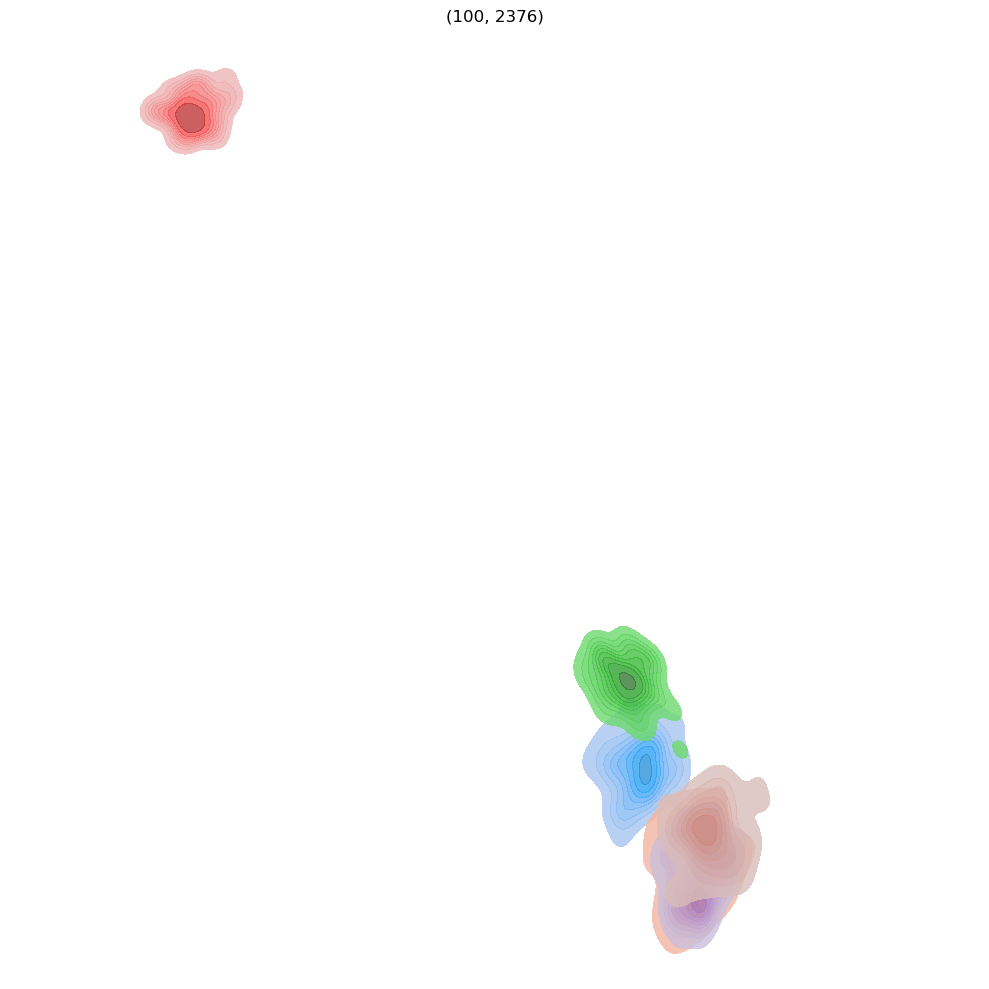

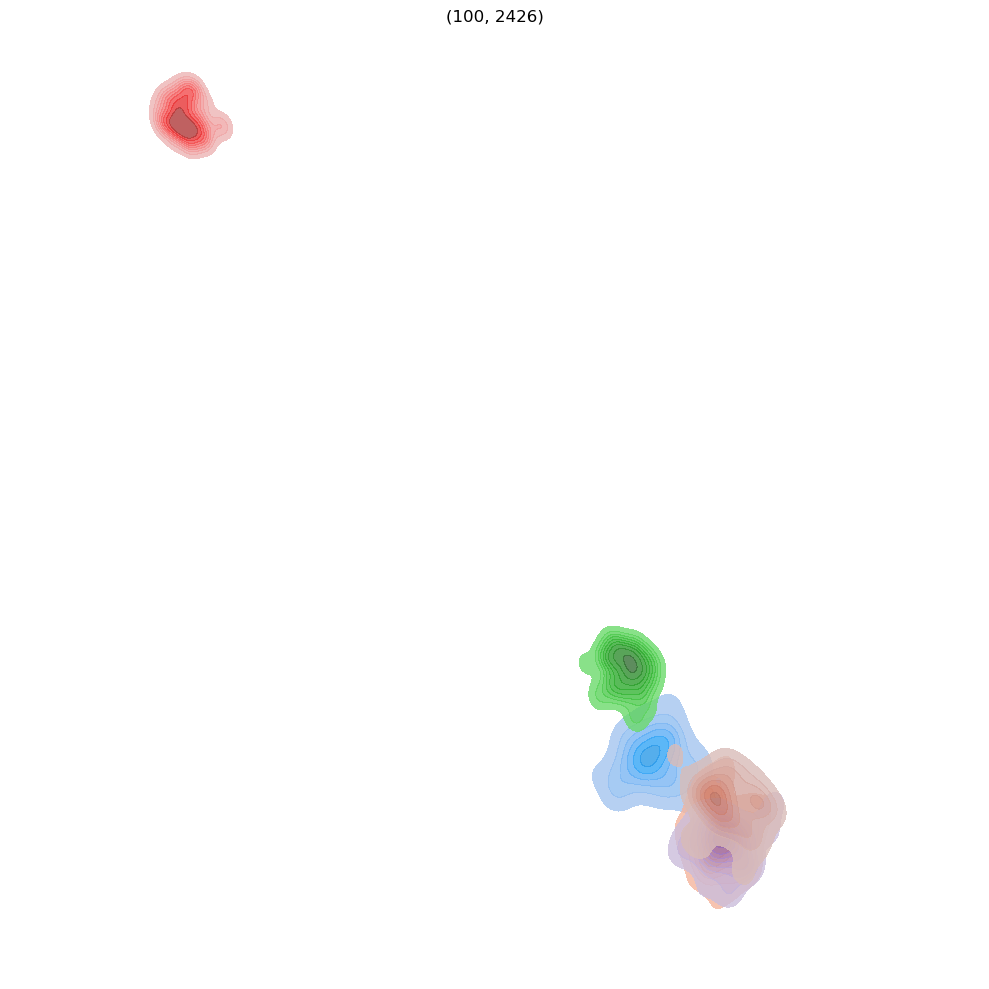

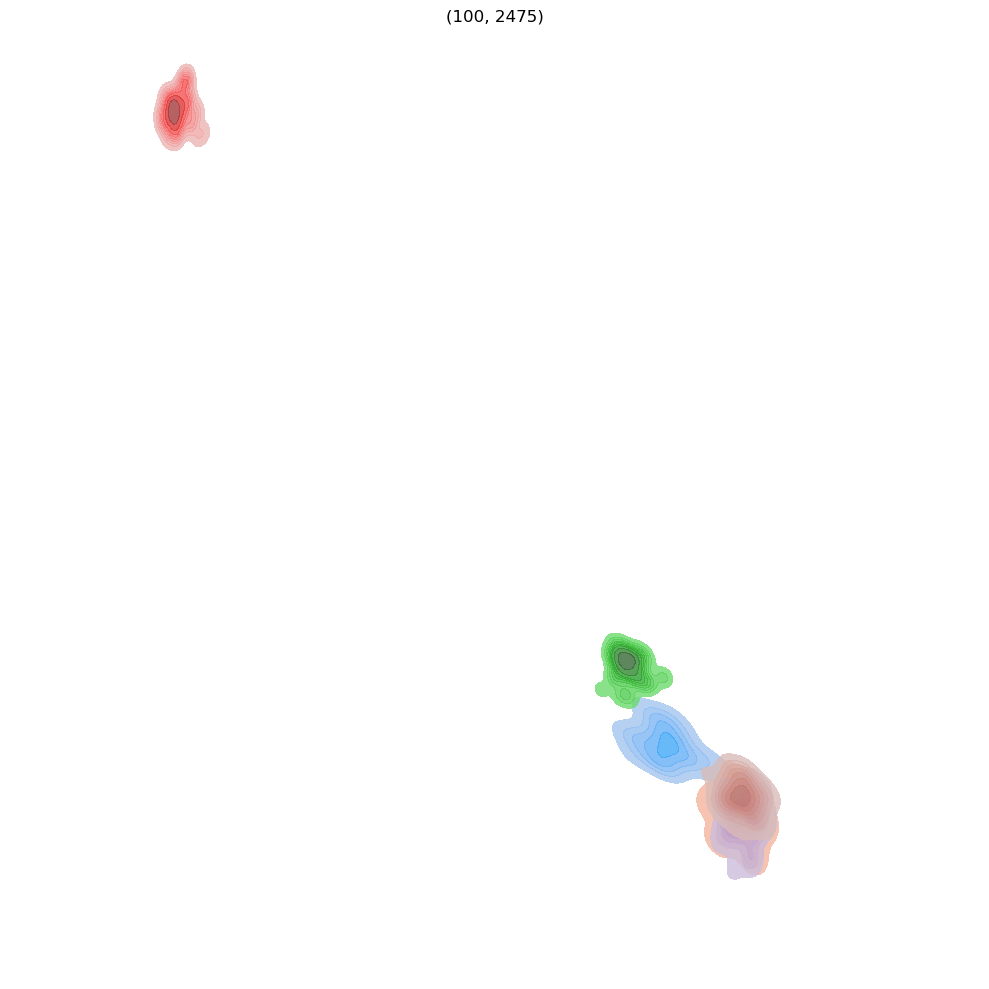

In [190]:
img_save_path = DATA_PATH+"/illustrations/v{vcount}_e{ecount}.png"
gif_save_path = DATA_PATH+"/trad_degs_d_01_50.gif"

do_make_gif = True

make_kde = True

def get_exs(values):
    return np.min(values), np.max(values)

x_min, x_max = get_exs([arg["emb"][0] for arg in netemb.generated_args])
y_min, y_max = get_exs([arg["emb"][1] for arg in netemb.generated_args])

#fig, axes = plt.subplots(nrows=len(ve_values),ncols=1, figsize=(5,5*len(ve_values)))

for i, (k, v) in enumerate(netana.ve_dicts.items()):
    
    fig, axes = plt.subplots(nrows=1,ncols=1, figsize=(10,10))
    
    if make_kde:
        visualise_kde(v
                      , alpha=0.8
                      , legend=i==0
                      #, ax = axes[i]
                      , ax = axes
                      , title=k
                     )
    else:
        visualise_gmm(v
                      #, ax = axes[i]
                      , ax = axes
                     )
    """    
    axes[i].set_xlim([x_min, x_max])
    axes[i].set_ylim([y_min, y_max])
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    axes[i].set_title(k)
    """
    axes.set_xlim([x_min, x_max])
    axes.set_ylim([y_min, y_max])
    
    axes.set_title(k)
    
    axes.set_xticks([])
    axes.set_yticks([])
    axes.set_xlabel("")
    axes.set_ylabel("")
    sns.despine(bottom=True, left=True)

    plt.tight_layout()
    
    if do_make_gif:
        plt.savefig(img_save_path.format(vcount=k[0], ecount=k[1]))

In [191]:
# build gif !!
with imageio.get_writer(gif_save_path, mode='I') as writer:
    for ve in ve_values:
        img_name = img_save_path.format(vcount=ve[0], ecount=ve[1])
        image = imageio.imread(img_name)
        writer.append_data(image)
        
        # Remove files
        os.remove(img_name)

/var/folders/fw/thz6qyfn5373yws3ryp_ktfh0000gn/T/ipykernel_68008/4278238207.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(img_name)


# 🖇 Segregative power assessment 

In [61]:
from space_seg.space_seg_classes import *

%load_ext autoreload
%autoreload 2

gen_fams_dict = {
    "PA": {
        "k": {
            "generator_path": GEN_PATH+"k.gen",
            "number_generated":N_GRAPHS
        }
    },
    "ER": {
        "c1": {
            "generator_path": GEN_PATH+"c1.gen",
            "number_generated":N_GRAPHS
        },
    },
    "ID": {
        "id": {
            "generator_path": GEN_PATH+"id.gen",
            "number_generated":N_GRAPHS
        }
    },
    "PA'": {
        "k^k": {
            "generator_path": GEN_PATH+"k^k.gen",
            "number_generated":N_GRAPHS
        }
    },
    "d": {
        "d": {
            "generator_path": GEN_PATH+"d.gen",
            "number_generated":N_GRAPHS
        }
    },
    "SC": {
        "SC-a": {
            "generator_path": GEN_PATH+"sc-a2.gen",
            "number_generated":N_GRAPHS
        }
    },
    "SF": {
        "SF": {
            "generator_path": GEN_PATH+"e-d.gen",
            "number_generated":N_GRAPHS
        }
    }
}
"""

gen_fams_dict = {
    # Canonical
    "PA": {
        "k": {
            "generator_path": GEN_PATH+"k.gen",
            "number_generated":N_GRAPHS
        }
    },
    "ER": {
        "c1": {
            "generator_path": GEN_PATH+"c1.gen",
            "number_generated":N_GRAPHS
        },
    },
    "ID": {
        "id": {
            "generator_path": GEN_PATH+"id.gen",
            "number_generated":N_GRAPHS
        }
    },
    "d": {
        "d": {
            "generator_path": GEN_PATH+"d.gen",
            "number_generated":N_GRAPHS
        }
    },
    
    # 2014 — undirected
    "PG": {
        "grid": {
            "generator_path": GEN_PATH+"power_grid.gen",
            "number_generated":N_GRAPHS
        }
    },
    "FB": {
        "fb": {
            "generator_path": GEN_PATH+"facebook.gen",
            "number_generated":N_GRAPHS
        }
    },
    "P": {
        "prot": {
            "generator_path": GEN_PATH+"proteins.gen",
            "number_generated":N_GRAPHS
        }
    },
    "WA": {
        "word": {
            "generator_path": GEN_PATH+"words.gen",
            "number_generated":N_GRAPHS
        }
    },
}
"""
generated_nodes = np.arange(100, 1100, 100)[:4]
generated_densities = np.linspace(0.001, 0.2, 10)

MIN_AV_DEG = 5
MAX_AV_DEG = 200

print(generated_nodes)
print(generated_densities)

ve_values = [
    (v, e)  
    for v in generated_nodes
    for e in numbers_of_edges(v
                              , densities = generated_densities
                             )
    if (
        coherent_max_edges(nodes=v, edges=e)
        and av_deg(v, e) >= MIN_AV_DEG
        and av_deg(v, e) <= MAX_AV_DEG
    )
]


netgen = SynNetsGenerator(
    generator_dict=gen_fams_dict,
    ve_pairs_list=ve_values,
    compute_files=False, # SET To ` True ` to generate the network files
    do_overwrite = False,
)


embmeth = load_embedder(
    "DL_module/saved/best_models/GraphMAE_GCNversion_o64/"
    #"DL_module/saved/best_models/trad_degs/"
)

netemb = netgen.make_embedder(
    **{
        #"embedding_method": lambda net: emb_degs(net, **{"bins":bins, "range":(0,max_val)}),
        "embedding_method": lambda net: embed_deep(net, embedder_method=embmeth),
        #"reducer": TSNE()#PCA(n_components=2)
    }
)

netana = netemb.make_analyzer()

print("Done\nReady for experiments.")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[100 200 300 400]
[0.001      0.02311111 0.04522222 0.06733333 0.08944444 0.11155556
 0.13366667 0.15577778 0.17788889 0.2       ]
Done
Ready for experiments.


In [62]:
netana.ve_dicts.keys()

dict_keys([(100, 333), (100, 443), (100, 552), (100, 662), (100, 771), (100, 881), (100, 990), (200, 900), (200, 1340), (200, 1780), (200, 2220), (200, 2660), (200, 3100), (200, 3540), (200, 3980), (300, 1037), (300, 2028), (300, 3020), (300, 4012), (300, 5003), (300, 5995), (300, 6987), (300, 7978), (300, 8970), (400, 1844), (400, 3609), (400, 5373), (400, 7138), (400, 8902), (400, 10667), (400, 12431), (400, 14196), (400, 15960)])

In [63]:
len(netana.ve_dicts[(100, 990)]["embs"]), len(netana.ve_dicts[(100, 990)]["labels"])

(448, 448)

In [64]:
len(test_ve_dict1["embs"])

256

/Users/nmm/miniforge3/envs/env_gdl/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/nmm/miniforge3/envs/env_gdl/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Text(0.5, 1.0, '(100, 990)')

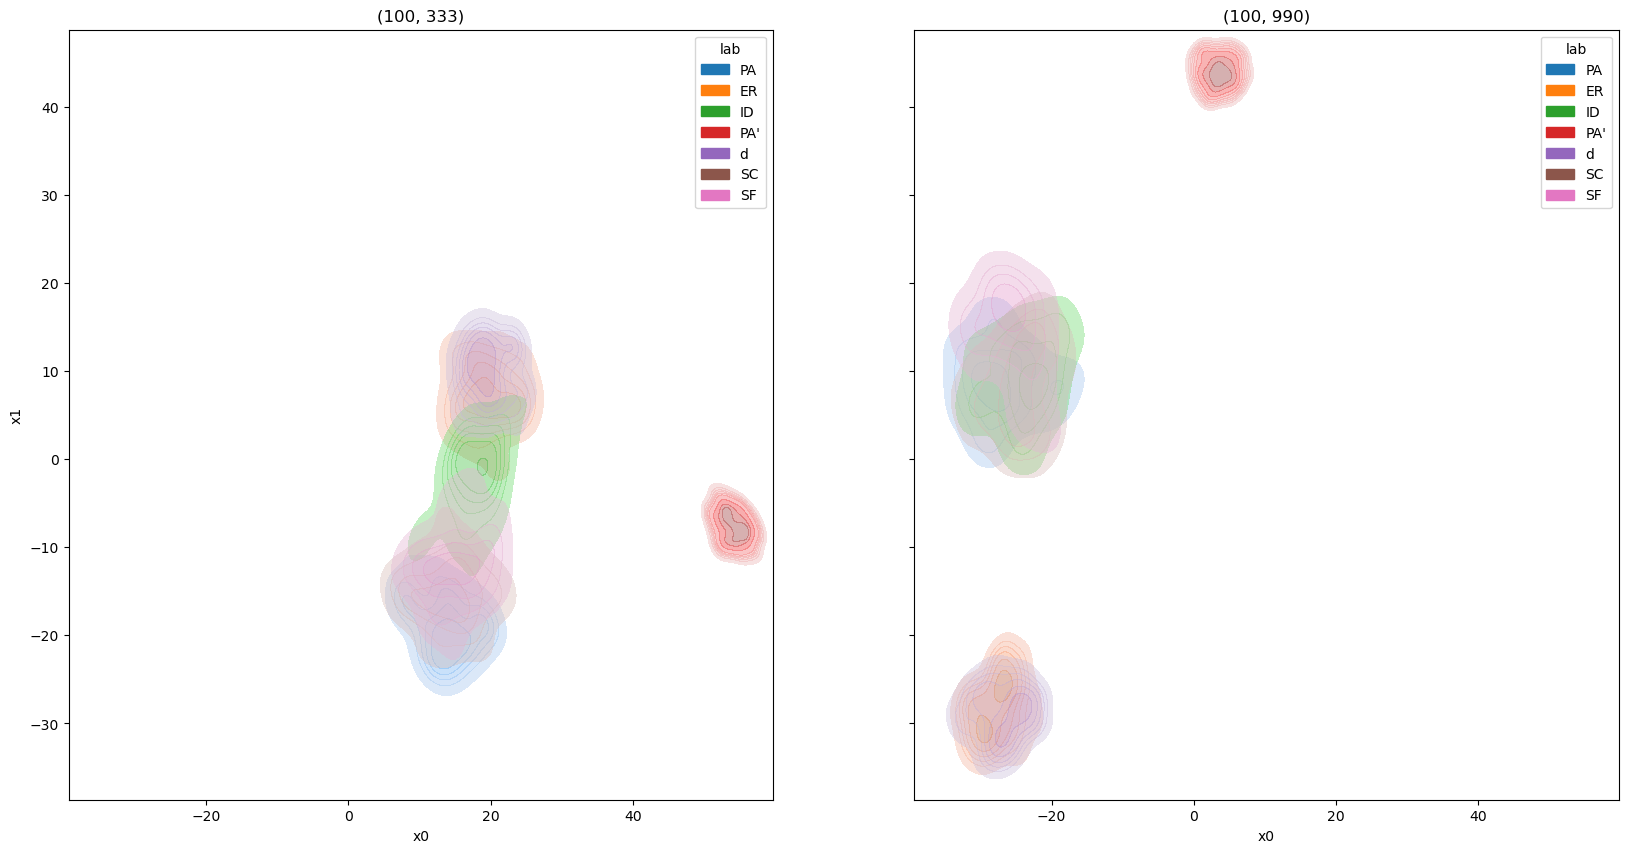

In [65]:
test_n = 100

sparsity_1 = 0.06733333#0.11155556#
sparsity_2 = 0.2

test_n1, test_m1 = test_n, numbers_of_edges(test_n, [sparsity_1])[0]
test_n2, test_m2 = test_n, numbers_of_edges(test_n, [sparsity_2])[0]

test_ve_dict1 = netana.ve_dicts[(test_n1, test_m1)].copy()
test_ve_dict2 = netana.ve_dicts[(test_n2, test_m2)].copy()

if len(test_ve_dict1["embs"][0]) > 2:
    n_graphs = len(test_ve_dict1["embs"])
    
    embs = np.array(list(test_ve_dict1["embs"])+list(test_ve_dict2["embs"]))
    
    reducer = TSNE()
    reduced_embs = reducer.fit_transform(embs)
    
    test_ve_dict1["embs"] = reduced_embs[:n_graphs]
    test_ve_dict2["embs"] = reduced_embs[n_graphs:]
    
                   
fig, ax = plt.subplots(nrows=1, ncols=2
                       , figsize=(20,10)
                       , sharex=True, sharey=True
                      )

visualise_kde(
    ve_dict= test_ve_dict1,
    ax = ax[0],
    title = (test_n, test_m),
    legend=True,
    alpha=0.4,
)
ax[0].set_title('({}, {})'.format(test_n1, test_m1))
                   
visualise_kde(
    ve_dict= test_ve_dict2,
    ax = ax[1],
    title = (test_n, test_m),
    legend=True,
    alpha=0.4,
)
ax[1].set_title('({}, {})'.format(test_n2, test_m2))

## Init

In [66]:
from space_seg.helpers_stats import *
from sklearn import metrics

In [67]:
def pairwise_silhouette(x, y): # same format as KLdivergence
    # Check the dimensions are consistent
    x = np.atleast_2d(x)
    y = np.atleast_2d(y)

    n,d = x.shape
    m,dy = y.shape

    assert(d == dy)
    # ===================================
    
    xy_array = np.array(list(x)+list(y))
    proxy_labels = np.array([0]*len(x)+[1]*len(y))
    
    return metrics.silhouette_score(xy_array, proxy_labels)

In [68]:
pairwise_measure = pairwise_silhouette
#pairwise_measure = KLdivergence

In [69]:
overall_measure = metrics.silhouette_score
#overall_measure = mean_KLdivergence

## Computing scores

In [70]:
families = np.unique(netana.ve_dicts[(100, 333)]["labels"])

In [71]:
for k, v in netana.ve_dicts.items():
    # compute overall score:
    v["overall_score"] = overall_measure(v["embs"], v["labels"])
    
    # compute pairwise scores:
    pairwise_dict = {fam: None for fam in families}
    for curr_fam in families:
        curr_fam_dict = {}
        curr_fam_embs = np.array([e for e, f in zip(v["embs"], v["labels"]) 
                                  if f == curr_fam
                                 ]
                                )
        for other_fam in families:
            if other_fam == curr_fam:
                pass
            else:
                other_fam_embs = np.array([e for e, f in zip(v["embs"], v["labels"]) 
                                           if f == other_fam
                                          ]
                                         )
                curr_fam_dict[other_fam] = pairwise_measure(curr_fam_embs, other_fam_embs)
        
        pairwise_dict[curr_fam] = curr_fam_dict
        
    v["pairwise_scores"] = pairwise_dict

## Retrieve and analyse

## Overall

In [72]:
import seaborn as sns

In [73]:
overall_scores = [
    [
        netana.ve_dicts[(n, numbers_of_edges(n, densities = [p])[0])]["overall_score"]
        if (
            av_deg(n, numbers_of_edges(n, densities = [p])[0]) > MIN_AV_DEG
            and av_deg(n, numbers_of_edges(n, densities = [p])[0]) < MAX_AV_DEG
        )
        else np.NaN
        for p in generated_densities
    ]
    for n in generated_nodes
]

[Text(0.5, 23.52222222222222, 'Sparsity'),
 Text(50.722222222222214, 0.5, 'Nodes')]

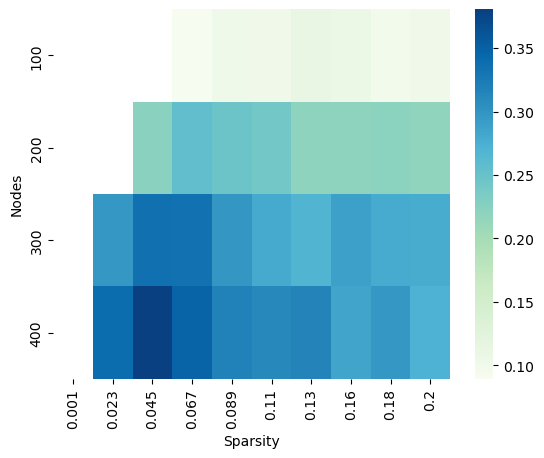

In [88]:
yticklabels = generated_nodes
xticklabels = ['{:.2g}'.format(p) for p in generated_densities]

s = sns.heatmap(
    overall_scores,
    #vmin=0, vmax=1,
    cmap="GnBu",
    yticklabels=yticklabels,
    xticklabels=xticklabels
)

s.set(xlabel='Sparsity', ylabel='Nodes')

### Pairwise

In [748]:
fam = "ER"

In [749]:
fam_dict = {ve: None for ve in netana.ve_dicts.keys()}

for k, v in netana.ve_dicts.items():
    fam_dict[k] = v["pairwise_scores"][fam]

#### 1-D : given n and fam

In [750]:
n_analyze = 100

In [751]:
fam_dict_n = {k:v for k, v in fam_dict.items() if k[0]==n_analyze}

n_edges = [k[1] for k in fam_dict_n.keys()]

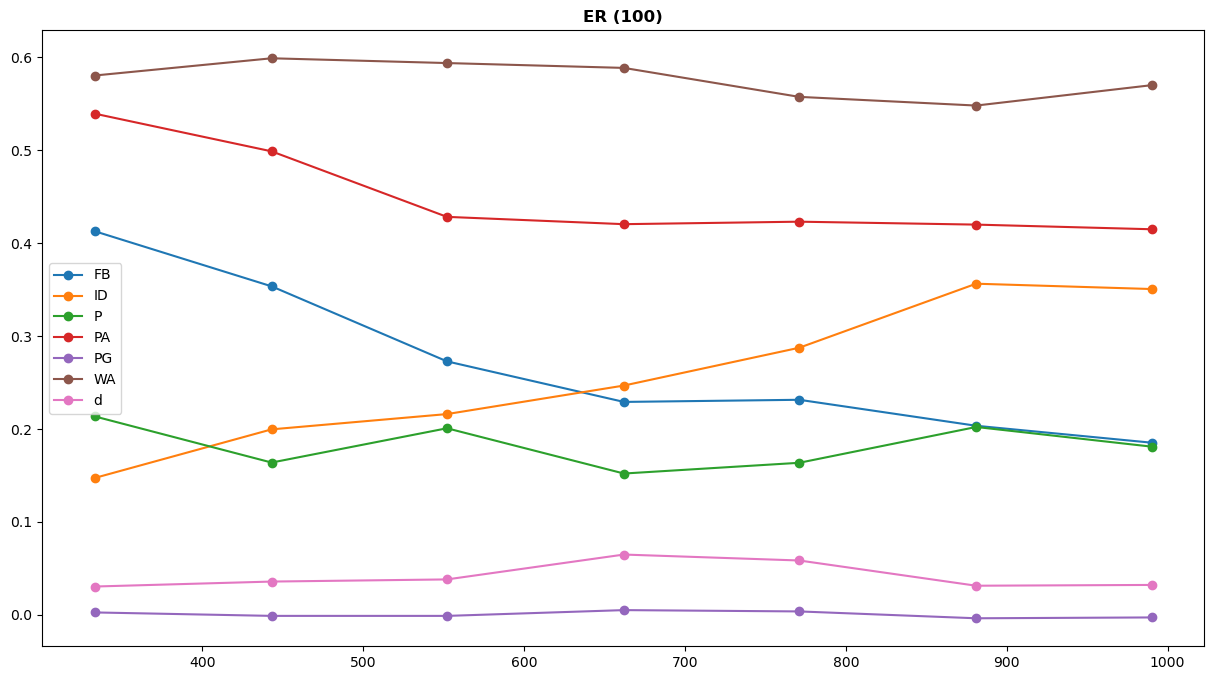

In [752]:
other_fams = fam_dict_n[(n_analyze, n_edges[0])]

fig, ax = plt.subplots(figsize=(15, 8))

for f in other_fams:
    ax.plot(
        n_edges,
        [v[f] for v in fam_dict_n.values()],
        marker = 'o',
        label = f,
    )

plt.title("{} ({})".format(fam, n_analyze)
          , fontweight="semibold"
         )
plt.legend()
plt.show()

#### 1-D : $\forall$ n, $\forall$ fams

In [754]:
fams = np.unique(netana.ve_dicts[list(netana.ve_dicts.keys())[0]]["labels"])
n_nodes = np.unique([ve[0] for ve in netana.ve_dicts.keys()])

nb_fams = len(fams)
nb_nodes_gen = len(n_nodes)

In [755]:
fams

array(['ER', 'FB', 'ID', 'P', 'PA', 'PG', 'WA', 'd'], dtype='<U2')

In [756]:
fam2color_dict = {
    "PA": 'blue',
    "ER": 'orange',
    "ID": 'green',
    "d": 'purple',
    
    "SC": 'brown',
    "SF": 'pink',
    "PA'": 'red',
    
    "FB":"darkblue",
    "P":"lightcoral",
    "PG":"limegreen",
    "WA":'grey',
}

In [757]:
def edges_to_sparsity(
    nb_nodes,
    edges_list
):
    Me = max_possible_edges(nb_nodes)
    ps = [nb_edges/Me for nb_edges in edges_list]
    
    return ps 

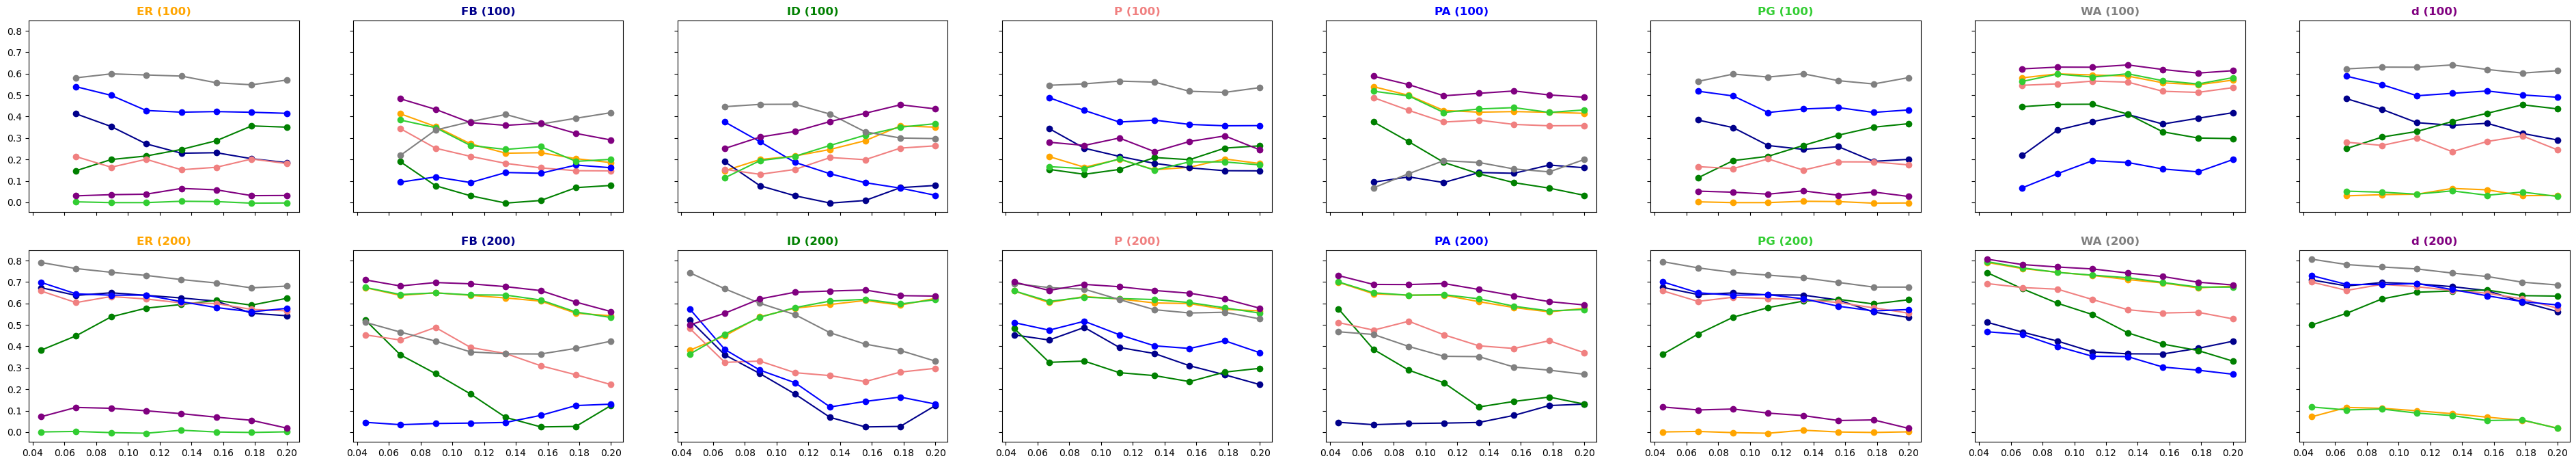

In [763]:
plot_sparsities = True

fig, ax = plt.subplots(figsize= (6*nb_fams, 4*nb_nodes_gen)
                       , nrows=nb_nodes_gen
                       , ncols=nb_fams
                       , sharey=True
                       , sharex=plot_sparsities
                      )

for j, fam in enumerate(fams):
    fam_dict = {ve: None for ve in netana.ve_dicts.keys()}
    for k, v in netana.ve_dicts.items():
        fam_dict[k] = v["pairwise_scores"][fam]

    other_fams = list(fam_dict[list(fam_dict.keys())[0]].keys())

    for k, v in netana.ve_dicts.items():
        fam_dict[k] = v["pairwise_scores"][fam]
        
    for i, nc in enumerate(n_nodes):
        
        fam_dict_nc = {k:v for k, v in fam_dict.items() if k[0]==nc}
        n_edges = [k[1] for k in fam_dict_nc.keys()]
        sparsities = edges_to_sparsity(nc, n_edges)
        
        for f in other_fams:
            
            ax[i,j].plot(
                sparsities if plot_sparsities else n_edges,
                [fam_dict_nc[(nc, ne)][f] for ne in n_edges],
                marker = 'o',
                label = f,
                c=fam2color_dict[f],
            )
            
        ax[i,j].set_title("{} ({})".format(fam, nc)
                          , fontweight="semibold"
                          , c=fam2color_dict[fam]
                         )

#### Heatmap per families-pair

In [759]:
fams = np.unique(netana.ve_dicts[list(netana.ve_dicts.keys())[0]]["labels"])
nb_fams = len(fams)

In [760]:
fams

array(['ER', 'FB', 'ID', 'P', 'PA', 'PG', 'WA', 'd'], dtype='<U2')

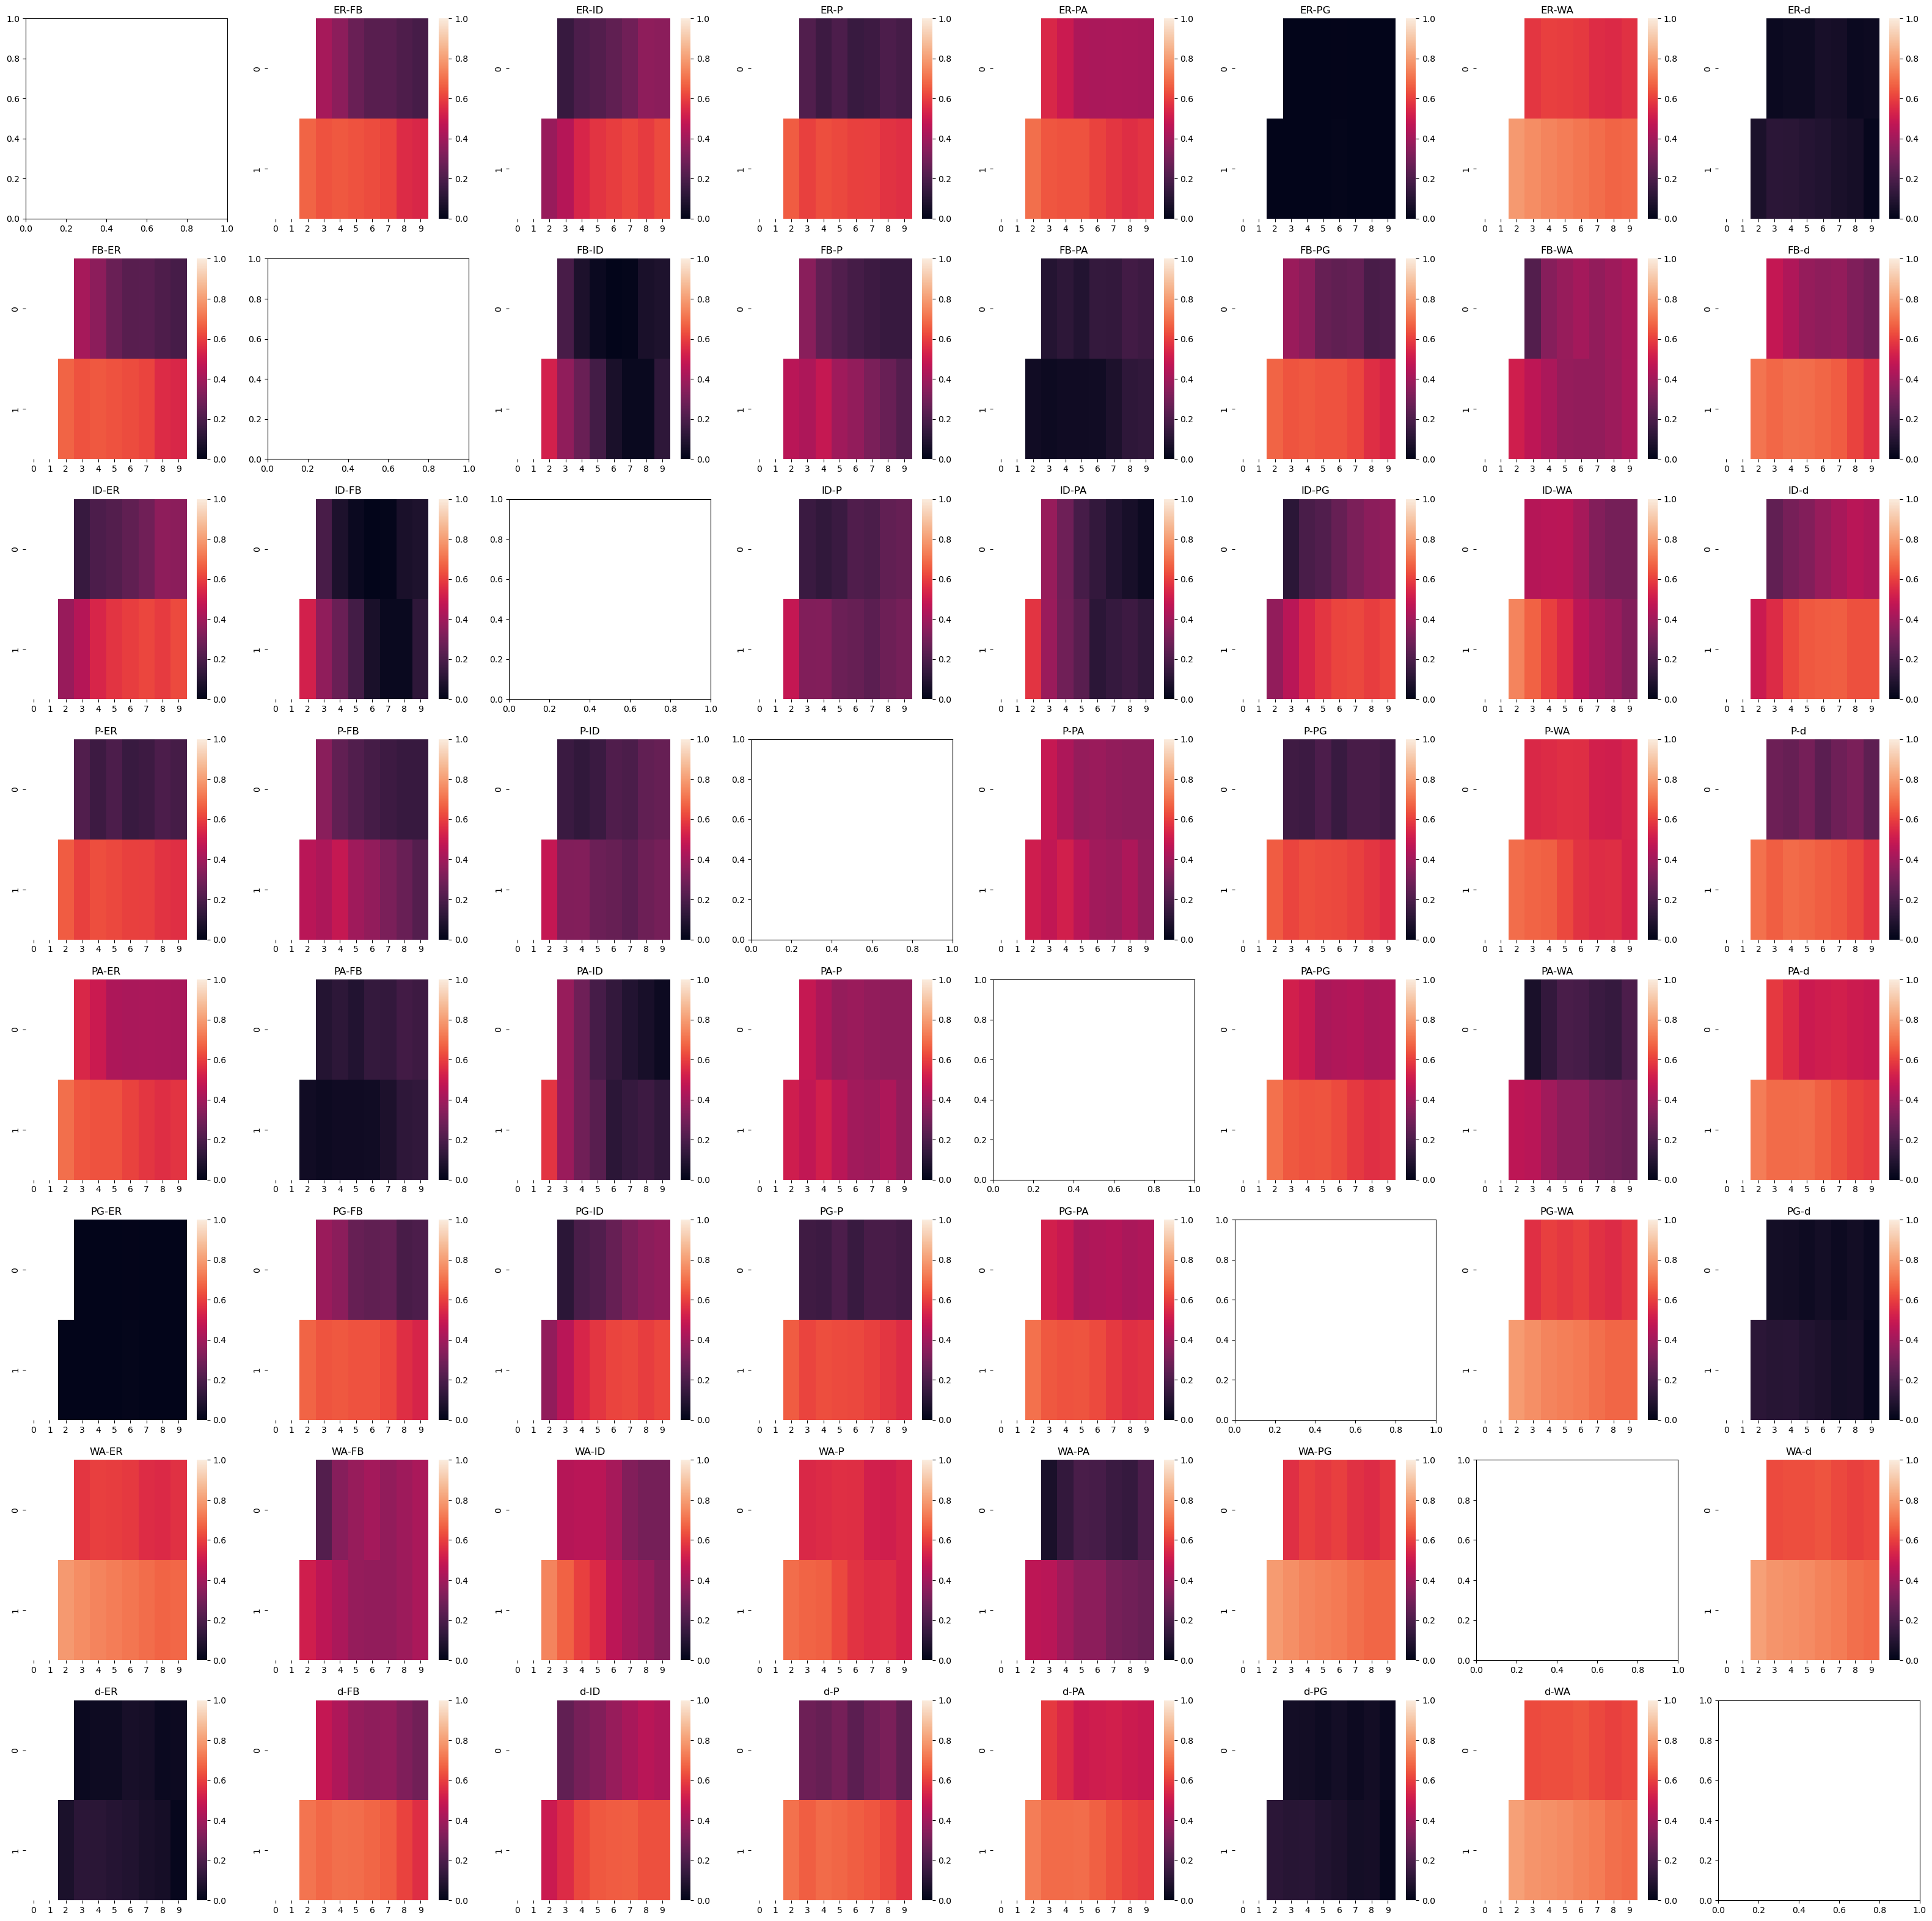

In [761]:
fig, ax = plt.subplots(figsize=(5*nb_fams,5*nb_fams)
                       , nrows=nb_fams, ncols=nb_fams
                      )

for i, fam in enumerate(fams):
    for j, other_fam in enumerate(fams):
        if other_fam == fam:
            pass
        else:
            
            fam_scores = [
                [
                    netana.ve_dicts[(n, numbers_of_edges(n, densities = [p])[0])]["pairwise_scores"][fam][other_fam]
                    if (
                        av_deg(n, numbers_of_edges(n, densities = [p])[0]) > MIN_AV_DEG
                        and av_deg(n, numbers_of_edges(n, densities = [p])[0]) < MAX_AV_DEG
                    )
                    else np.NaN
                    for p in generated_densities
                ]
                for n in generated_nodes
            ]
            
            sns.heatmap(
                fam_scores,
                ax=ax[i,j],
                vmin=0, vmax=1,
            )
            
            ax[i,j].set_title('{}-{}'.format(fam, other_fam))
            

# 🩺 Loss analysis

In [6]:
from reproducibility import loss_analysis
from reproducibility.utils import retrieve_best_runs

## Trad

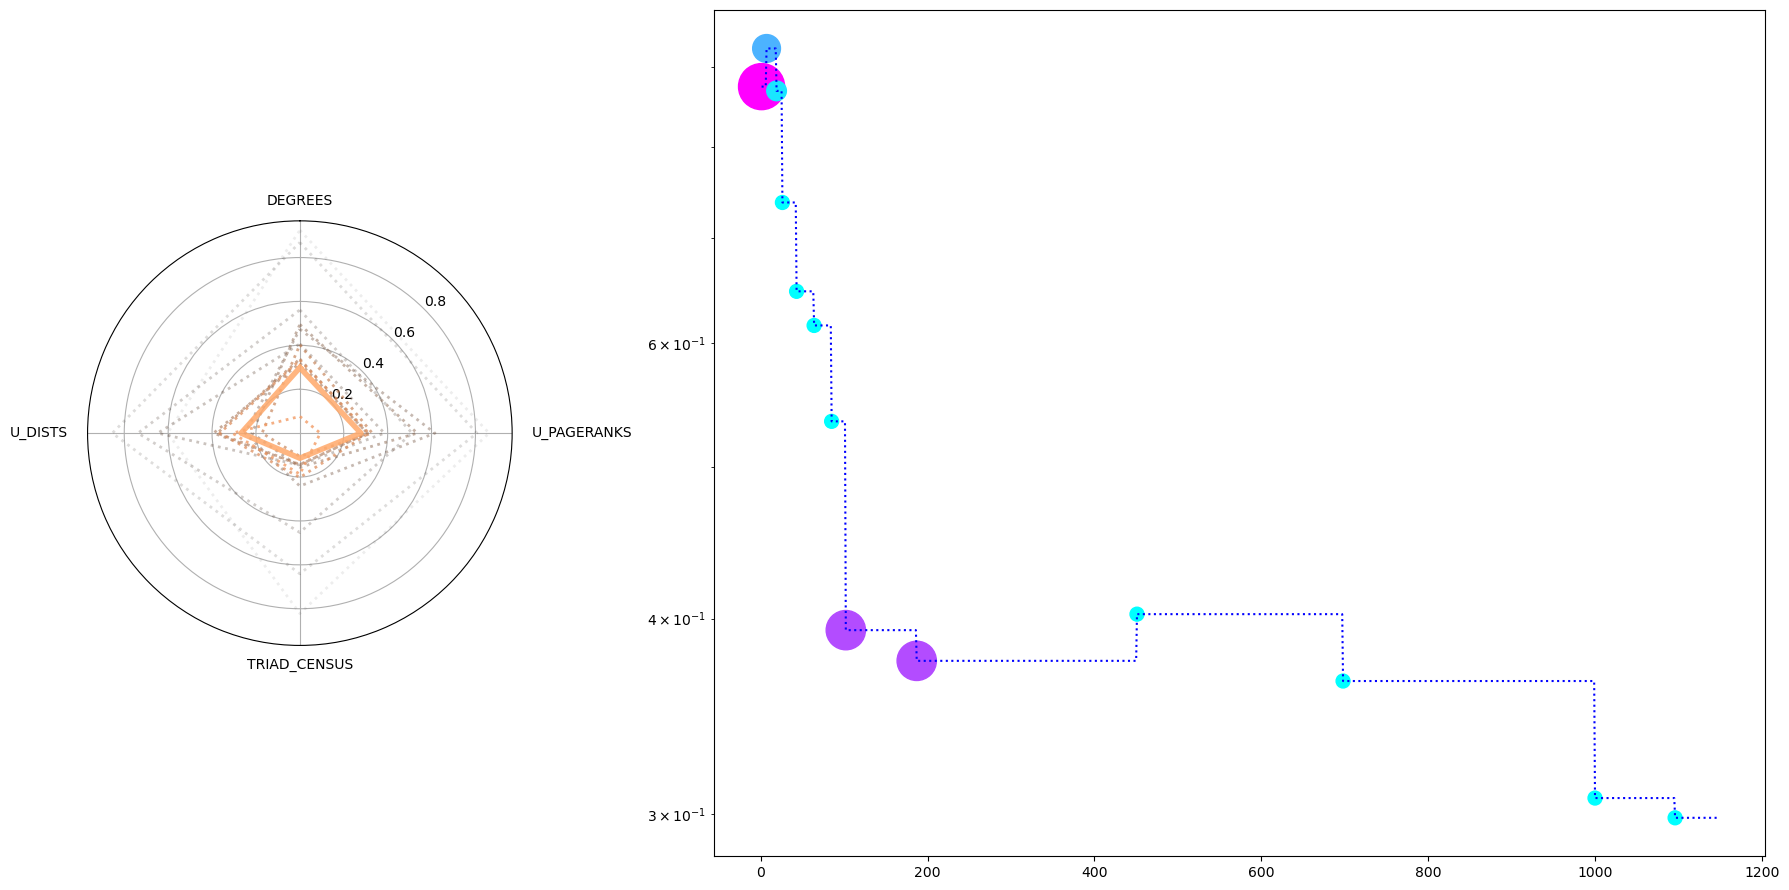

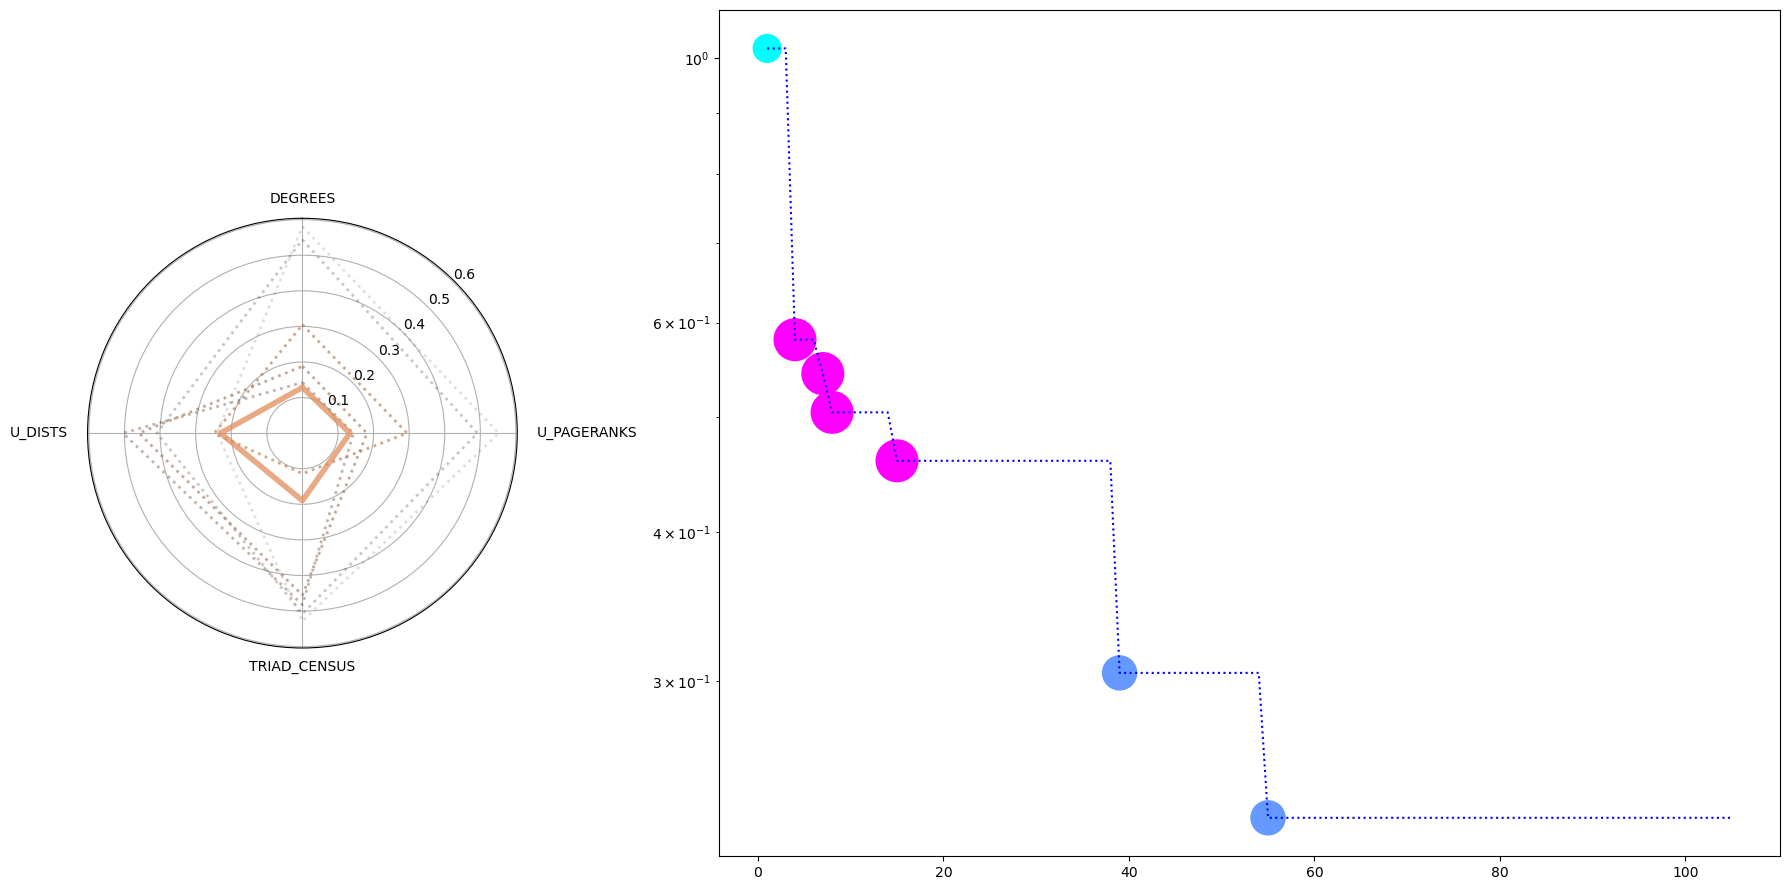

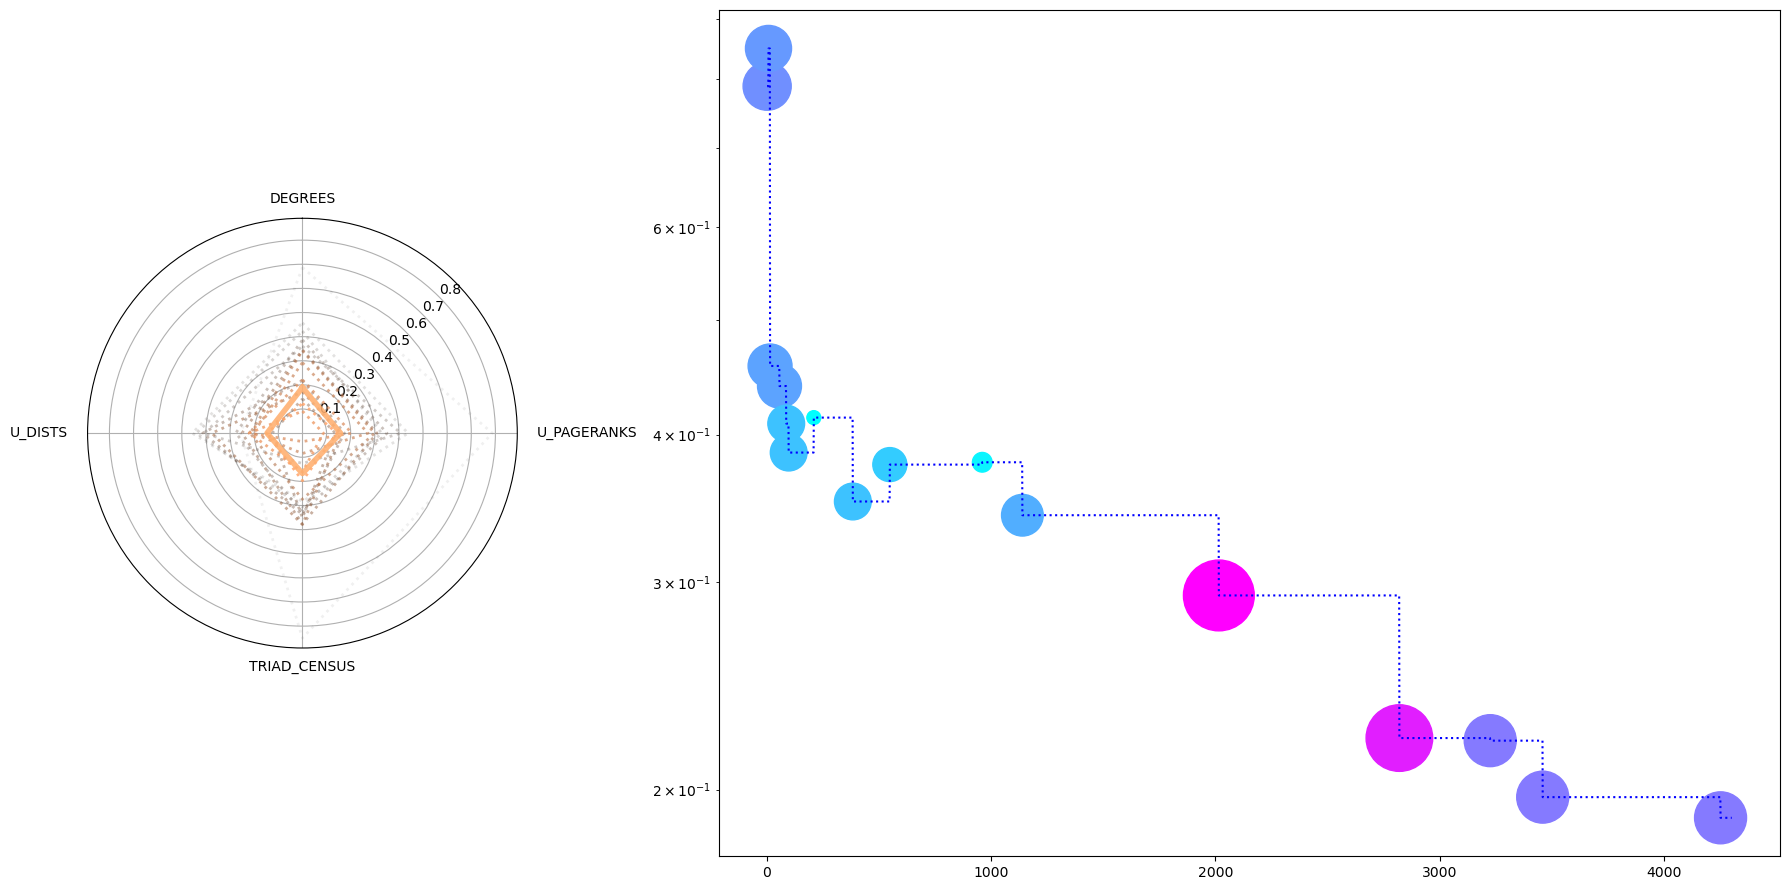

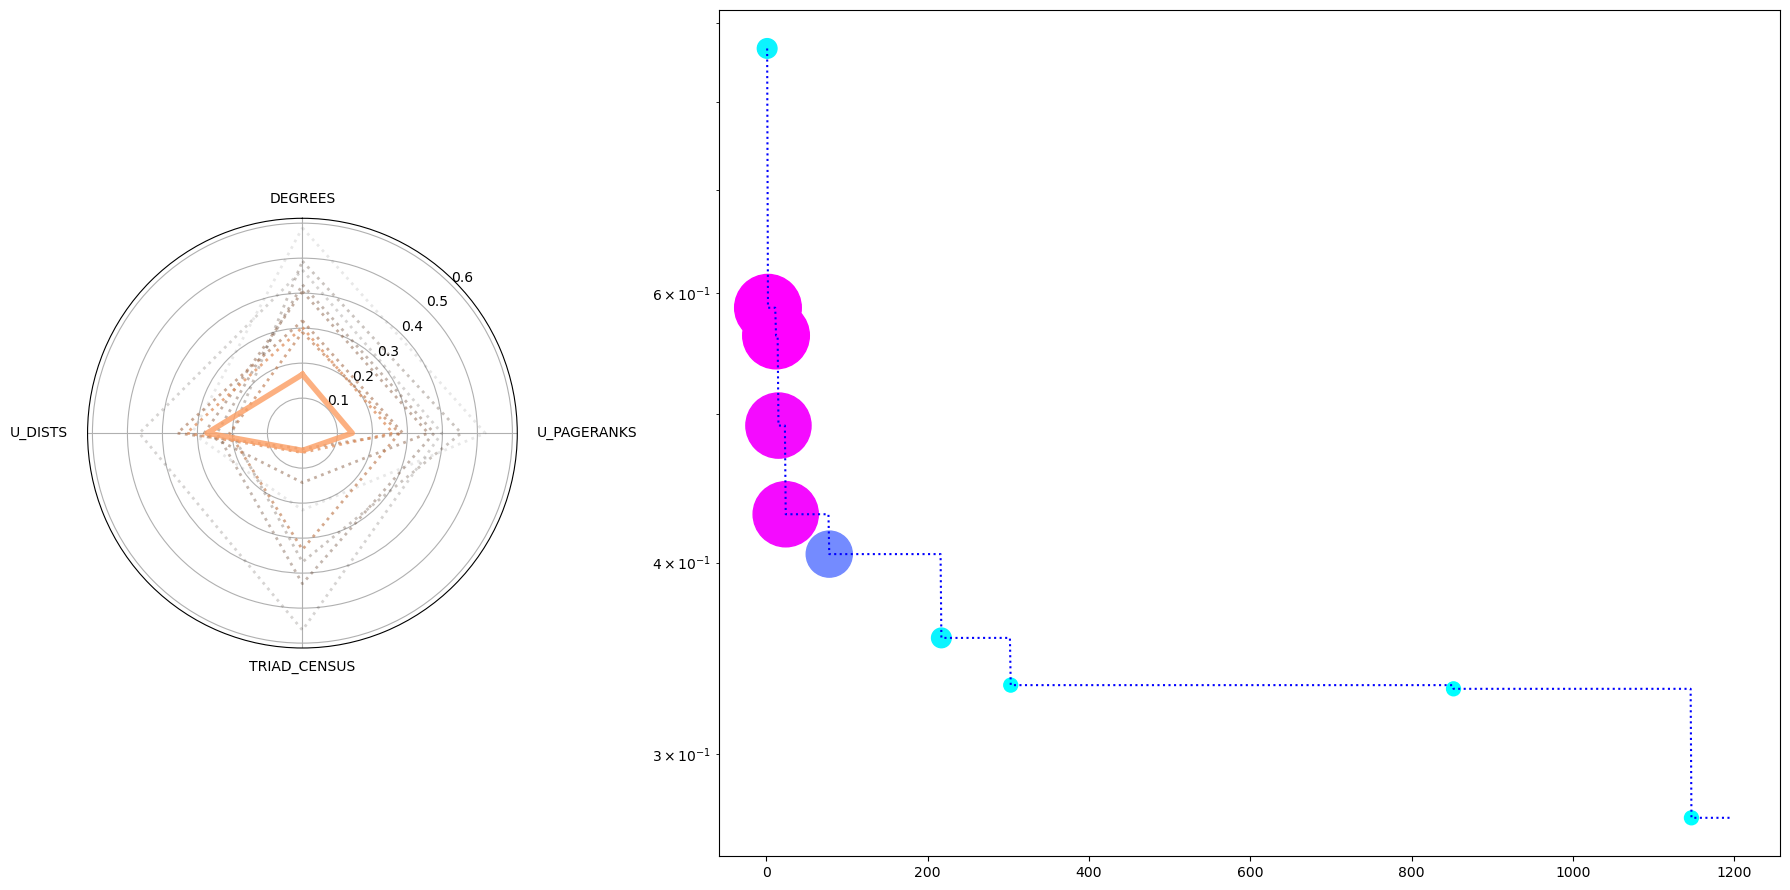

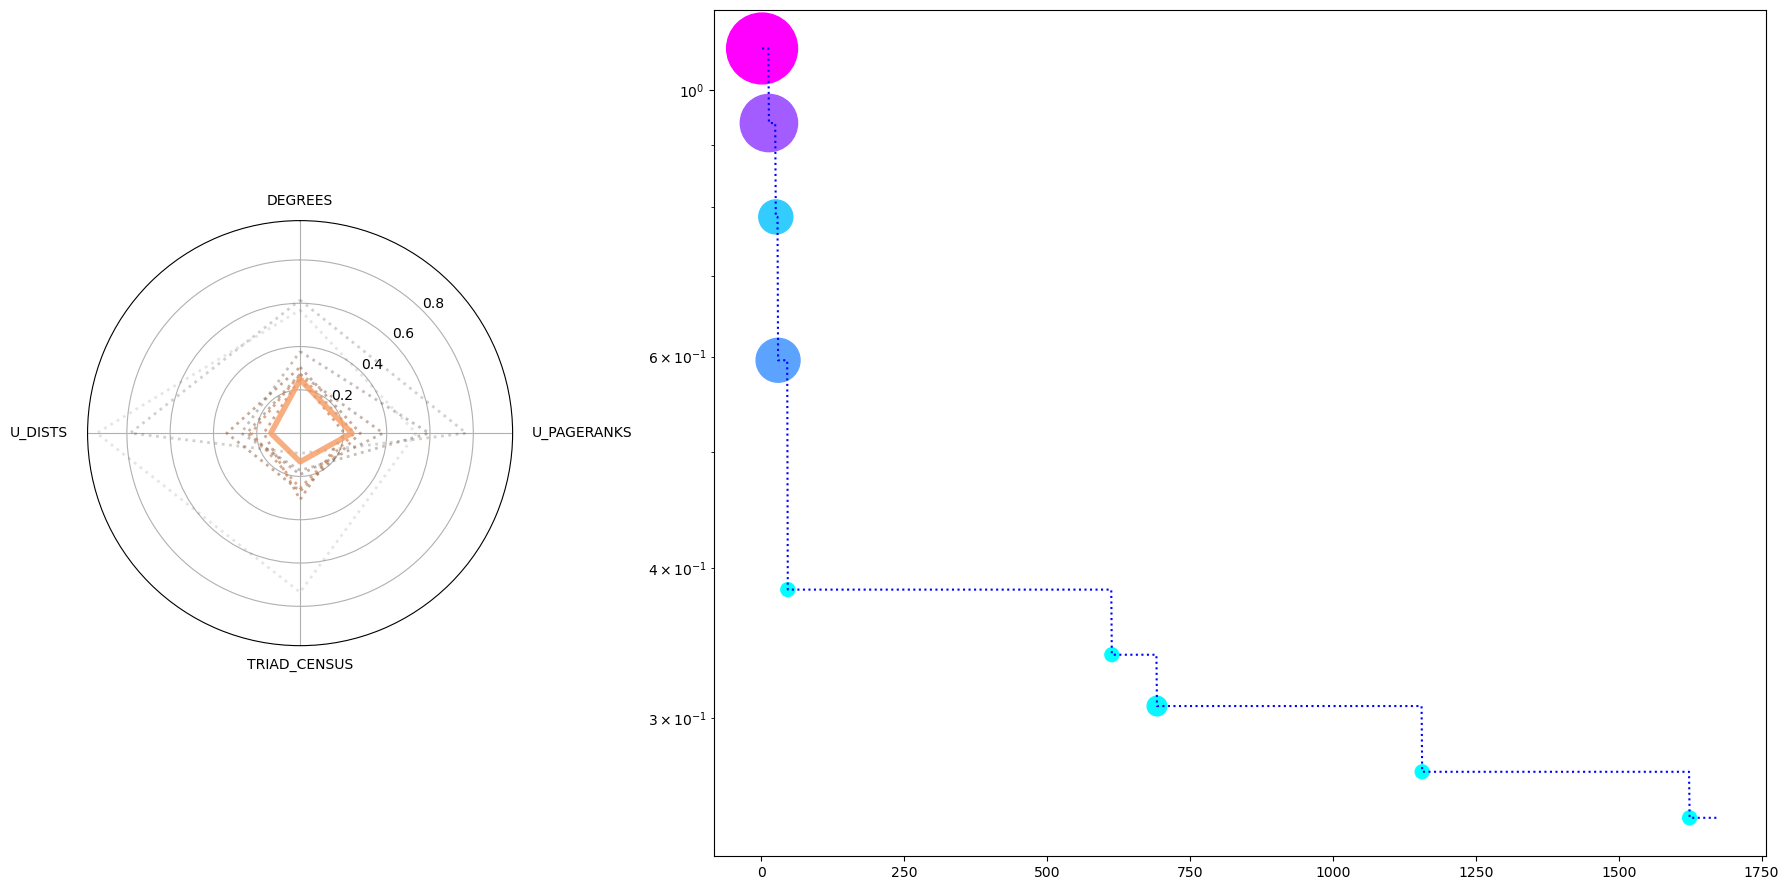

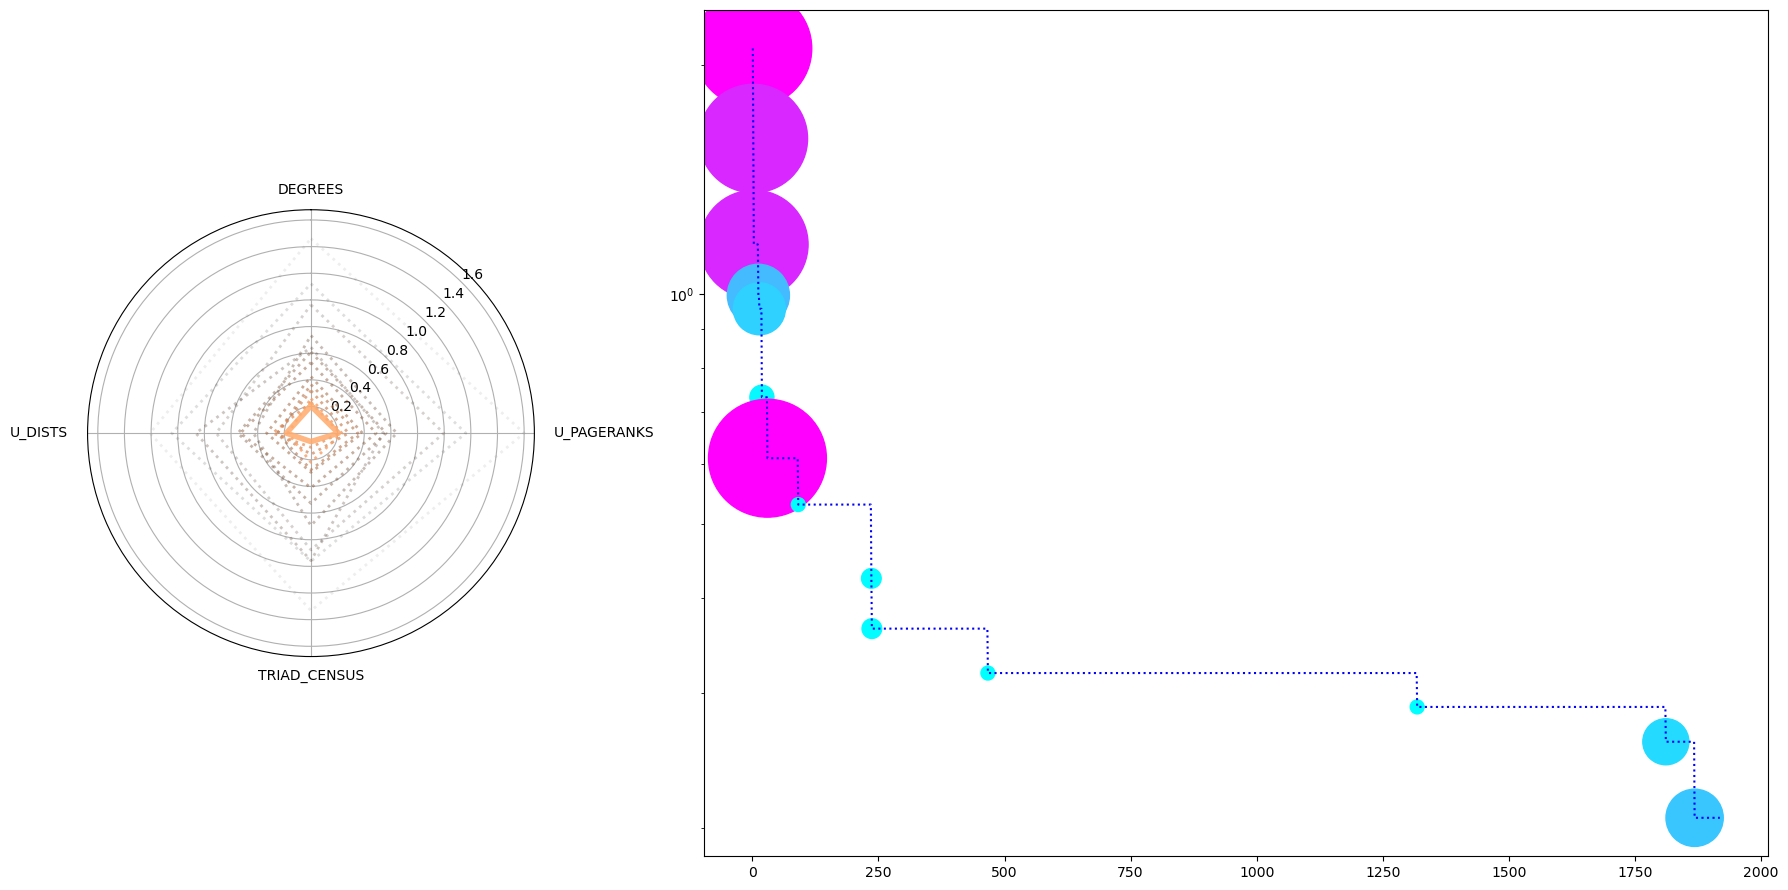

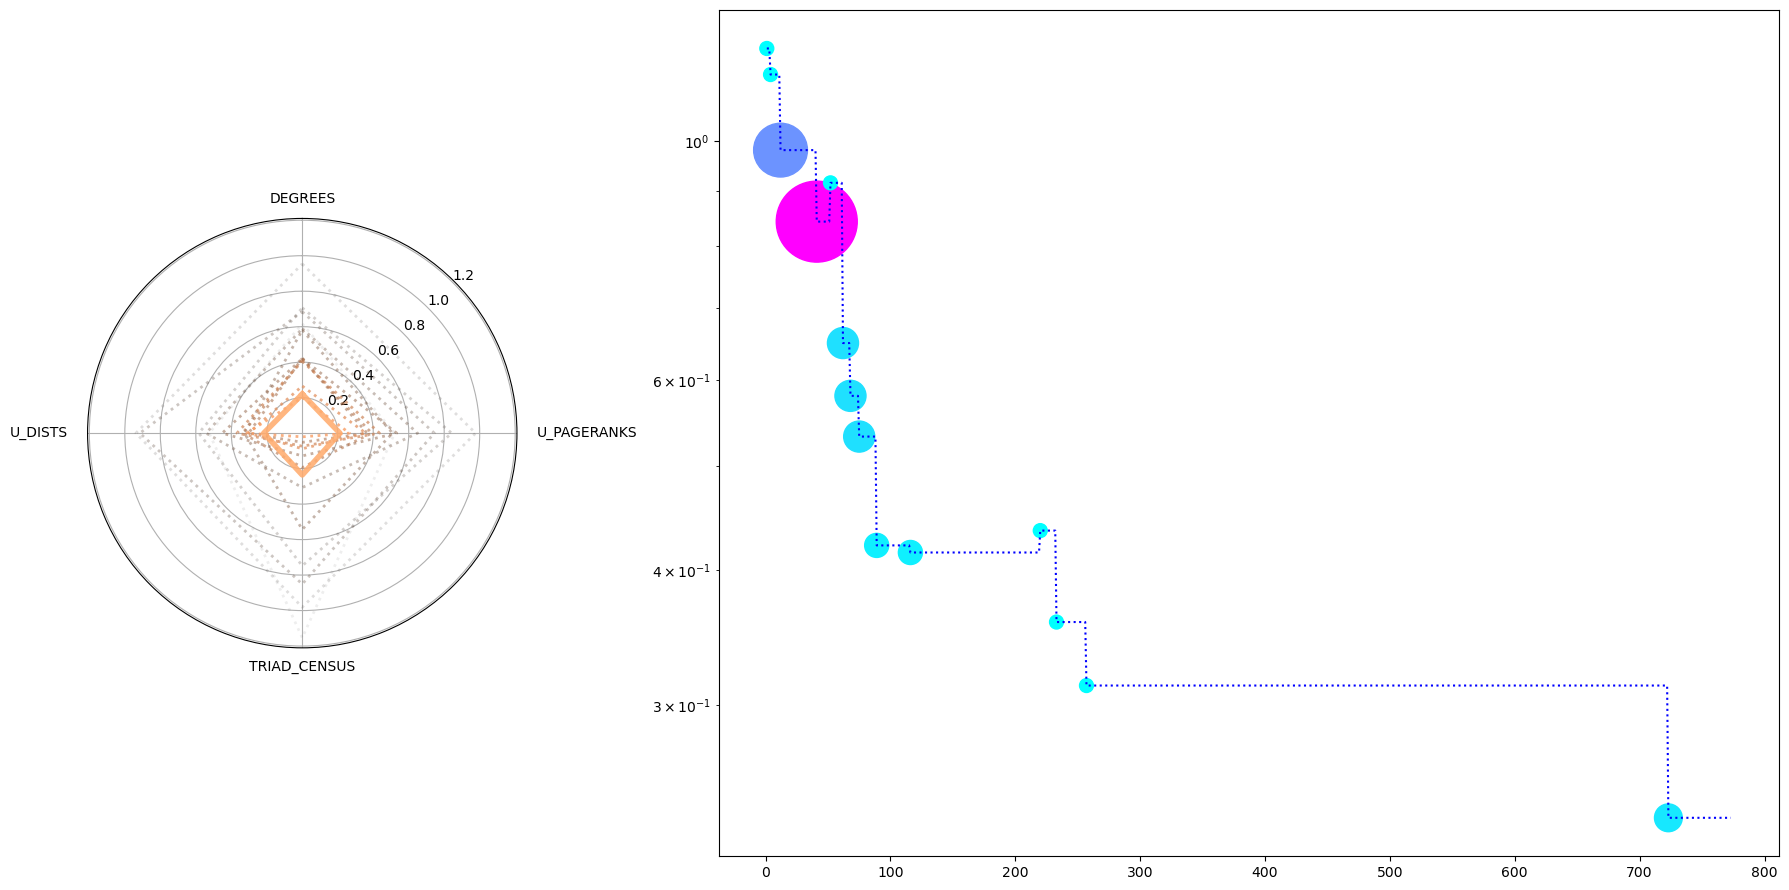

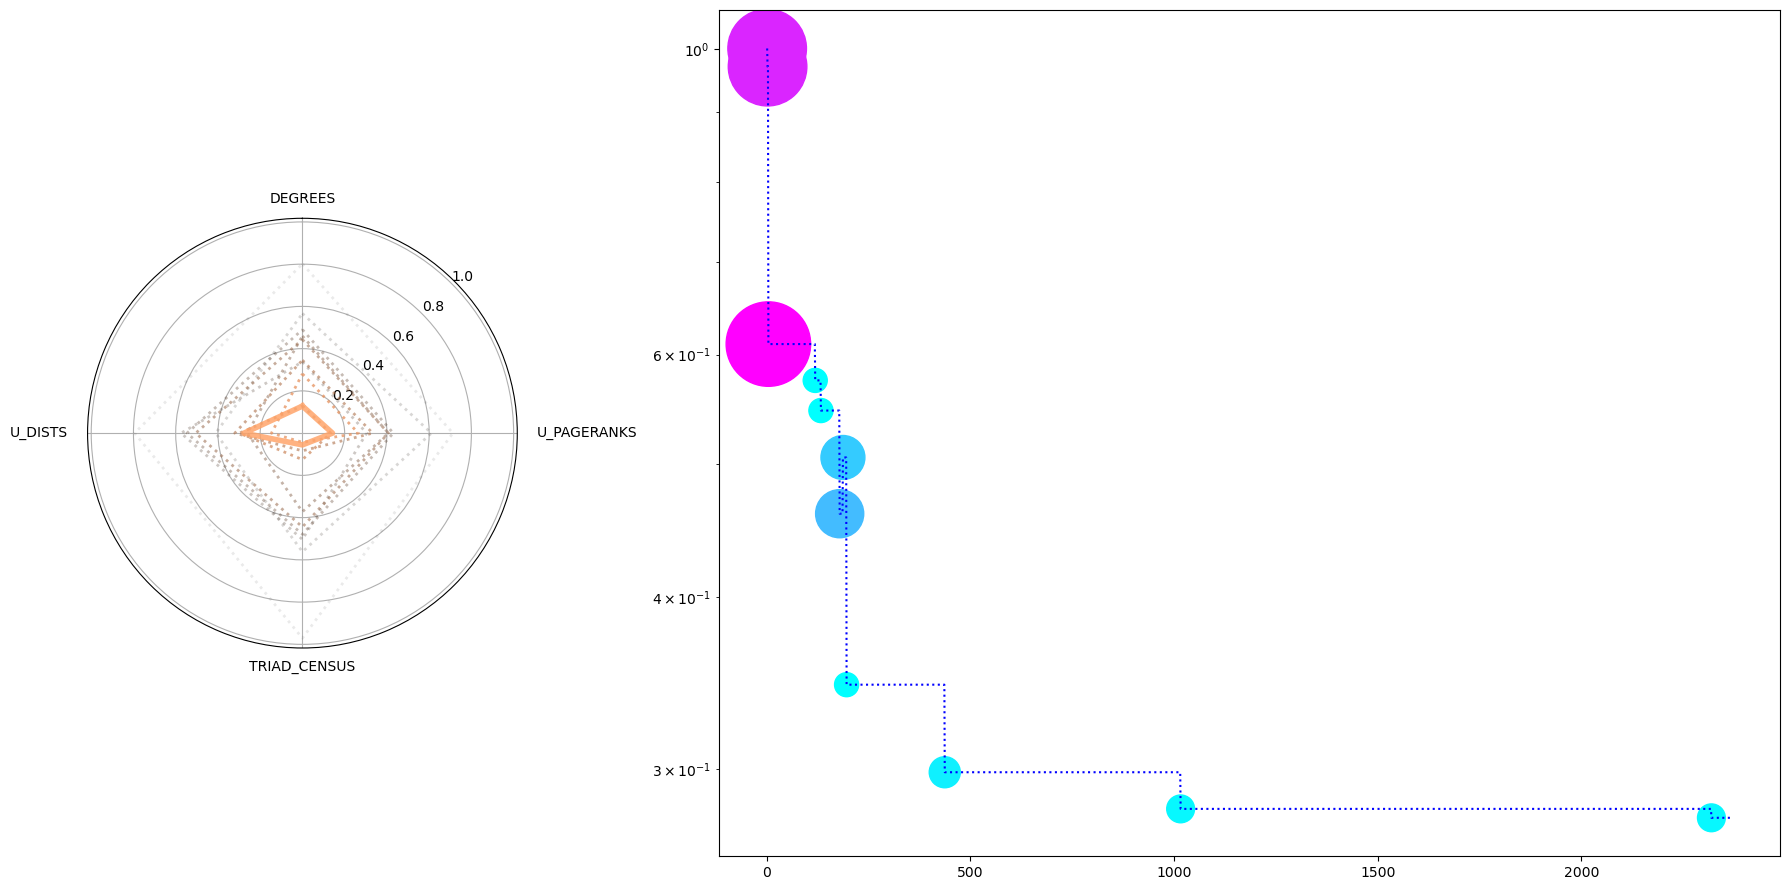

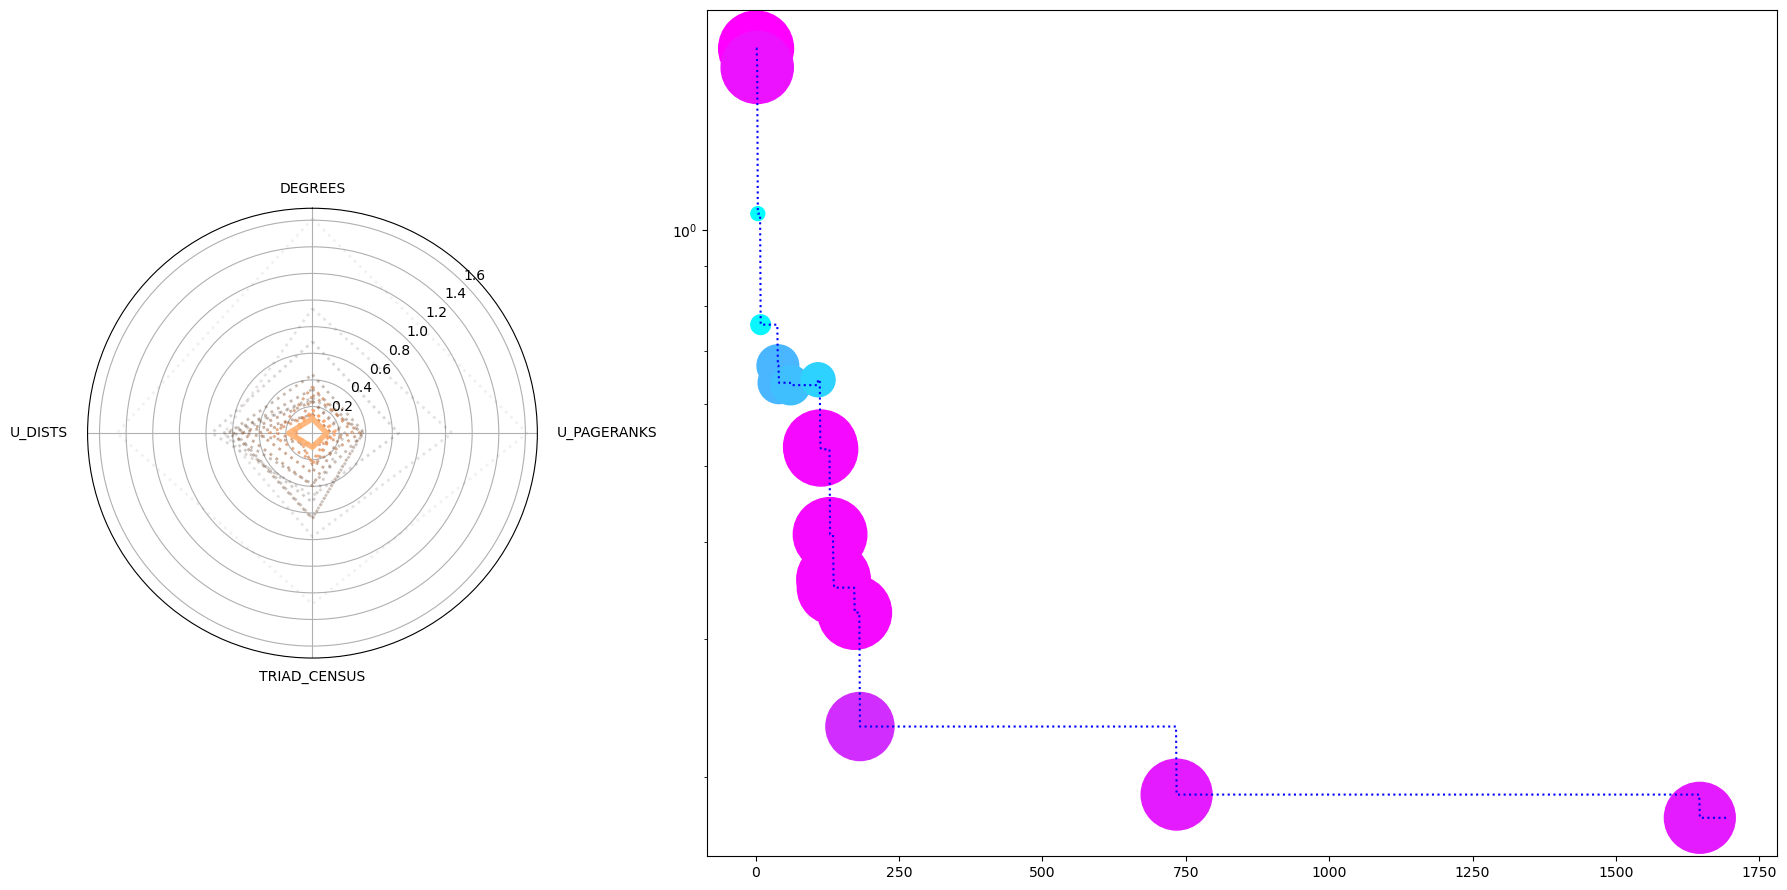

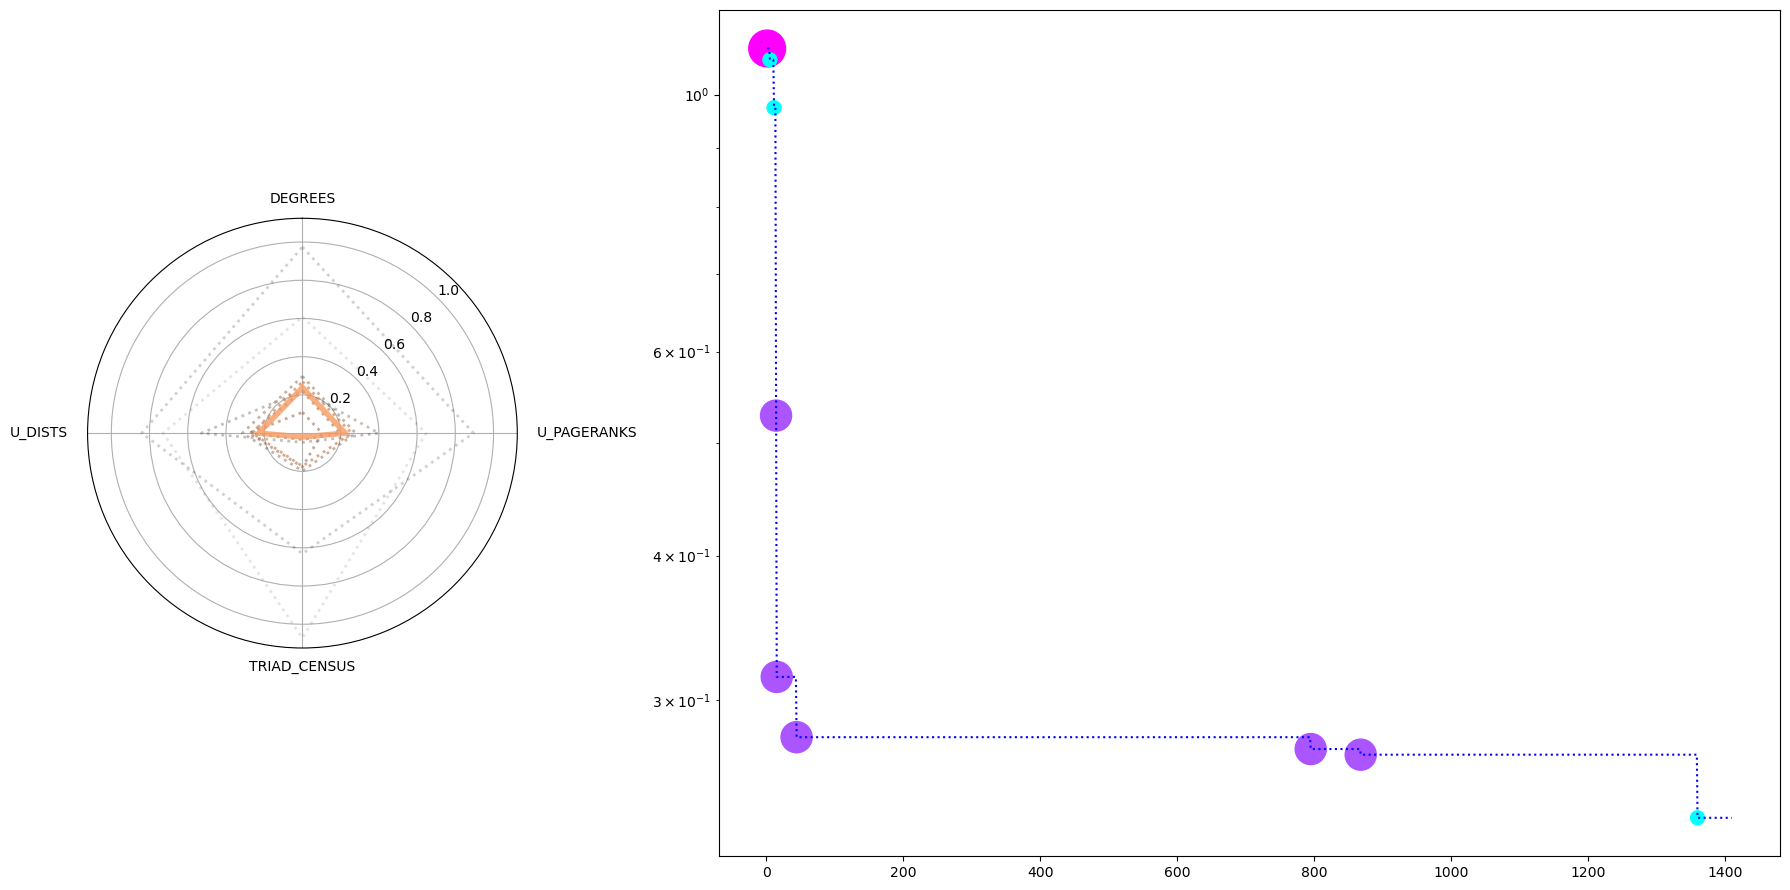

In [2]:
net_id = 'd_3'
path_res = 'data/repro_trad/d/'

for i in range(10):
    evoanal = loss_analysis.EvoAnalysis(
        path_to_evo_csv=path_res+'{}.{}/evo.csv'.format(net_id, i),
        evo_key = "best_fit",
        evo_key_size = "best_geno_size",
        stats_columns = ['DEGREES', 'U_PAGERANKS', 'TRIAD_CENSUS', 'U_DISTS'],
    )

    evoanal.run_analysis()

In [3]:
best_runs = retrieve_best_runs(
    results_dir=path_res,
    n_exps=10,
    experiments_names=None,
    csv_loss_name="evo.csv",
    loss_col = "best_fit",
    optim="min",
    include_prog=True
)

for k, v in best_runs.items():
    print("========================\n\t{}\nloss: {}\n\n{}\n".format(
        k,
        v["best_fit"],
        v["prog"],
    ))

	d_2
loss: 0.2717484901062944

$dist

	d_1
loss: 0.2647182475693378

(< 
 (* 
  (> $targ 0.3457206980212353 5.0 $orig_deg) 
  (> 
   (> $targ $targ_deg $orig $dist) 
   (* 0.3493336162313937 0.49870232845317364) 
   (+ $targ 0.07846158395707004) 
   (* $orig $targ))) 
 (LOG 
  (MAX 0.0 0.31446012729832784)) 
 (< 
  (MIN 0.7648483104526477 $targ) $orig $targ $orig_deg) 
 (/ 
  (< 0.5893906980152543 0.7550266353842028 $dist 9.0) $targ_deg))

	d_3
loss: 0.1774948281547024

(- 
 (AFF 
  (^ 0.4030723763177074 $orig_deg) 
  (/ 8.0 $targ_deg) 
  (> 
   (* $orig $orig) 0.019155700937646403 0.05557222761238312 8.0)) 
 (MIN 
  (< 4.0 
   (AFF 0.8775487283974618 
    (ABS $dist) 0.0) 0.0 0.3993784327672598) $targ_deg))



## Deep

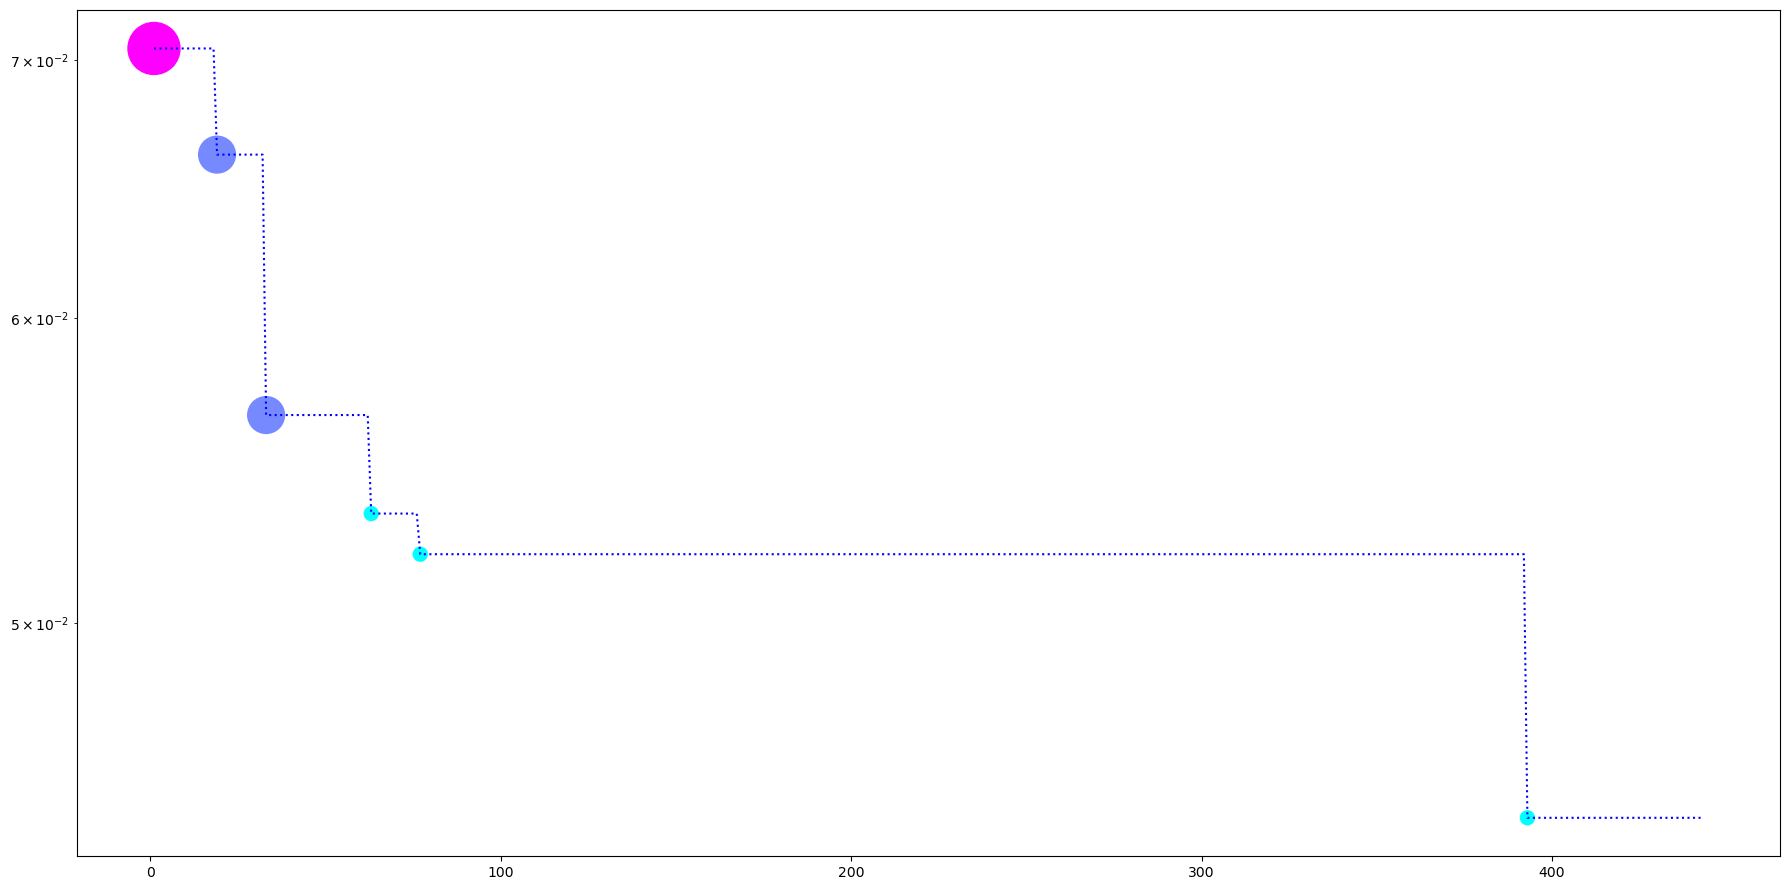

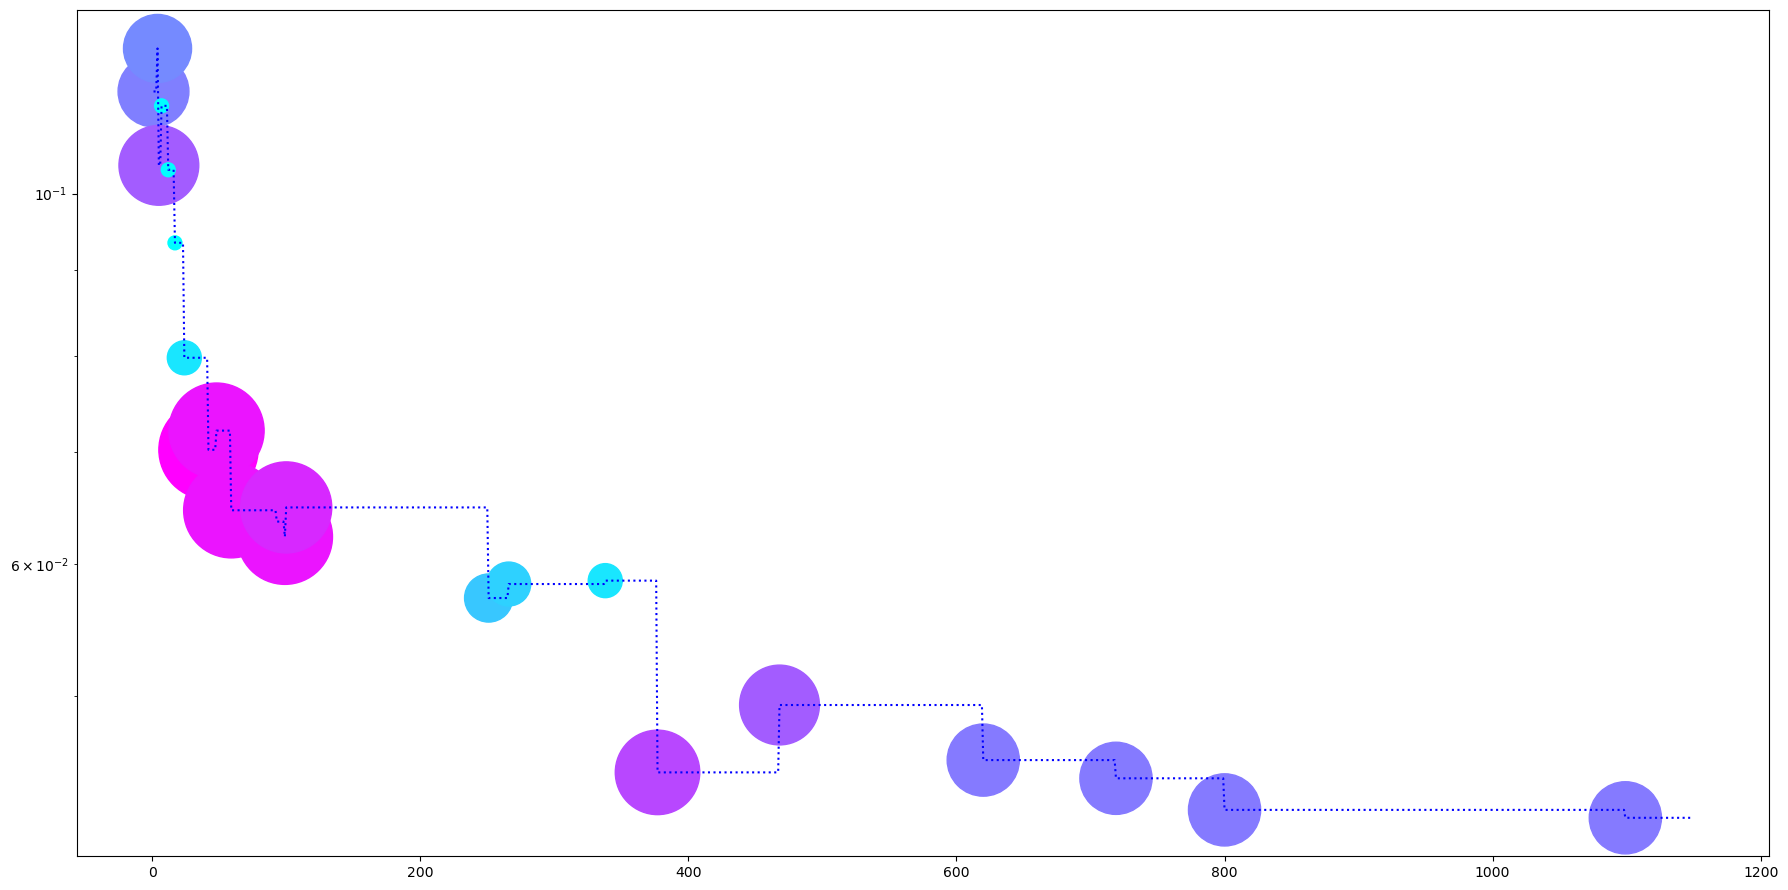

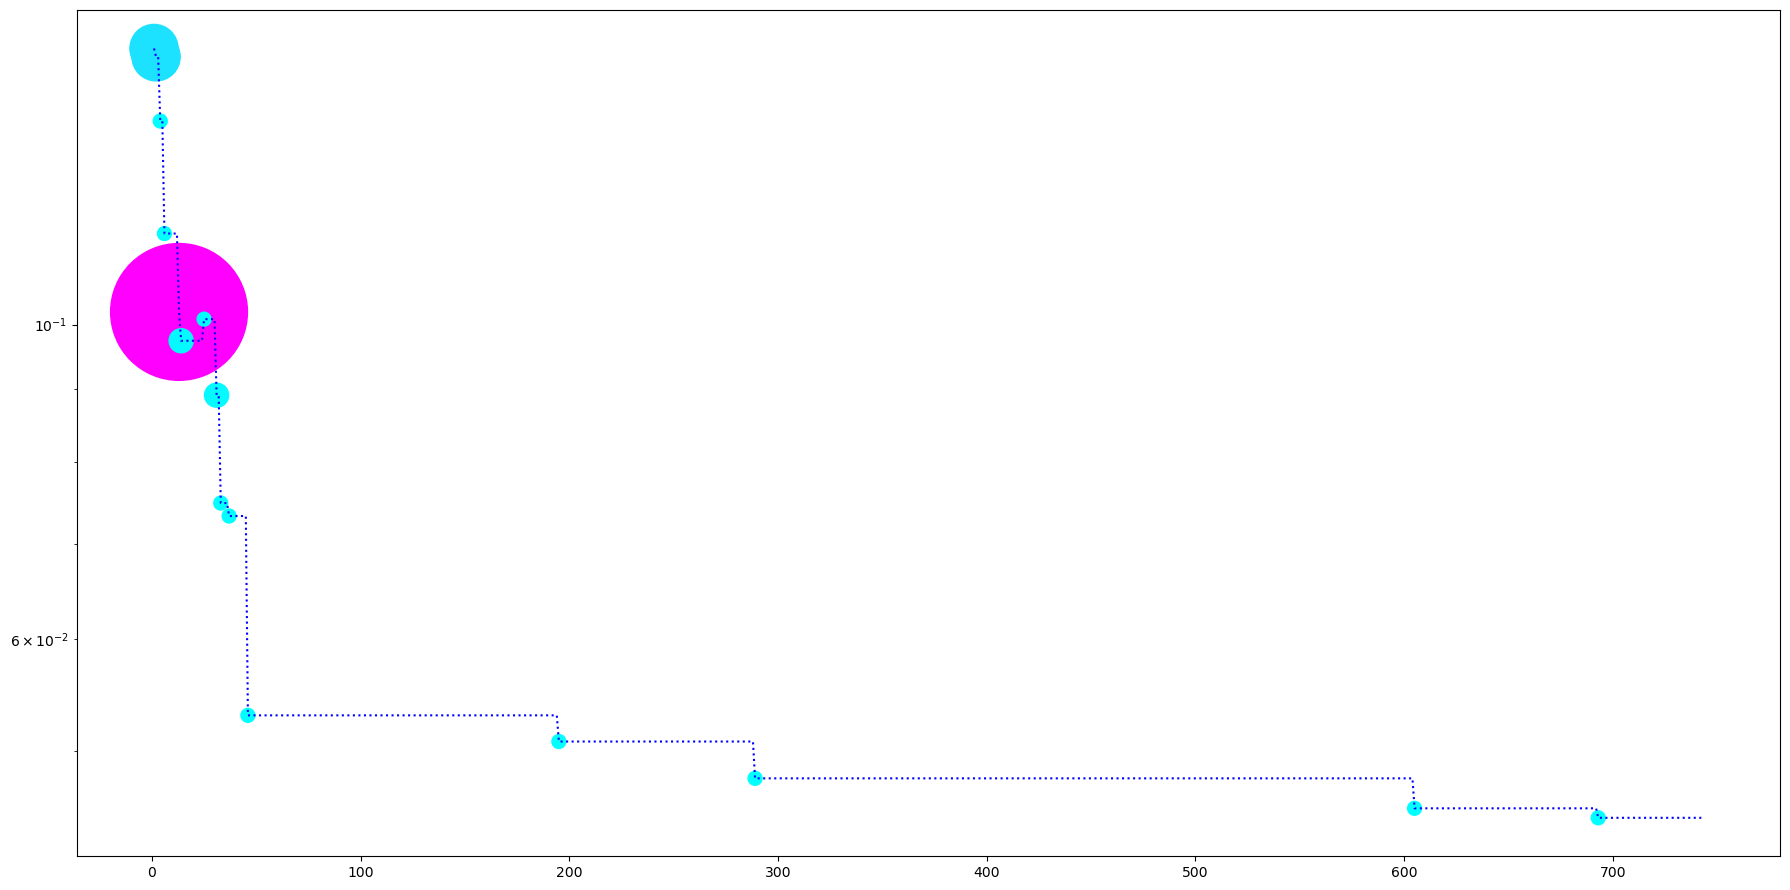

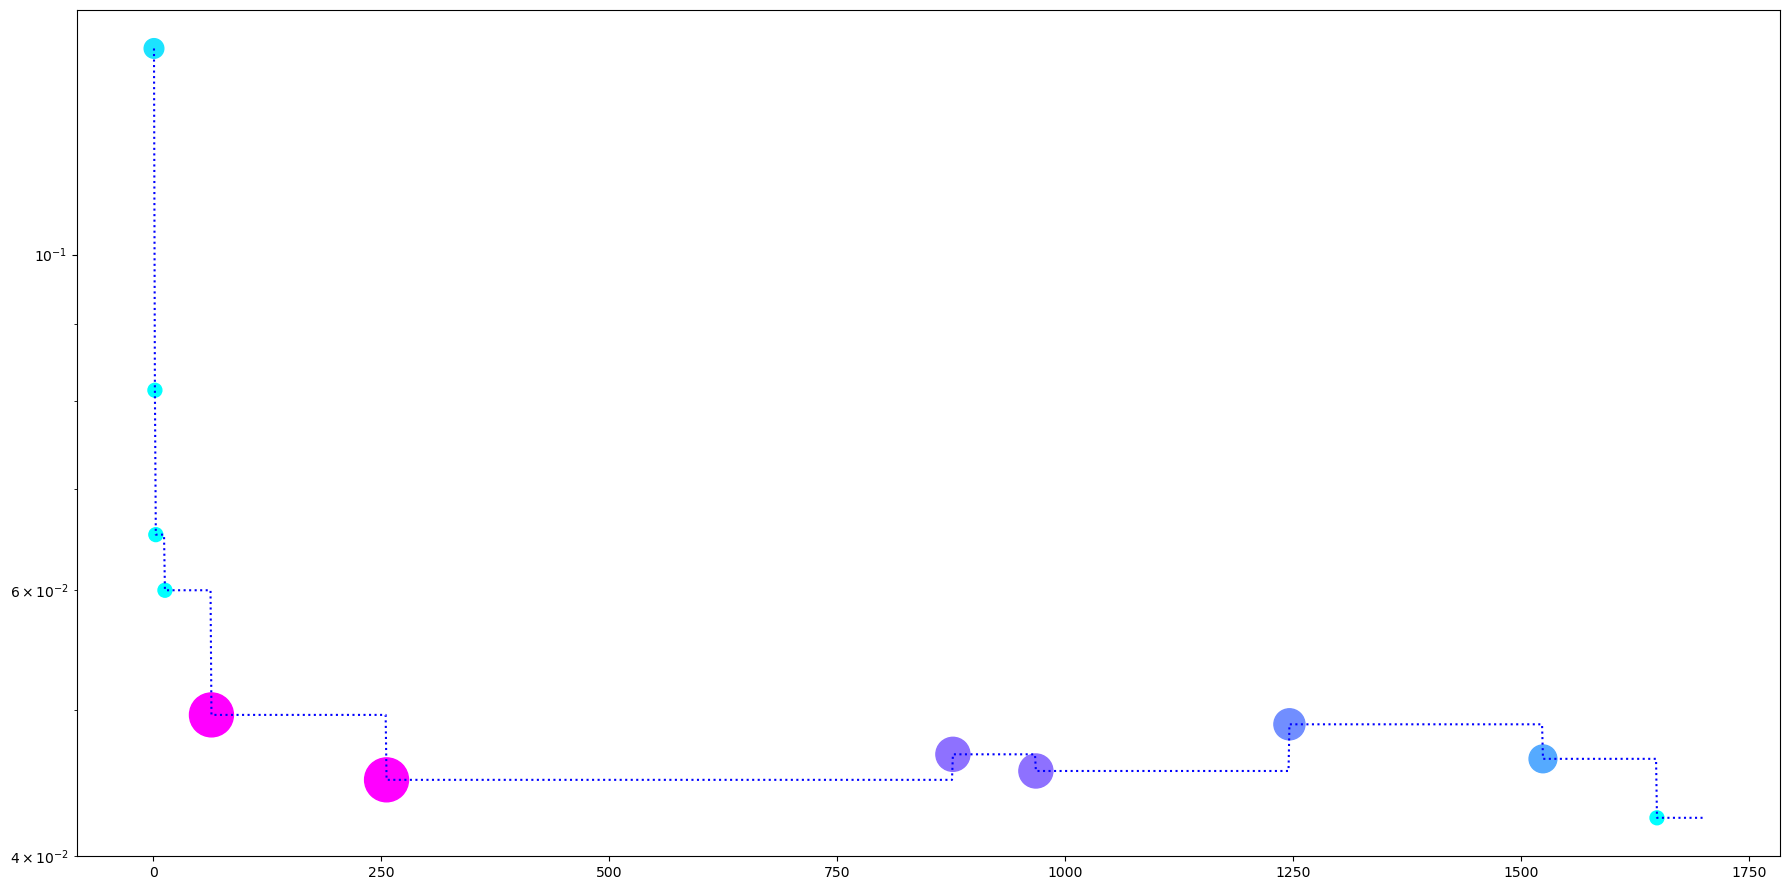

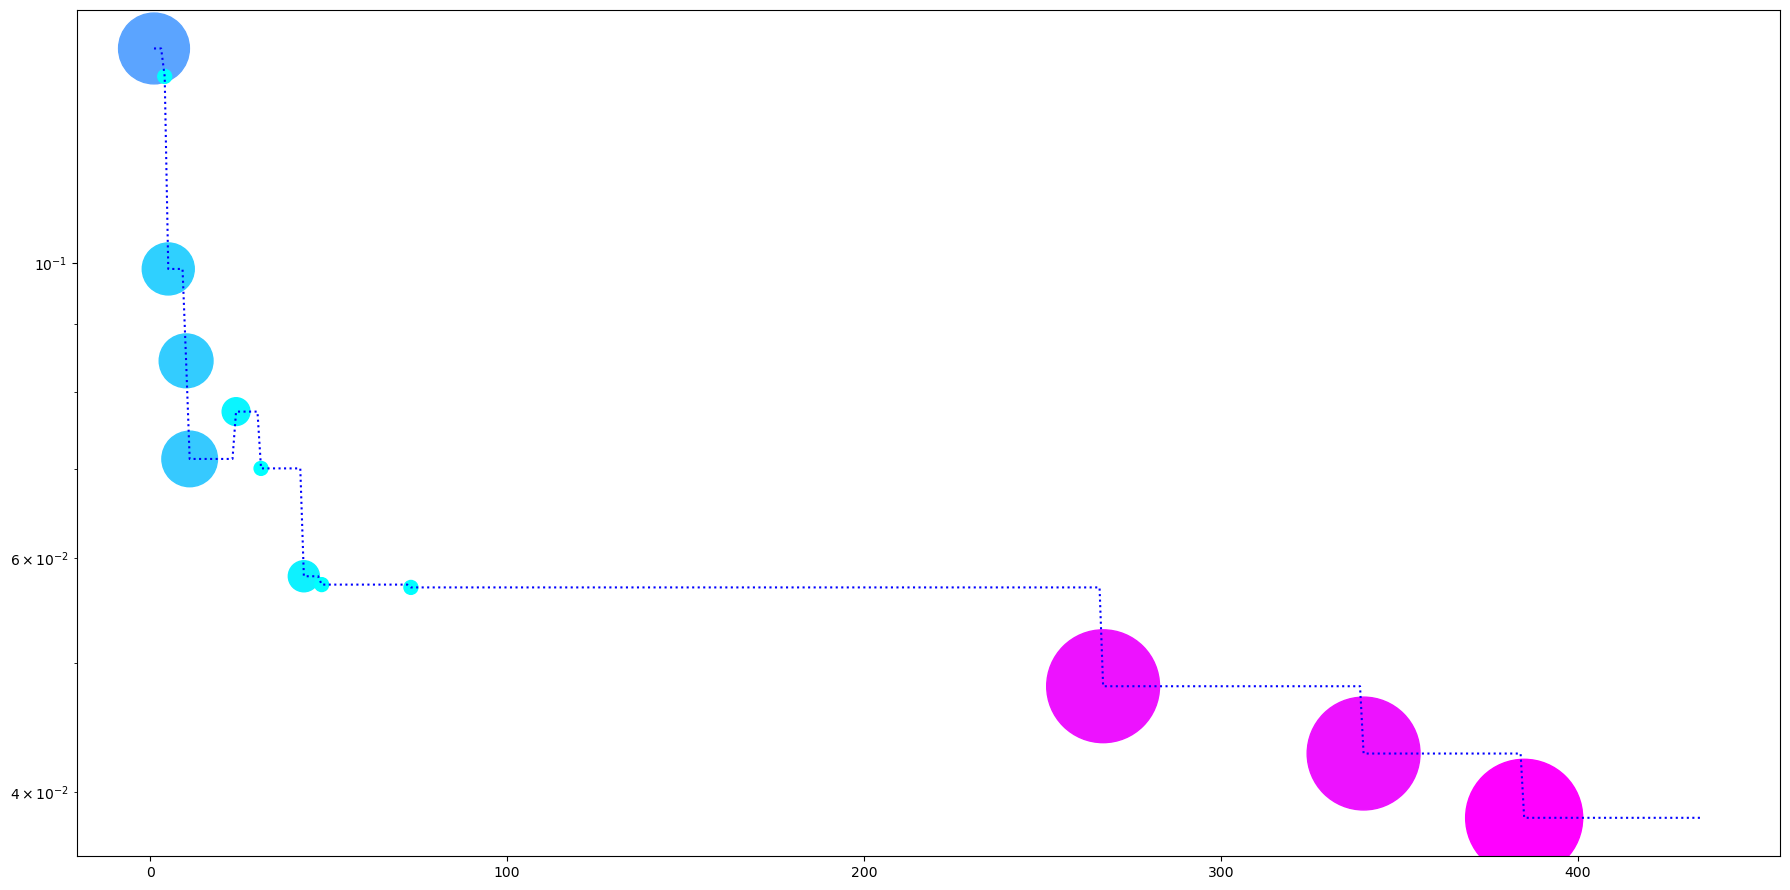

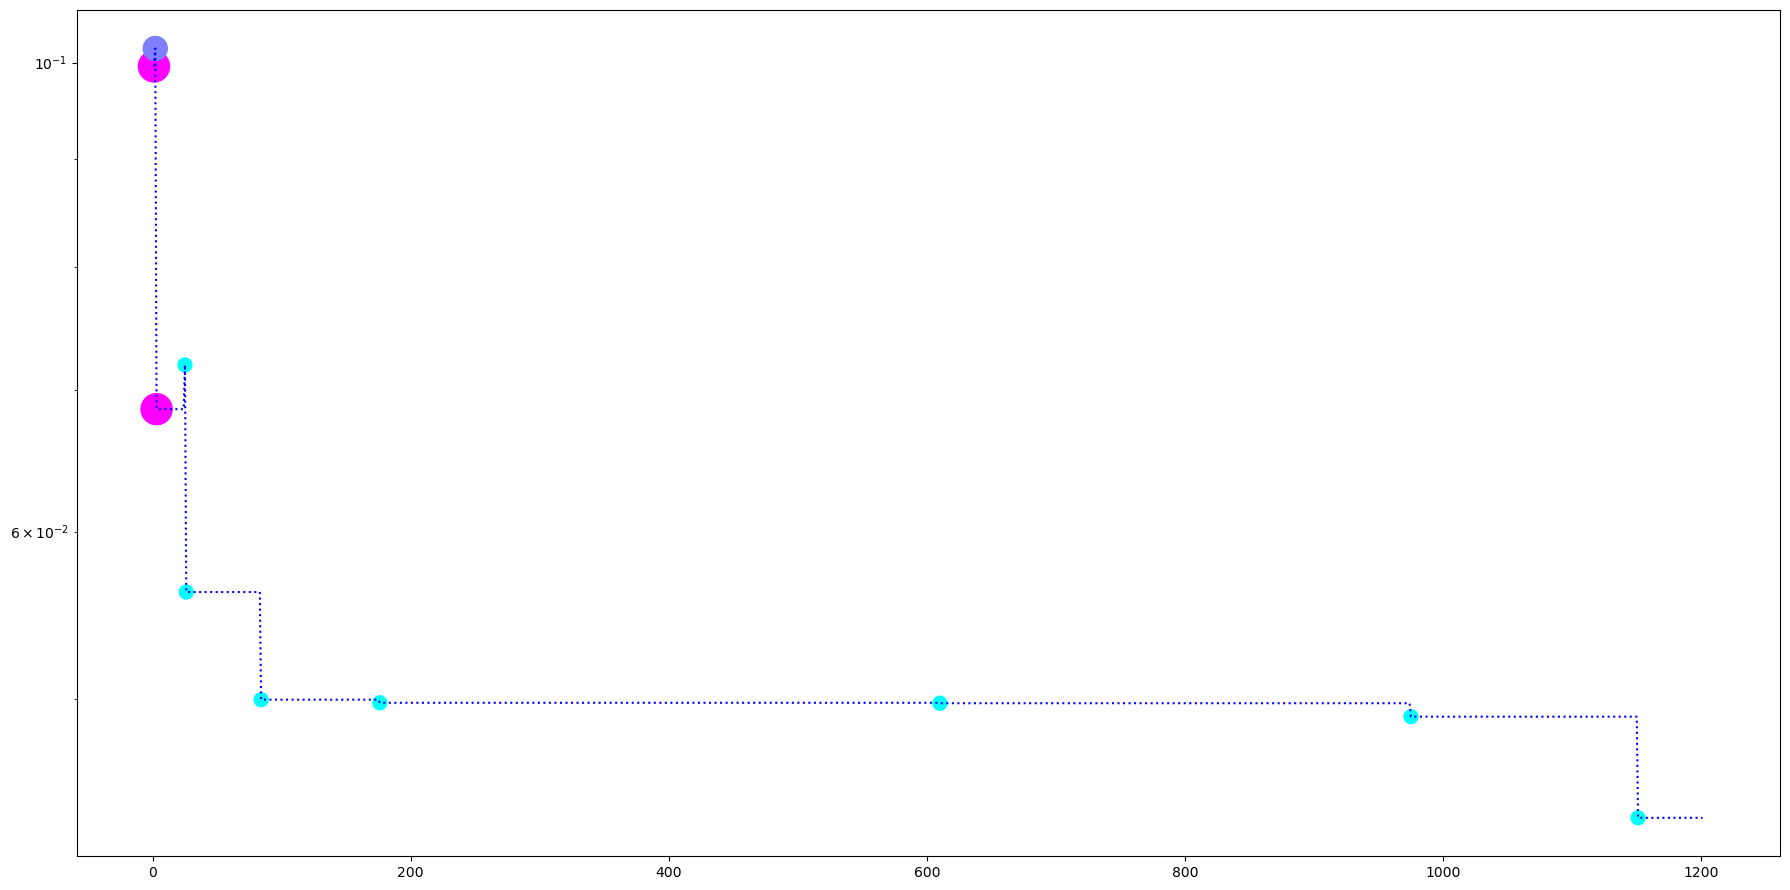

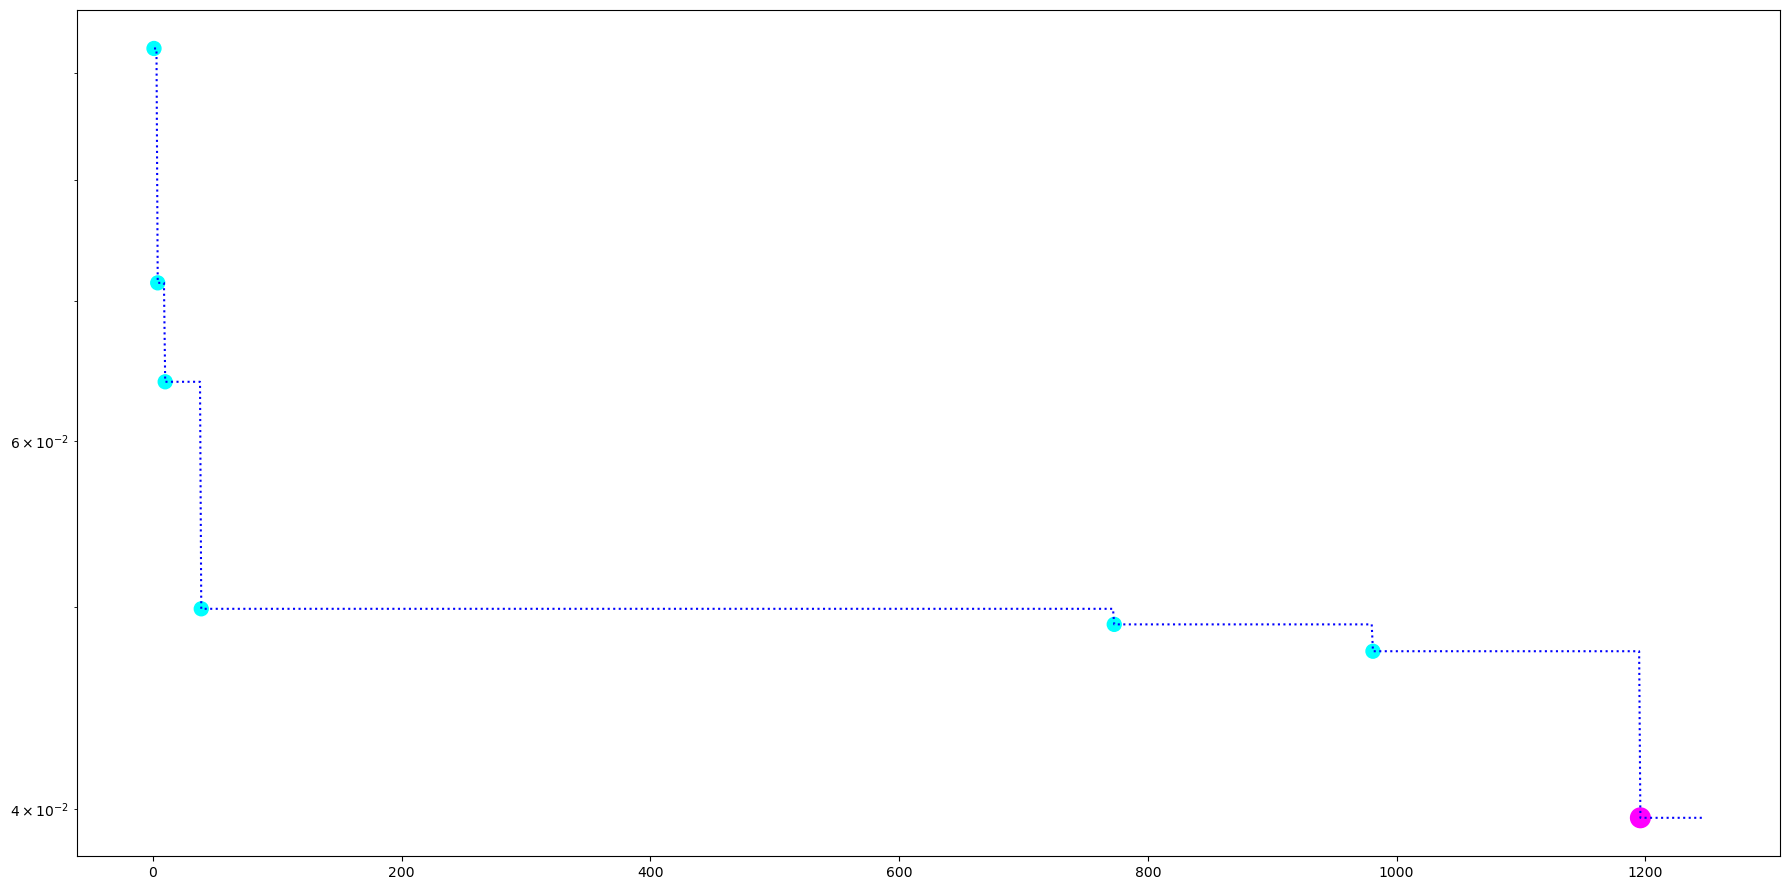

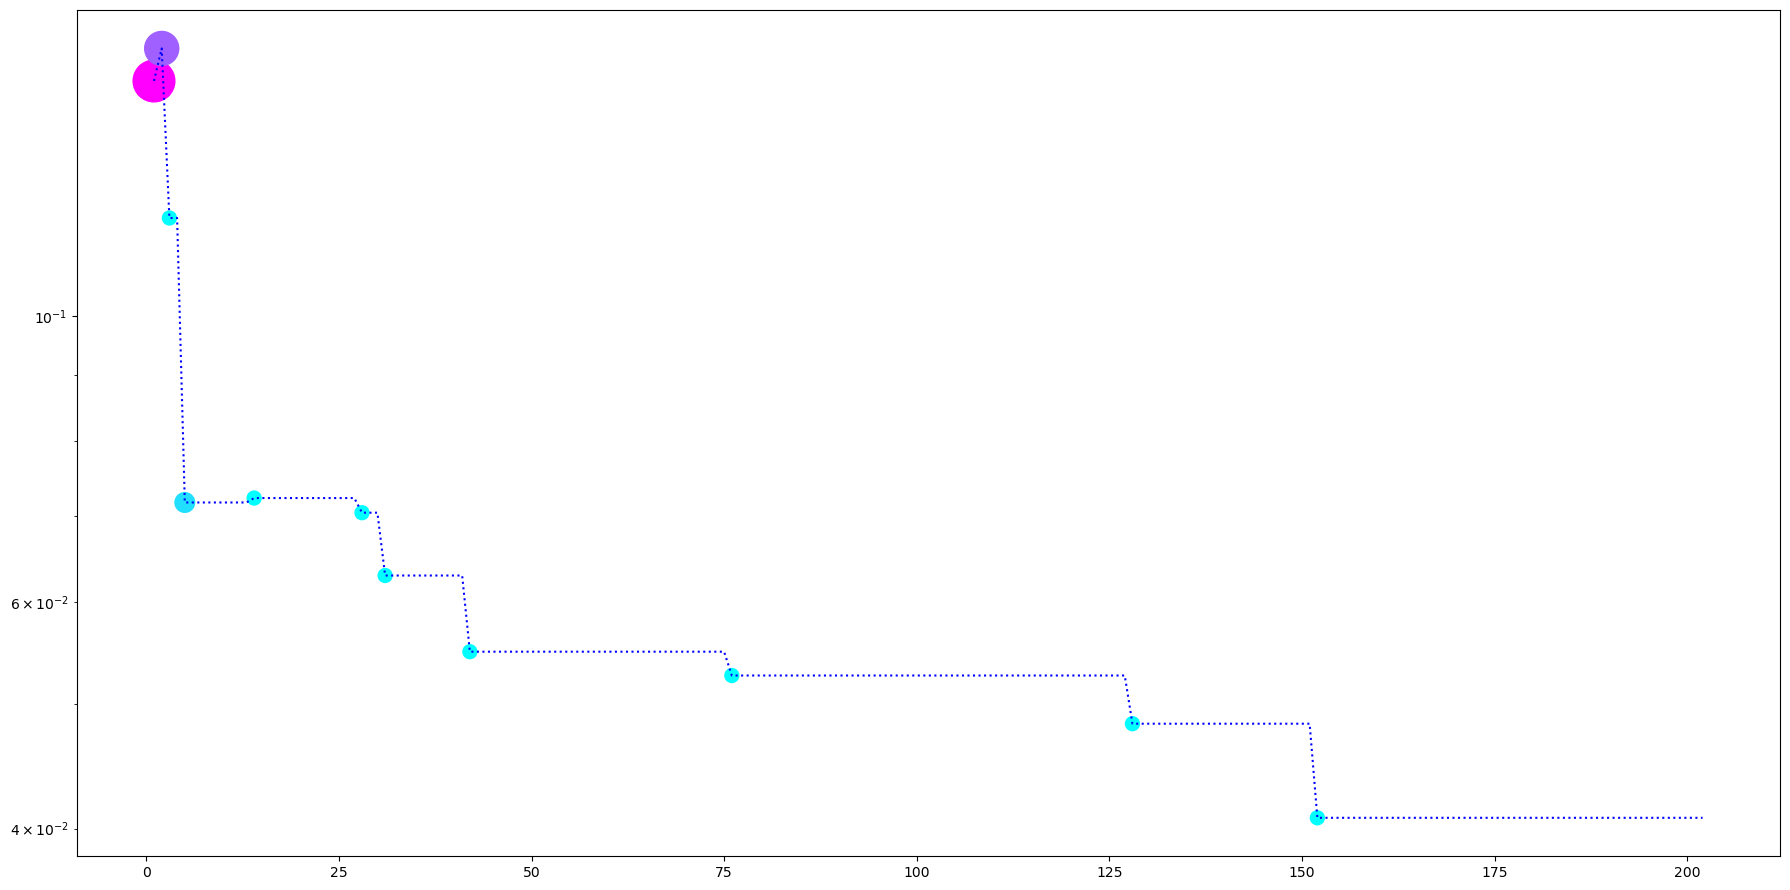

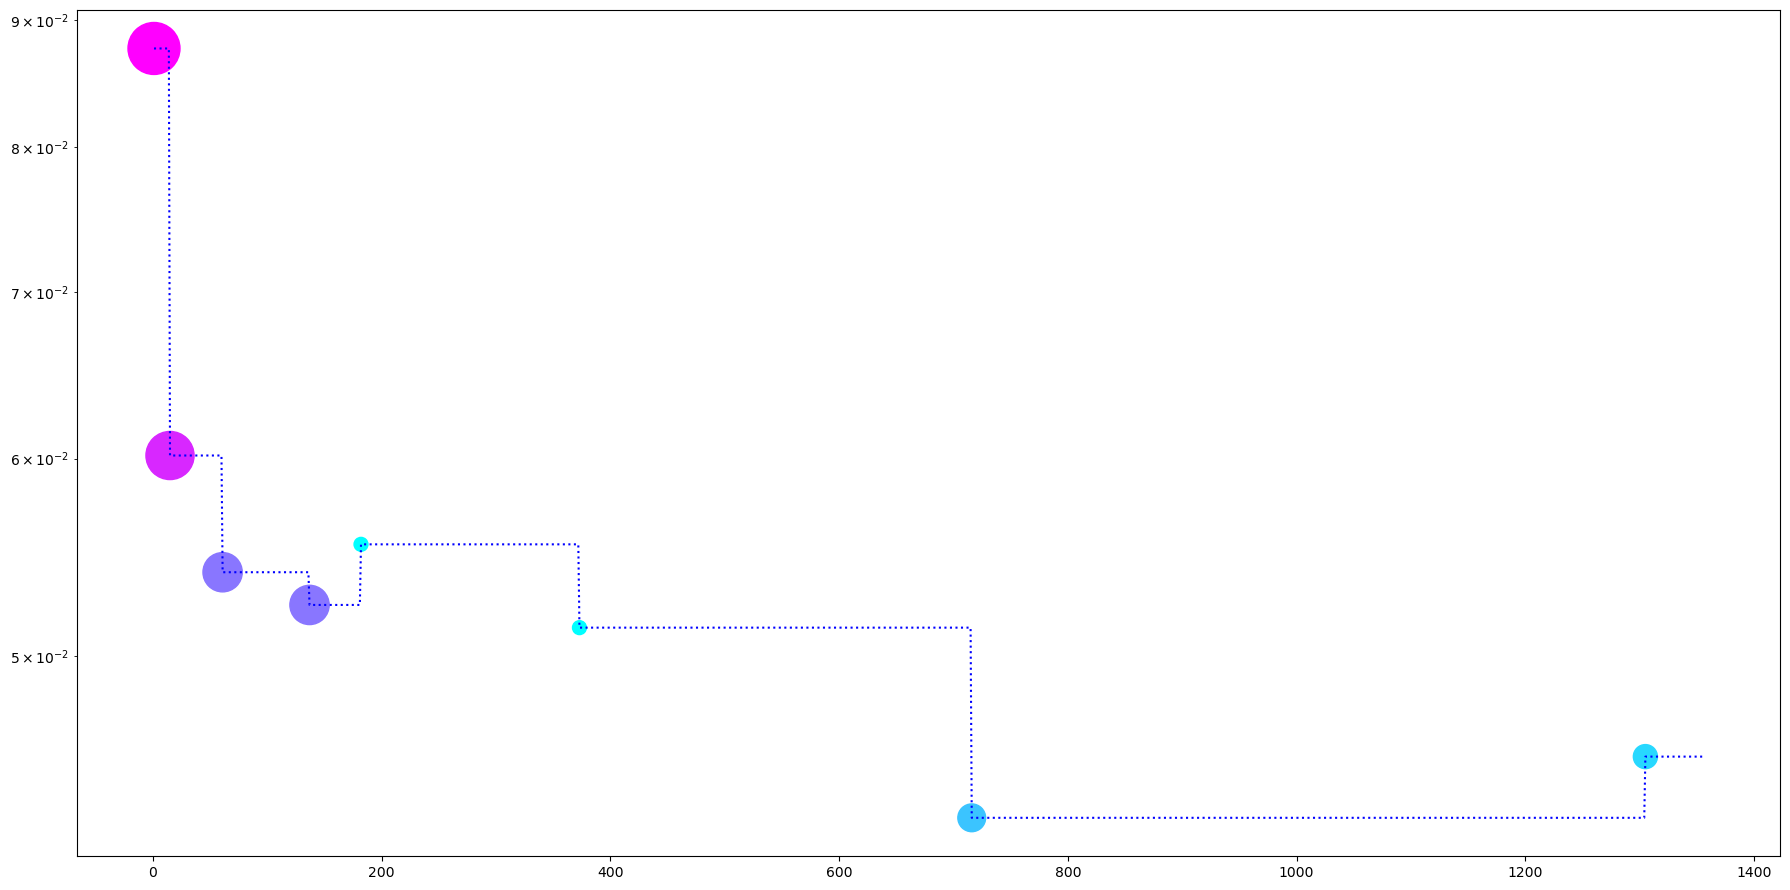

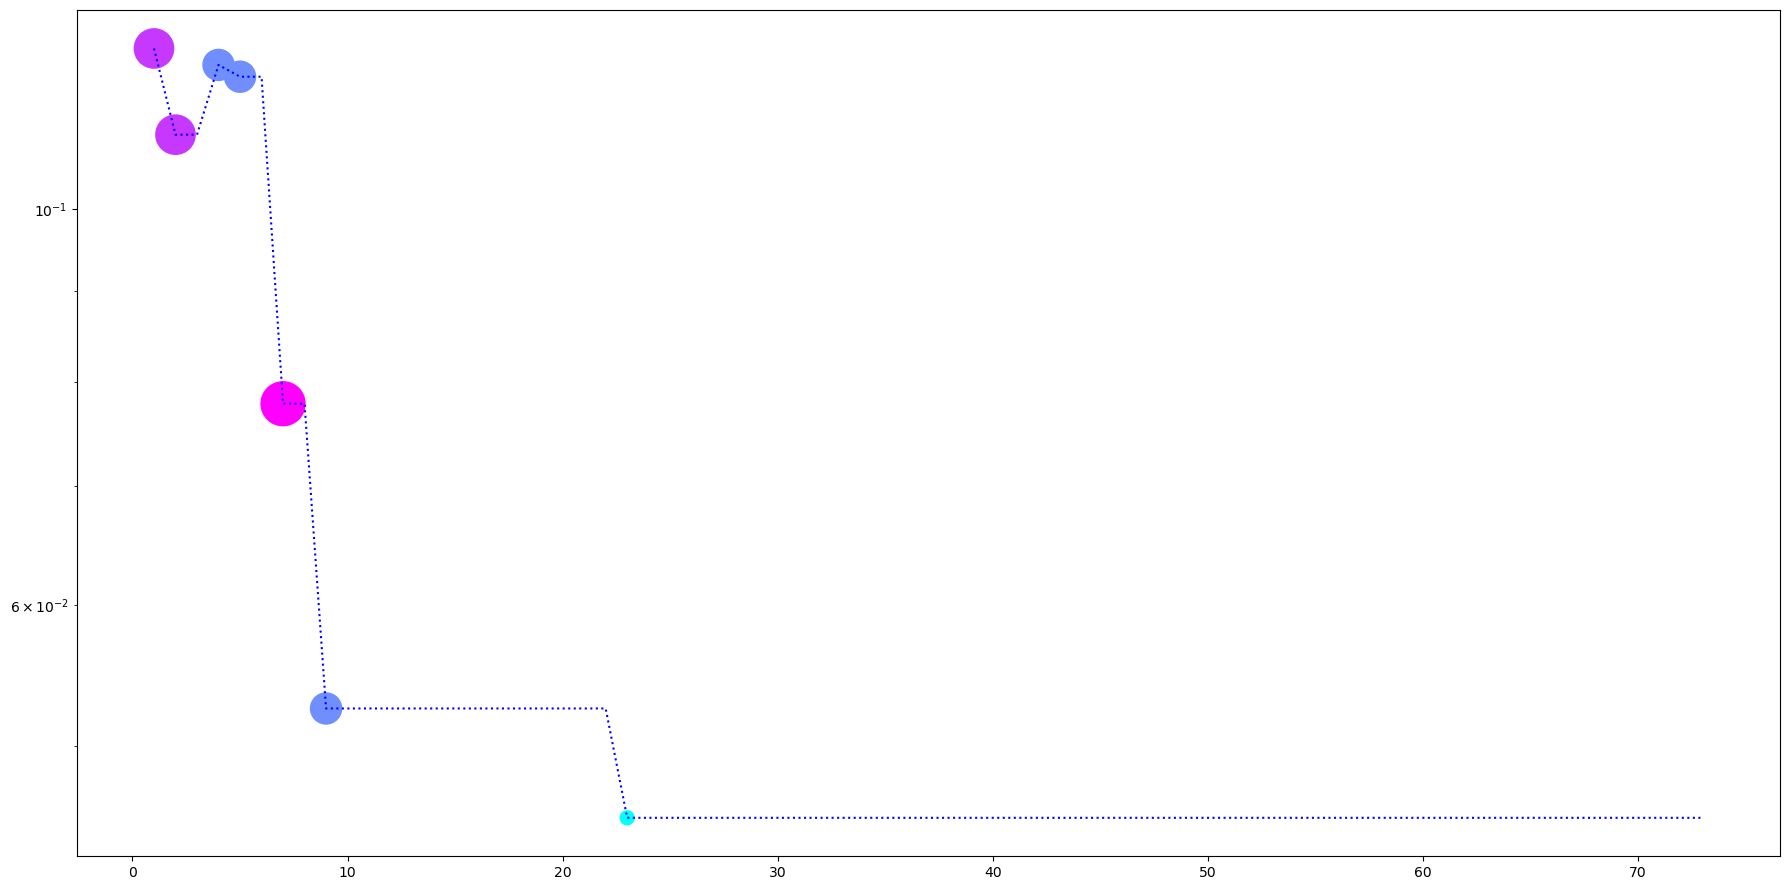

In [4]:
net_id = 'k_3'
path_res = 'data/repro_tests_GraphMAE_GCN64/PA/'

#net_id = 'c1_1'
#path_res = 'data/repro_tests_GraphMAE_GCN64/ER/'

for i in range(10):
    evoanal = loss_analysis.EvoAnalysis(
        path_to_evo_csv=path_res+'{}.{}/evo.csv'.format(net_id, i),
        evo_key = "best_fit",
        evo_key_size = "best_geno_size",
        stats_columns = [''],
    )

    evoanal.run_analysis()

In [5]:
best_runs = retrieve_best_runs(
    results_dir=path_res,
    n_exps=10,
    experiments_names=None,
    csv_loss_name="evo.csv",
    loss_col = "best_fit",
    optim="min",
    include_prog=True
)

for k, v in best_runs.items():
    print("========================\n\t{}\nloss: {}\n\n{}\n".format(
        k,
        v["best_fit"],
        v["prog"],
    ))

	k_3
loss: 0.0382377989590168

(ZER 
 (AFF 
  (== 
   (AFF 0.0 0.0 $dist) 
   (> 0.3610506616671977 9.0 0.4672561103952856 $targ) 
   (ZER $orig_deg $targ_deg $orig_deg) 
   (> $orig $targ_deg 0.33550095096580534 0.0)) 
  (EXP 
   (> $targ_deg $orig_deg 0.0920227238625041 0.09519953625519961)) 
  (< 
   (MAX $targ_deg $targ_deg) 
   (MAX $orig 7.0) 
   (AFF 0.0 $targ_deg 
    (ABS 
     (> $targ_deg 0.16077819168613494 $orig $targ))) 
   (MIN $targ $targ_deg))) 
 (MAX 
  (ZER 
   (== $dist $targ $orig 0.17084982553200345) 
   (EXP 2.0) 
   (- $targ 2.0)) 
  (MIN 
   (MIN 0.06918722256930798 $dist) 
   (^ $orig $targ))) 
 (LOG 
  (MIN 
   (EXP 8.0) 
   (LOG $orig_deg))))

	k_1
loss: 0.0303670242428779

(* $orig 
 (ZER 9.0 $orig_deg $orig))

	k_2
loss: 0.0387334749102592

$orig_deg



## 🗺 evo trajectory in space ?

In [6]:
from os import listdir
from synthetic.net import load_net

In [7]:
from synthetic.generator import load_generator

def is_er(prog_str):
    """ Returns True is string is a number. """
    try:
        float(prog_str)
        return True
    except ValueError:
        return False
    
def is_pa(prog_str):
    solutions = [
        '$orig_deg', '$targ_deg'
    ]
    return np.any([prog_str in s for s in solutions])

def is_id(prog_str):
    solutions = [
        '$orig', '$targ'
    ]
    return np.any([prog_str in s for s in solutions])

def is_d(prog_str):
    solutions = [
        '$dist'
    ]
    return np.any([prog_str in s for s in solutions])

def colorfromprog(netpath):#, repo_path=REPO_SAVED_ALL):
    progpath = netpath.replace(".gml", ".txt").replace("bestnet", "bestprog")
    prog = load_generator(progpath, directed=False)
    
    progstr = str(prog.prog)
    
    if is_er(progstr):
        return 'orange'
    elif is_id(progstr):
        return 'green'
    elif is_pa(progstr):
        return 'blue'
    elif is_d(progstr):
        return 'red'
    else:
        return 'grey'

In [8]:
from space_seg.space_seg_classes import *

%load_ext autoreload
%autoreload 2

gen_fams_dict = {
    # Canonical
    "PA": {
        "k": {
            "generator_path": GEN_PATH+"k.gen",
            "number_generated":N_GRAPHS
        }
    },
    "ER": {
        "c1": {
            "generator_path": GEN_PATH+"c1.gen",
            "number_generated":N_GRAPHS
        },
    },
    "ID": {
        "id": {
            "generator_path": GEN_PATH+"id.gen",
            "number_generated":N_GRAPHS
        }
    },
    "d": {
        "d": {
            "generator_path": GEN_PATH+"d.gen",
            "number_generated":N_GRAPHS
        }
    },
}

generated_nodes = np.arange(100, 1100, 100)[:2]
generated_densities = np.linspace(0.001, 0.2, 10)

MIN_AV_DEG = 5
MAX_AV_DEG = 200

print(generated_nodes)
print(generated_densities)

ve_values = [(100, 552)]


netgen = SynNetsGenerator(
    generator_dict=gen_fams_dict,
    ve_pairs_list=ve_values,
    compute_files=False, # SET To ` True ` to generate the network files
    do_overwrite = False,
)


embmeth = load_embedder(
    "DL_module/saved/best_models/GraphMAE_GCNversion_o64/"
    #"DL_module/saved/best_models/trad_degs/"
)

netemb = netgen.make_embedder(
    **{
        #"embedding_method": lambda net: emb_degs(net, **{"bins":bins, "range":(0,max_val)}),
        "embedding_method": lambda net: embed_deep(net, embedder_method=embmeth),
        #"reducer": TSNE()#PCA(n_components=2)
    }
)

netana = netemb.make_analyzer()

print("Done\nReady for experiments.")

/Users/nmm/miniforge3/envs/env_gdl/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[100 200]
[0.001      0.02311111 0.04522222 0.06733333 0.08944444 0.11155556
 0.13366667 0.15577778 0.17788889 0.2       ]
Done
Ready for experiments.


In [9]:
FITTED_NET = 'space_seg/data/data_v2/v100_e552/PA/k_1.pickle'
REPO_SAVED_ALL = "data/repro_save_k/GraphMAE_vGCN_o64/k_1.0/"

In [10]:
evonets_paths = [f for f in listdir(REPO_SAVED_ALL)
           if f.endswith('.gml') and '_gen' in f
          ]
evonets_paths = sorted(evonets_paths, key=lambda x: int(x.split('_gen')[0].split('bestnet')[1]), reverse=False)

print("- "+"\n- ".join(evonets_paths))

evonets_paths = [FITTED_NET] + [REPO_SAVED_ALL+n for n in evonets_paths]

evonets = [load_net(net, directed=False)
           for net in evonets_paths]

- bestnet0_gen1.gml
- bestnet1_gen4.gml
- bestnet2_gen7.gml
- bestnet3_gen10.gml
- bestnet4_gen17.gml
- bestnet5_gen42.gml
- bestnet6_gen71.gml


In [11]:
evonets_embs = [netemb.embedder(n) for n in evonets]

/Users/nmm/miniforge3/envs/env_gdl/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/nmm/miniforge3/envs/env_gdl/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Text(0.5, 1.0, '(100, 552)')

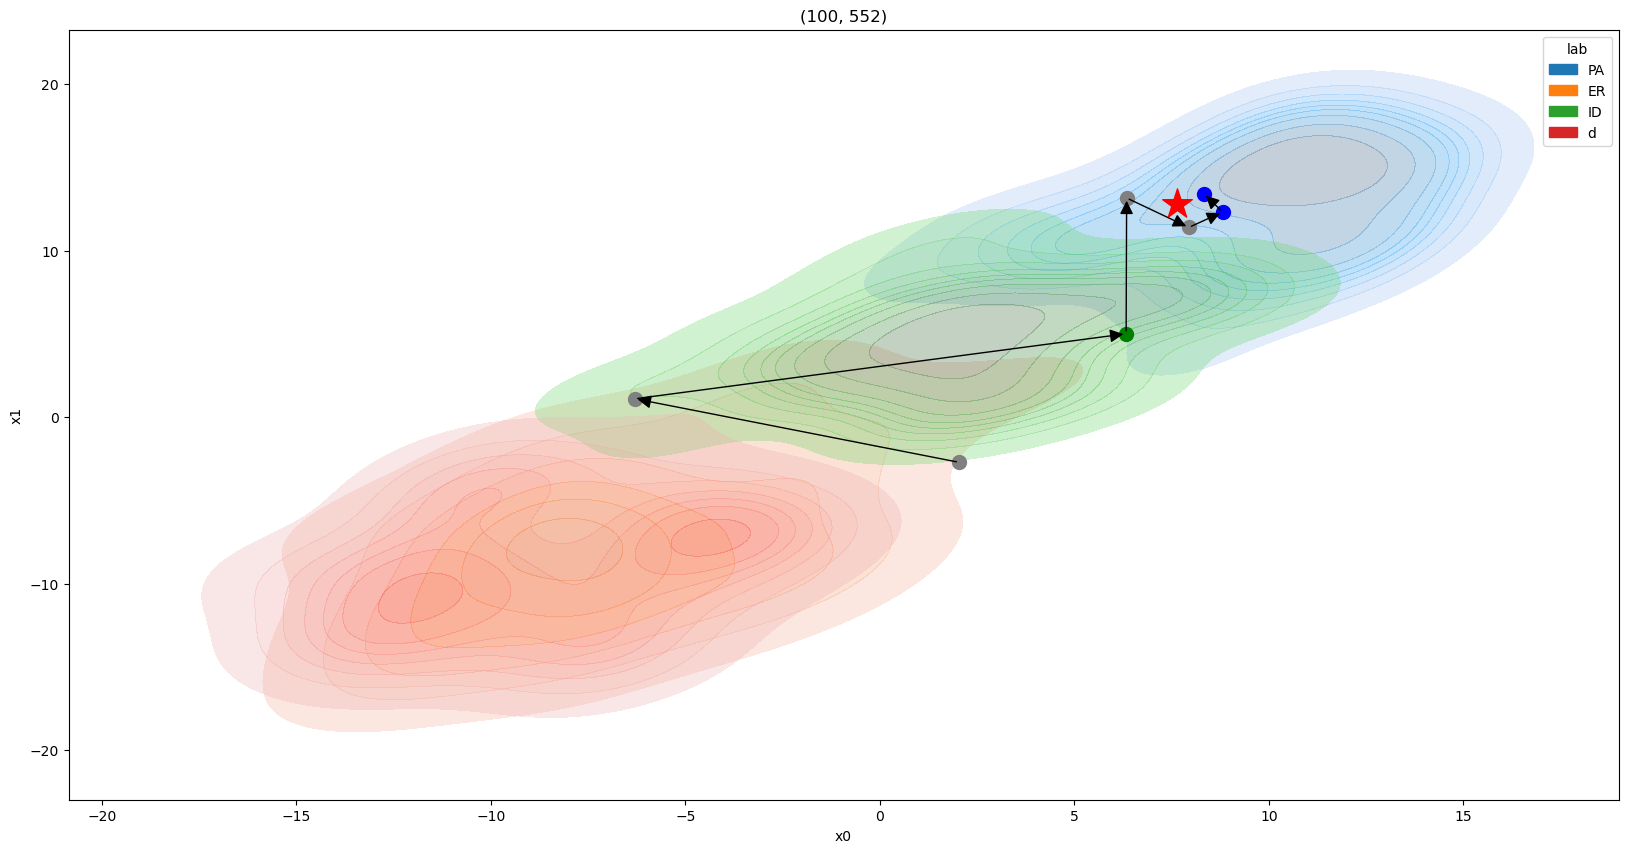

In [13]:
test_n = 100
test_m = 552

test_n1, test_m1 = test_n, test_m

test_ve_dict1 = netana.ve_dicts[(test_n1, test_m1)].copy()

if len(test_ve_dict1["embs"][0]) > 2:
    n_graphs = len(test_ve_dict1["embs"])
    
    embs = np.array(list(test_ve_dict1["embs"])+list(evonets_embs))
    
    reducer = TSNE()
    reduced_embs = reducer.fit_transform(embs)
    
    test_ve_dict1["embs"] = reduced_embs[:n_graphs]
    
    evonet_fitted = reduced_embs[n_graphs]
    evonet_evo = reduced_embs[n_graphs+1:]
    
                   
fig, ax = plt.subplots(nrows=1, ncols=1
                       , figsize=(20,10)
                       , sharex=True, sharey=True
                      )

visualise_kde(
    ve_dict= test_ve_dict1,
    ax = ax,
    title = (test_n, test_m),
    legend=True,
    alpha=0.3,
)

ax.scatter(
    evonet_fitted[0],
    evonet_fitted[1],
    c='red',
    marker="*",
    s=500
)


for i, evo_emb in enumerate(evonet_evo):
    
    ax.scatter(
        evo_emb[0],
        evo_emb[1],
        s=100,
        c=colorfromprog(evonets_paths[1:][i])
        #c='blue',
    )
    
    if i>0:
        ax.annotate(
            '' #'{}'.format(i)
            , xy=(evo_emb[0],evo_emb[1])
            , xytext=(evonet_evo[i-1][0],evonet_evo[i-1][1])
            , arrowprops=dict( color="k"
                              #, lw=3
                              , arrowstyle = '-|>'
                              , mutation_scale=20
                             )
        )
    
    """else:
        plt.annotate('' #'{}'.format(i)
                     , xy=(row['emb_x'],row['emb_y'])
                     , xytext=(df_retained.iloc[i-1]['emb_x'],df_retained.iloc[i-1]['emb_y'])
                     , arrowprops=dict( color="grey"
                                       #, width=1
                                       #, headwidth=3
                                       , arrowstyle = '->'
                                      )
                    )"""


ax.set_title('({}, {})'.format(test_n1, test_m1))

In [14]:
FITTED_NET = 'space_seg/data/data_v2/v100_e552/d/d_1.pickle'
REPO_SAVED_ALL = "data/repro_save_d/GraphMAE_vGCN_o64/d_1.0/"

evonets_paths = [
    f for f in listdir(REPO_SAVED_ALL)
    if f.endswith('.gml') and '_gen' in f
]
evonets_paths = sorted(evonets_paths, key=lambda x: int(x.split('_gen')[0].split('bestnet')[1]), reverse=False)

print("- "+"\n- ".join(evonets_paths))

evonets_paths = [FITTED_NET] + [REPO_SAVED_ALL+n for n in evonets_paths]

evonets = [load_net(net, directed=False)
           for net in evonets_paths]

evonets_embs = [netemb.embedder(n) for n in evonets]

- bestnet0_gen3.gml
- bestnet1_gen5.gml
- bestnet2_gen13.gml
- bestnet3_gen20.gml
- bestnet4_gen26.gml
- bestnet5_gen58.gml
- bestnet6_gen224.gml
- bestnet7_gen769.gml
- bestnet8_gen905.gml


/Users/nmm/miniforge3/envs/env_gdl/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/nmm/miniforge3/envs/env_gdl/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Text(0.5, 1.0, '(100, 552)')

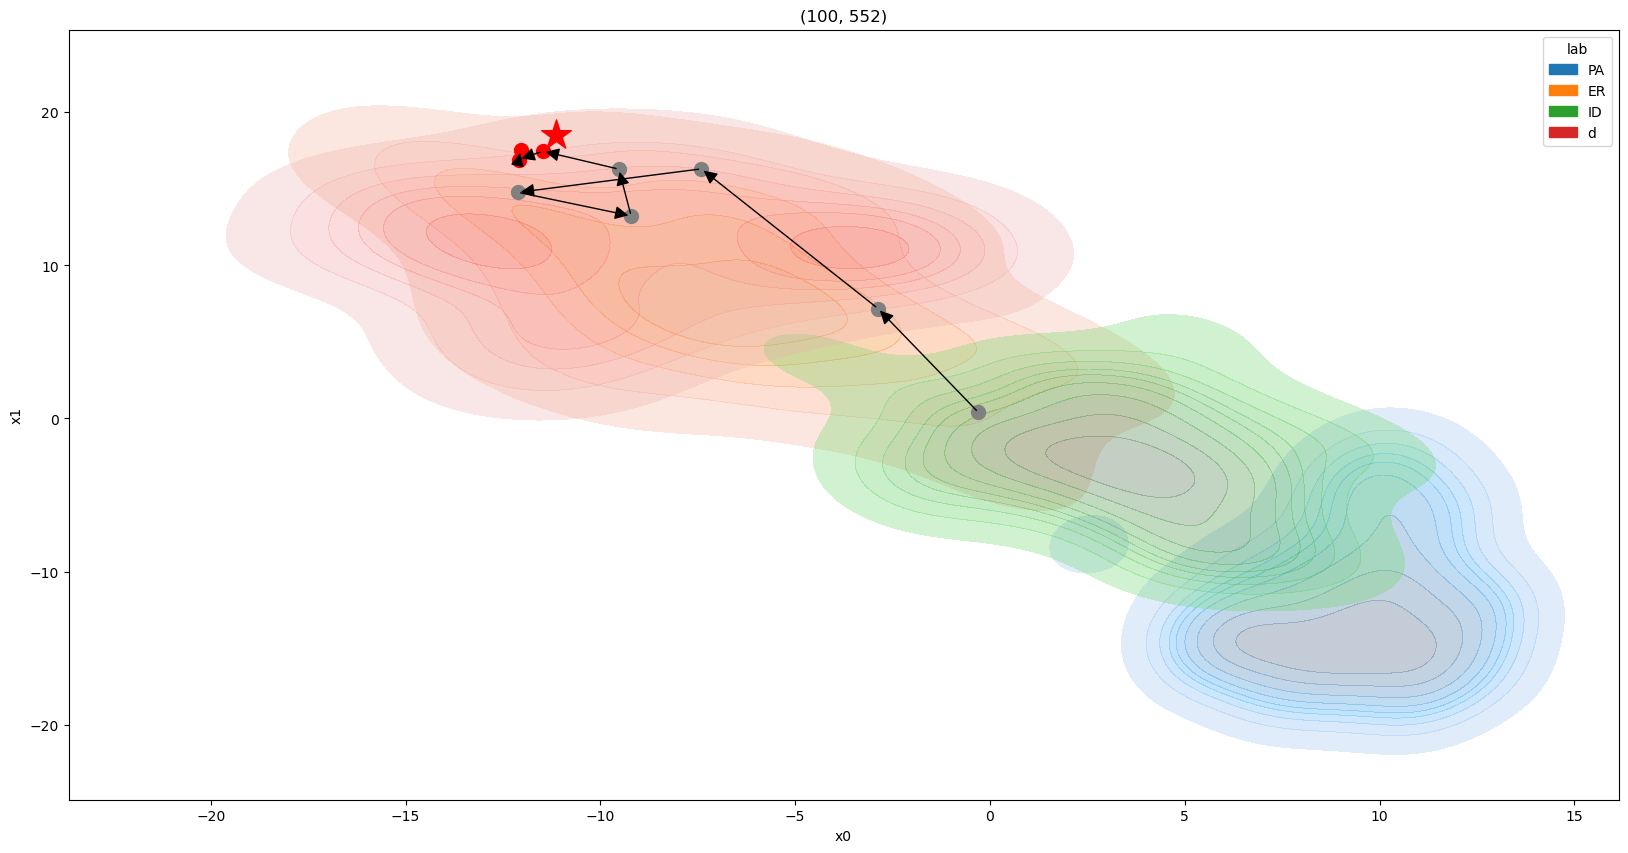

In [15]:
test_n = 100
test_m = 552

test_n1, test_m1 = test_n, test_m

test_ve_dict1 = netana.ve_dicts[(test_n1, test_m1)].copy()

if len(test_ve_dict1["embs"][0]) > 2:
    n_graphs = len(test_ve_dict1["embs"])
    
    embs = np.array(list(test_ve_dict1["embs"])+list(evonets_embs))
    
    reducer = TSNE()
    reduced_embs = reducer.fit_transform(embs)
    
    test_ve_dict1["embs"] = reduced_embs[:n_graphs]
    
    evonet_fitted = reduced_embs[n_graphs]
    evonet_evo = reduced_embs[n_graphs+1:]
    
                   
fig, ax = plt.subplots(nrows=1, ncols=1
                       , figsize=(20,10)
                       , sharex=True, sharey=True
                      )

visualise_kde(
    ve_dict= test_ve_dict1,
    ax = ax,
    title = (test_n, test_m),
    legend=True,
    alpha=0.3,
)

ax.scatter(
    evonet_fitted[0],
    evonet_fitted[1],
    c='red',
    marker="*",
    s=500
)


for i, evo_emb in enumerate(evonet_evo):
    
    ax.scatter(
        evo_emb[0],
        evo_emb[1],
        s=100,
        c=colorfromprog(evonets_paths[1:][i])
        #c='blue',
    )
    
    if i>0:
        ax.annotate(
            '' #'{}'.format(i)
            , xy=(evo_emb[0],evo_emb[1])
            , xytext=(evonet_evo[i-1][0],evonet_evo[i-1][1])
            , arrowprops=dict( color="k"
                              #, lw=3
                              , arrowstyle = '-|>'
                              , mutation_scale=20
                             )
        )
    
    """else:
        plt.annotate('' #'{}'.format(i)
                     , xy=(row['emb_x'],row['emb_y'])
                     , xytext=(df_retained.iloc[i-1]['emb_x'],df_retained.iloc[i-1]['emb_y'])
                     , arrowprops=dict( color="grey"
                                       #, width=1
                                       #, headwidth=3
                                       , arrowstyle = '->'
                                      )
                    )"""


ax.set_title('({}, {})'.format(test_n1, test_m1))

In [16]:
FITTED_NET = 'space_seg/data/data_v2/v100_e552/PA/k_1.pickle'
REPO_SAVED_ALL = "data/repro_save_k/trad2014/k_1.0/"

In [17]:
evonets_paths = [f for f in listdir(REPO_SAVED_ALL)
           if f.endswith('.gml') and '_gen' in f
          ]
evonets_paths = sorted(evonets_paths, key=lambda x: int(x.split('_gen')[0].split('bestnet')[1]), reverse=False)

print("- "+"\n- ".join(evonets_paths))

evonets_paths = [FITTED_NET] + [REPO_SAVED_ALL+n for n in evonets_paths]

evonets = [load_net(net, directed=False)
           for net in evonets_paths]

- bestnet0_gen4.gml
- bestnet0_gen1.gml
- bestnet1_gen6.gml
- bestnet1_gen4.gml
- bestnet2_gen6.gml
- bestnet3_gen8.gml
- bestnet4_gen16.gml
- bestnet5_gen56.gml
- bestnet6_gen80.gml
- bestnet7_gen152.gml
- bestnet8_gen196.gml
- bestnet9_gen266.gml
- bestnet10_gen650.gml
- bestnet11_gen883.gml
- bestnet12_gen958.gml
- bestnet13_gen1351.gml


In [18]:
evonets_embs = [netemb.embedder(n) for n in evonets]

/Users/nmm/miniforge3/envs/env_gdl/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/nmm/miniforge3/envs/env_gdl/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Text(0.5, 1.0, '(100, 552)')

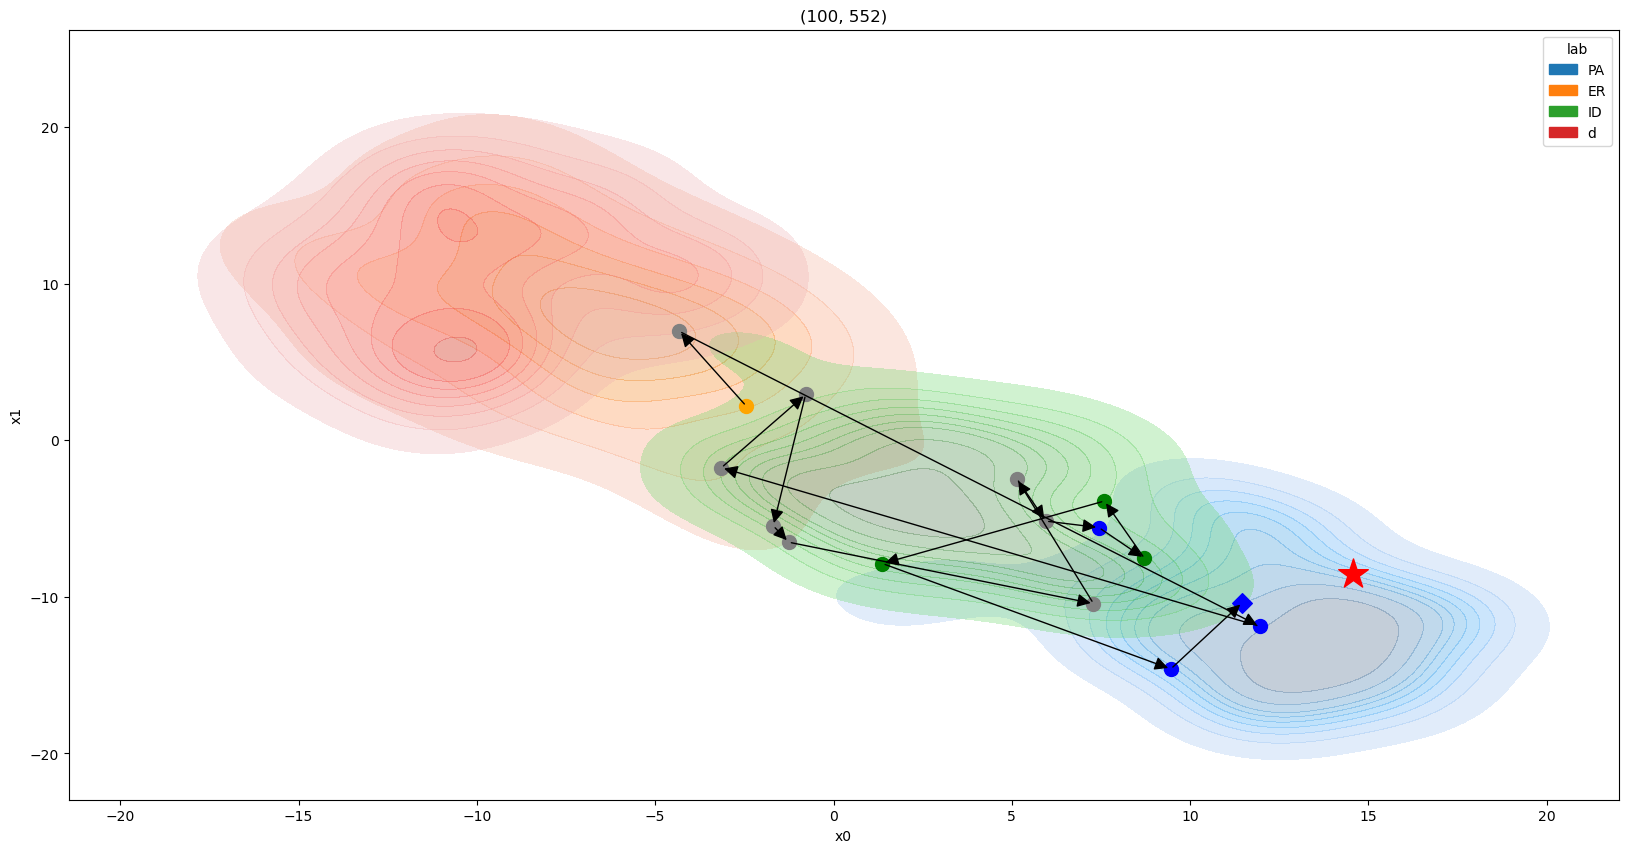

In [19]:
test_n = 100
test_m = 552

test_n1, test_m1 = test_n, test_m

test_ve_dict1 = netana.ve_dicts[(test_n1, test_m1)].copy()

if len(test_ve_dict1["embs"][0]) > 2:
    n_graphs = len(test_ve_dict1["embs"])
    
    embs = np.array(list(test_ve_dict1["embs"])+list(evonets_embs))
    
    reducer = TSNE()
    reduced_embs = reducer.fit_transform(embs)
    
    test_ve_dict1["embs"] = reduced_embs[:n_graphs]
    
    evonet_fitted = reduced_embs[n_graphs]
    evonet_evo = reduced_embs[n_graphs+1:]
    
                   
fig, ax = plt.subplots(nrows=1, ncols=1
                       , figsize=(20,10)
                       , sharex=True, sharey=True
                      )

visualise_kde(
    ve_dict= test_ve_dict1,
    ax = ax,
    title = (test_n, test_m),
    legend=True,
    alpha=0.3,
)

ax.scatter(
    evonet_fitted[0],
    evonet_fitted[1],
    c='red',
    marker="*",
    s=500
)


for i, evo_emb in enumerate(evonet_evo):
    
    ax.scatter(
        evo_emb[0],
        evo_emb[1],
        s=100,
        c = colorfromprog(evonets_paths[1:][i]),
        marker = 'o' if i<len(evonet_evo)-1 else 'D'
        #c='green' if i==0 else 'red' if i==len(evonet_evo)-1 else 'blue',
    )
    
    if i>0:
        ax.annotate(
            '' #'{}'.format(i)
            , xy=(evo_emb[0],evo_emb[1])
            , xytext=(evonet_evo[i-1][0],evonet_evo[i-1][1])
            , arrowprops=dict( color="k"
                              #, lw=3
                              , arrowstyle = '-|>'
                              , mutation_scale=20
                             )
        )


ax.set_title('({}, {})'.format(test_n1, test_m1))

In [20]:
FITTED_NET = 'space_seg/data/data_v2/v100_e552/ER/c1_3.pickle'
REPO_SAVED_ALL = "data/repro_save_c/trad2014/c1_3.0/"

In [21]:
evonets_paths = [f for f in listdir(REPO_SAVED_ALL)
           if f.endswith('.gml') and '_gen' in f
          ]
evonets_paths = sorted(evonets_paths, key=lambda x: int(x.split('_gen')[0].split('bestnet')[1]), reverse=False)

print("- "+"\n- ".join(evonets_paths))

evonets_paths = [FITTED_NET] + [REPO_SAVED_ALL+n for n in evonets_paths]

evonets = [load_net(net, directed=False)
           for net in evonets_paths]

evonets_embs = [netemb.embedder(n) for n in evonets]

- bestnet0_gen1.gml
- bestnet1_gen2.gml
- bestnet2_gen5.gml
- bestnet3_gen11.gml
- bestnet4_gen48.gml
- bestnet5_gen67.gml
- bestnet6_gen514.gml
- bestnet7_gen780.gml


/Users/nmm/miniforge3/envs/env_gdl/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/nmm/miniforge3/envs/env_gdl/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Text(0.5, 1.0, '(100, 552)')

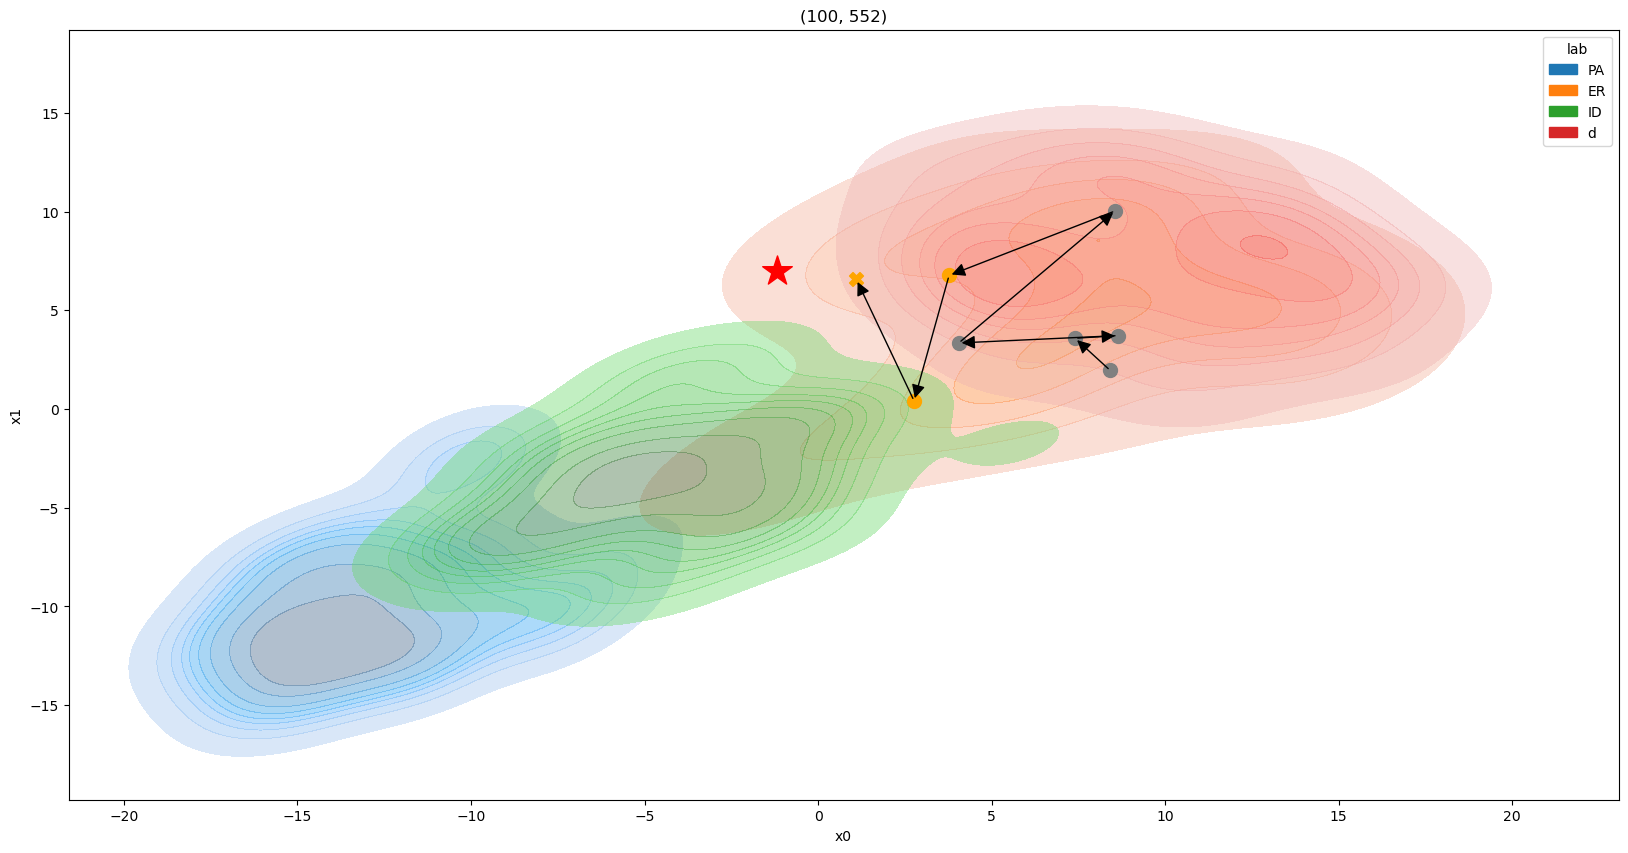

In [22]:
test_n = 100
test_m = 552

test_n1, test_m1 = test_n, test_m

test_ve_dict1 = netana.ve_dicts[(test_n1, test_m1)].copy()

if len(test_ve_dict1["embs"][0]) > 2:
    n_graphs = len(test_ve_dict1["embs"])
    
    embs = np.array(list(test_ve_dict1["embs"])+list(evonets_embs))
    
    reducer = TSNE()
    reduced_embs = reducer.fit_transform(embs)
    
    test_ve_dict1["embs"] = reduced_embs[:n_graphs]
    
    evonet_fitted = reduced_embs[n_graphs]
    evonet_evo = reduced_embs[n_graphs+1:]
    
                   
fig, ax = plt.subplots(nrows=1, ncols=1
                       , figsize=(20,10)
                       , sharex=True, sharey=True
                      )

visualise_kde(
    ve_dict= test_ve_dict1,
    ax = ax,
    title = (test_n, test_m),
    legend=True,
    alpha=0.4,
)

ax.scatter(
    evonet_fitted[0],
    evonet_fitted[1],
    c='red',
    marker="*",
    s=500
)


for i, evo_emb in enumerate(evonet_evo):
    
    ax.scatter(
        evo_emb[0],
        evo_emb[1],
        s=100,
        c = colorfromprog(evonets_paths[1:][i]),
        marker = 'o' if i<len(evonet_evo)-1 else 'X'
        #c='green' if i==0 else 'red' if i==len(evonet_evo)-1 else 'blue',
    )
    
    if i>0:
        ax.annotate(
            '' #'{}'.format(i)
            , xy=(evo_emb[0],evo_emb[1])
            , xytext=(evonet_evo[i-1][0],evonet_evo[i-1][1])
            , arrowprops=dict( color="k"
                              #, lw=3
                              , arrowstyle = '-|>'
                              , mutation_scale=20
                             )
        )


ax.set_title('({}, {})'.format(test_n1, test_m1))

## 📏 Evaluating with trad metrics

In [4]:
from synthetic.consts import (DEFAULT_GENERATIONS, DEFAULT_SAMPLE_RATE,
                              DEFAULT_BINS, DEFAULT_MAX_DIST,
                              DEFAULT_TOLERANCE, DEFAULT_GEN_TYPE,
                              DEFAULT_NORM_SAMPLES, 
                              DEFAULT_NODES, DEFAULT_EDGES, DEFAULT_RUNS
                             )
from synthetic.distances import DistancesToNet, Norm

from synthetic.commands.command import Command, arg_with_default, get_stat_dist_types

from reproducibility.loss_analysis import *

In [200]:
fam = "PA"
net_name = "k_2"
run_id = "0"

best_fit_test = 'data/repro_trad/{}/{}.{}/bestnet.gml'.format(fam, net_name, run_id)
best_fit_trad = 'data/repro_tests_PGCL_default/{}/{}.{}/bestnet.gml'.format(fam, net_name, run_id)

obs = 'space_seg/data/data_v2/v100_e552/PA/{}.pickle'.format(net_name)

In [201]:
# 0. parameters
directed = False

evo_args = {
    "bins":DEFAULT_BINS,
    "undir":True,
    "maxdist":DEFAULT_MAX_DIST,
    "rw":True,
}

In [202]:
# 1. loading nets
best_trad = load_net(best_fit_trad, directed=directed)
best_test = load_net(best_fit_test, directed=directed)

obs_net = load_net(obs, directed=directed)

In [203]:
# 2. Instantiate distance metric
dists2net = DistancesToNet(
    obs_net
    , get_stat_dist_types(evo_args)
    , bins=evo_args["bins"], max_dist=evo_args["maxdist"]
    , rw=evo_args["rw"]
    , norm=Norm.ER_MEAN_RATIO
    , norm_samples=DEFAULT_NORM_SAMPLES
)

  0% (1 of 1000) |                       | Elapsed Time: 0:00:00 ETA:   0:03:08

computing normalization samples...


100% (1000 of 1000) |####################| Elapsed Time: 0:03:10 Time:  0:03:10


190.139s


In [204]:
max_stat_len = 22

print(" TRADITIONAL METHOD ")
for stat, dist in zip(dists2net.stat_dist_types, dists2net.compute(best_trad)):
    print("\t{s}{ws}: {d}".format(
        s=stat[0],
        d=dist,
        ws=" "*(max_stat_len-len(str(stat[0])))
    ))

 TRADITIONAL METHOD 
	StatType.DEGREES      : 0.2570496764079449
	StatType.U_PAGERANKS  : 0.2849506180578908
	StatType.TRIAD_CENSUS : 0.13381401927689798
	StatType.U_DISTS      : 0.1174029953464708


In [205]:
max_stat_len = 22

print(" DEEP METHOD ")
for stat, dist in zip(dists2net.stat_dist_types, dists2net.compute(best_test)):
    print("\t{s}{ws}: {d}".format(
        s=stat[0],
        d=dist,
        ws=" "*(max_stat_len-len(str(stat[0])))
    ))

 DEEP METHOD 
	StatType.DEGREES      : 0.19457232450323605
	StatType.U_PAGERANKS  : 0.20516444500168138
	StatType.TRIAD_CENSUS : 0.06740464409099475
	StatType.U_DISTS      : 0.27749227270462495


In [215]:
df = pd.DataFrame(columns=['DEGREES', 'U_PAGERANKS', 'TRIAD_CENSUS', 'U_DISTS'])
df.loc[0] = [0, 0, 0, 0]
df.loc["trad"] = dists2net.compute(best_trad)
df.loc["test"] = dists2net.compute(best_test)

df

DEGREES  U_PAGERANKS  TRIAD_CENSUS   U_DISTS
0     0.000000     0.000000      0.000000  0.000000
trad  0.257050     0.284951      0.133814  0.194204
test  0.194572     0.205164      0.067405  0.153195

In [216]:
evo_ana = EvoAnalysis(
    path_to_evo_csv = df
    , evo_key = "DEGREES"
    , evo_key_size = None
)

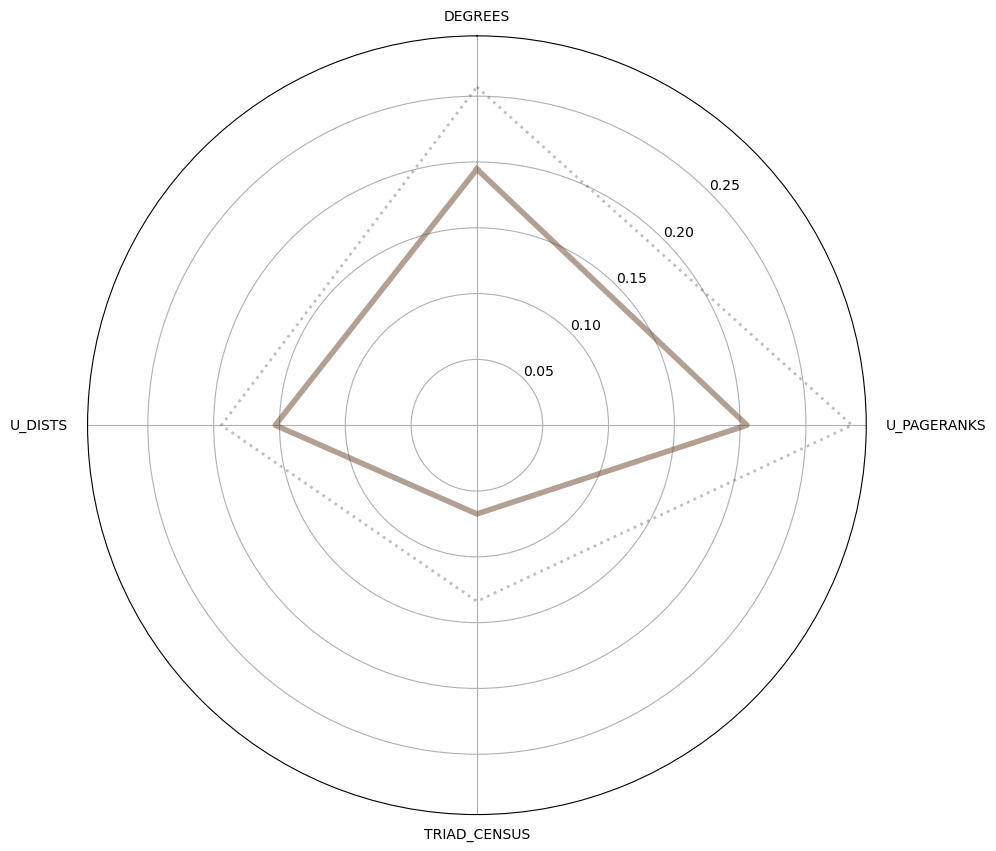

In [217]:
evo_ana.run_analysis(
    do_radar_plot = True
    , do_ls_plot = False
)

### variability of `U_DISTS` ?

In [218]:
from tqdm import tqdm

In [219]:
u_dists = []
for _ in tqdm(range(1000)):
    u_dists += [dists2net.compute(best_trad)[-1]]

100%|███████████████████████████████████████| 1000/1000 [03:10<00:00,  5.25it/s]


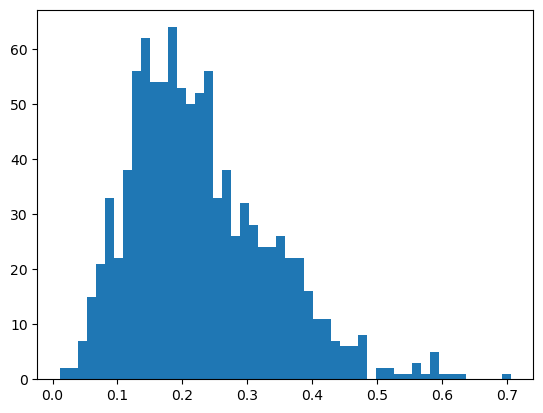

In [221]:
plt.hist(u_dists, bins=50)
plt.show()

# 🔀 Cross-comparison

In [235]:
from synthetic.consts import (DEFAULT_GENERATIONS, DEFAULT_SAMPLE_RATE,
                              DEFAULT_BINS, DEFAULT_MAX_DIST,
                              DEFAULT_TOLERANCE, DEFAULT_GEN_TYPE,
                              DEFAULT_NORM_SAMPLES, 
                              DEFAULT_NODES, DEFAULT_EDGES, DEFAULT_RUNS
                             )
from synthetic.distances import DistancesToNet, Norm

from synthetic.commands.command import Command, arg_with_default, get_stat_dist_types

from reproducibility.loss_analysis import *

## Radar visualisation

In [278]:
fam = "d"
net_name = "d_2"
run_id = "0"

obs = 'space_seg/data/data_v2/v100_e552/{}/{}.pickle'.format(fam, net_name)

# 0. parameters
directed = False

evo_args = {
    "bins":DEFAULT_BINS,
    "undir":True,
    "maxdist":DEFAULT_MAX_DIST,
    "rw":True,
}

# 1. loading net
obs_net = load_net(obs, directed=directed)

# 2. Instantiate distance metric
dists2net = DistancesToNet(
    obs_net
    , get_stat_dist_types(evo_args)
    , bins=evo_args["bins"], max_dist=evo_args["maxdist"]
    , rw=evo_args["rw"]
    , norm=Norm.ER_MEAN_RATIO
    , norm_samples=DEFAULT_NORM_SAMPLES
)

  0% (1 of 1000) |                       | Elapsed Time: 0:00:00 ETA:   0:03:13

computing normalization samples...


100% (1000 of 1000) |####################| Elapsed Time: 0:03:08 Time:  0:03:08


188.934s


In [279]:
networks_paths = [
    'data/repro_trad/{}/{}.{}/bestnet.gml'.format(fam, net_name, run_id),
    'data/repro_degs/{}/{}.{}/bestnet.gml'.format(fam, net_name, run_id),
    'data/repro_graphmae/{}/{}.{}/bestnet.gml'.format(fam, net_name, run_id),
    'data/repro_pgcl/{}/{}.{}/bestnet.gml'.format(fam, net_name, run_id)
]

labels = [p.split("/")[1] for p in networks_paths]

networks_compare = [load_net(p, directed=directed) for p in networks_paths]

In [305]:
def radar_from_dists(distances:list
                     , ax
                     , labels:list=None
                     , ticks_labels:list=None
                    ):
    
    # Number of variables we're plotting.
    num_vars = len(distances[0])

    # Split the circle into even parts and save the angles
    # so we know where to put each axis.
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    
    # The plot is a circle, so we need to "complete the loop"
    # and append the start value to the end.
    angles += angles[:1]
    
    for i, dists in enumerate(distances):
        values = dists + dists[:1]
        
        
        ax.plot(angles, values
                , label = None if labels is None else labels[i]
               )
        
    # Fill it in.
    #ax.fill(angles, values, color='red', alpha=0.25)

    # Fix axis to go in the right order and start at 12 o'clock.
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    # Draw axis lines for each angle and label.
    if not ticks_labels is None:
        #ax.set_thetagrids(np.degrees(angles[:-1]), [stat[0] for stat in ref_dist2net.stat_dist_types])
        ax.set_thetagrids(np.degrees(angles[:-1]), ticks_labels)


    # Go through labels and adjust alignment based on where
    # it is in the circle.
    for label, angle in zip(ax.get_xticklabels(), angles):
        if angle in (0, np.pi):
            label.set_horizontalalignment('center')
        elif 0 < angle < np.pi:
            label.set_horizontalalignment('left')
        else:
            label.set_horizontalalignment('right')

    # Set position of y-labels (0-100) to be in the middle
    # of the first two axes.
    ax.set_rlabel_position(180 / num_vars)
    
    return ax

In [296]:
def cross_comparison(
    ref_dist2net, # ref_dist2net.compute(net)
    ax,
    networks:list,
    labels:list=None,
):
    if not labels is None:
        assert(len(labels) == len(networks))
        
    distances = [ref_dist2net.compute(net) for net in networks]
    
    plt.legend()
        
    return ax

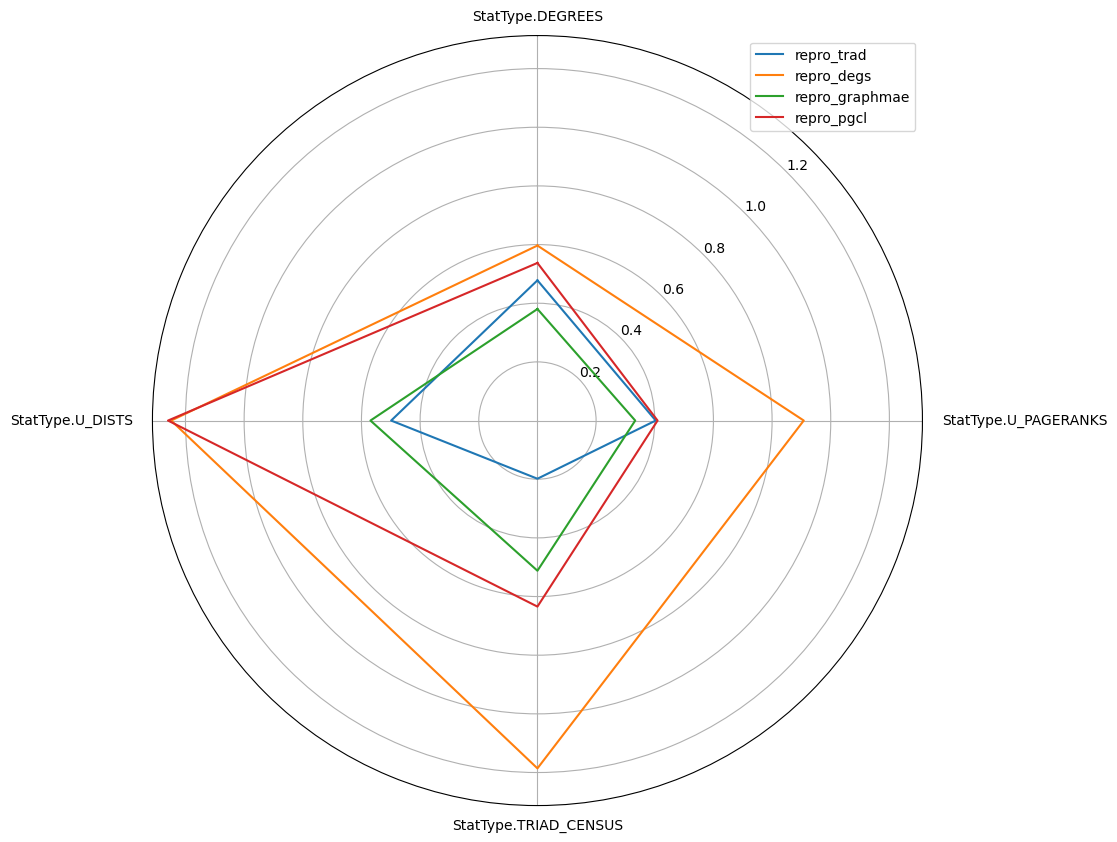

In [281]:
# d - d_2.0

fig = plt.figure(figsize=(10,10))
ax_radar = fig.add_subplot(projection='polar')

cross_comparison(
    ref_dist2net = dists2net,
    ax = ax_radar,
    networks = networks_compare,
    labels=labels
)
    

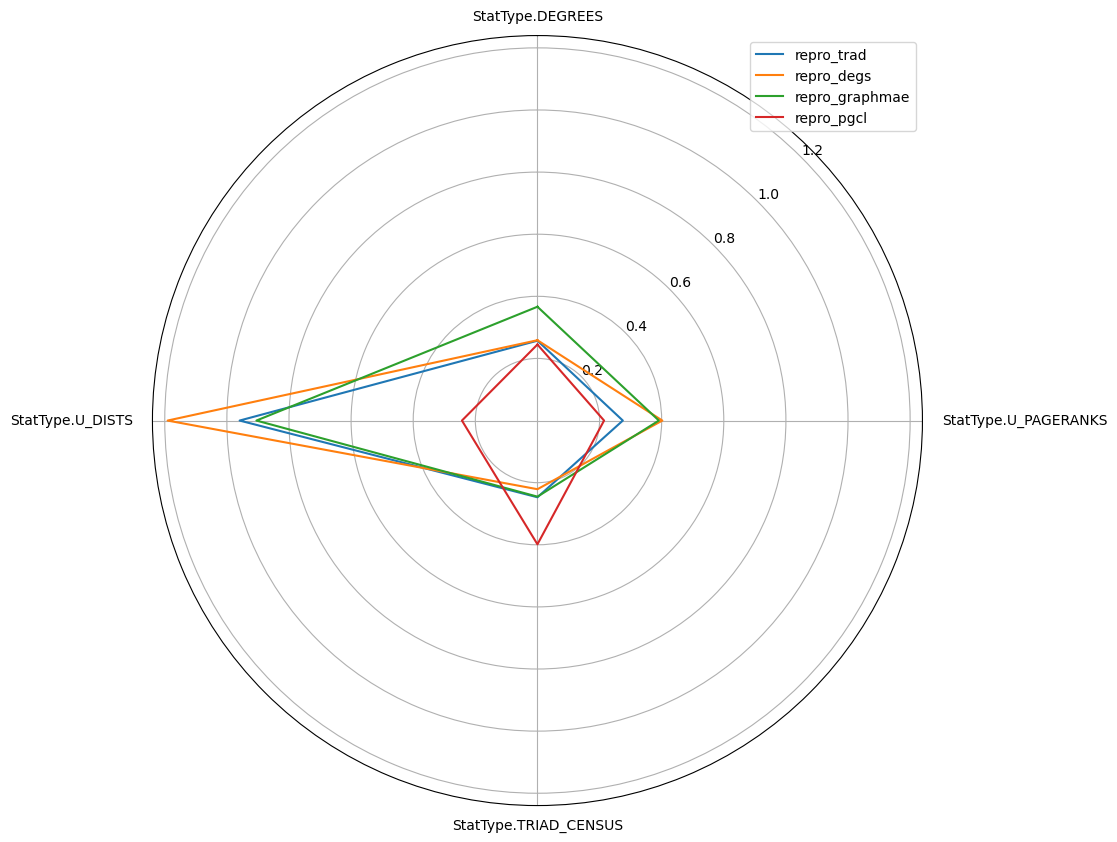

In [276]:
# PA - k_1.0

fig = plt.figure(figsize=(10,10))
ax_radar = fig.add_subplot(projection='polar')

cross_comparison(
    ref_dist2net = dists2net,
    ax = ax_radar,
    networks = networks_compare,
    labels=labels
)
    

## Systematic evaluation

In [308]:
# 0. parameters
directed = False

evo_args = {
    "bins":DEFAULT_BINS,
    "undir":True,
    "maxdist":DEFAULT_MAX_DIST,
    "rw":True,
}

fam_nets_dict = {
    "PA": ["k_1", "k_2", "k_3"],
    "ID": ["id_1", "id_2", "id_3"],
    "d": ["d_1", "d_2", "d_3"],
    #"ER": ["c1_1", "c1_2", "c1_3"]
}

In [309]:
results = {}

for fam, net_names in fam_nets_dict.items():
    results[fam] = {}
    for net_name in net_names:
        # 1. instantiate reference distance
        obs = 'space_seg/data/data_v2/v100_e552/{}/{}.pickle'.format(fam, net_name)

        # 1. loading net
        obs_net = load_net(obs, directed=directed)

        # 2. Instantiate distance metric
        dists2net = DistancesToNet(
            obs_net
            , get_stat_dist_types(evo_args)
            , bins=evo_args["bins"], max_dist=evo_args["maxdist"]
            , rw=evo_args["rw"]
            , norm=Norm.ER_MEAN_RATIO
            , norm_samples=DEFAULT_NORM_SAMPLES
        )
        
        results[fam][net_name] = {}
        
        # --> for each run in 
        for run_id in range(10):
            # 3. load nets to be compared
            networks_paths = [
                'data/repro_trad/{}/{}.{}/bestnet.gml'.format(fam, net_name, run_id),
                'data/repro_degs/{}/{}.{}/bestnet.gml'.format(fam, net_name, run_id),
                'data/repro_graphmae/{}/{}.{}/bestnet.gml'.format(fam, net_name, run_id),
                'data/repro_pgcl/{}/{}.{}/bestnet.gml'.format(fam, net_name, run_id)
            ]

            models_names = [p.split("/")[1] for p in networks_paths]

            networks = [load_net(p, directed=directed) for p in networks_paths]
            
            distances = [dists2net.compute(net) for net in networks]
            
            results[fam][net_name][run_id] = {}
            for i, m in enumerate(models_names):
                results[fam][net_name][run_id][m] = distances[i]

  0% (1 of 1000) |                       | Elapsed Time: 0:00:00 ETA:   0:03:11

computing normalization samples...


100% (1000 of 1000) |####################| Elapsed Time: 0:03:06 Time:  0:03:06


186.825s


  0% (1 of 1000) |                       | Elapsed Time: 0:00:00 ETA:   0:03:05

computing normalization samples...


100% (1000 of 1000) |####################| Elapsed Time: 0:03:06 Time:  0:03:06


187.001s


  0% (1 of 1000) |                       | Elapsed Time: 0:00:00 ETA:   0:03:07

computing normalization samples...


100% (1000 of 1000) |####################| Elapsed Time: 0:03:07 Time:  0:03:07


187.365s


  0% (1 of 1000) |                       | Elapsed Time: 0:00:00 ETA:   0:03:05

computing normalization samples...


100% (1000 of 1000) |####################| Elapsed Time: 0:03:11 Time:  0:03:11


191.755s


  0% (1 of 1000) |                       | Elapsed Time: 0:00:00 ETA:   0:03:11

computing normalization samples...


100% (1000 of 1000) |####################| Elapsed Time: 0:03:11 Time:  0:03:11


191.989s


  0% (1 of 1000) |                       | Elapsed Time: 0:00:00 ETA:   0:03:16

computing normalization samples...


100% (1000 of 1000) |####################| Elapsed Time: 0:03:10 Time:  0:03:10


190.437s


  0% (1 of 1000) |                       | Elapsed Time: 0:00:00 ETA:   0:03:17

computing normalization samples...


100% (1000 of 1000) |####################| Elapsed Time: 0:03:10 Time:  0:03:10


190.193s


  0% (1 of 1000) |                       | Elapsed Time: 0:00:00 ETA:   0:03:12

computing normalization samples...


100% (1000 of 1000) |####################| Elapsed Time: 0:03:11 Time:  0:03:11


191.376s


  0% (1 of 1000) |                       | Elapsed Time: 0:00:00 ETA:   0:03:10

computing normalization samples...


100% (1000 of 1000) |####################| Elapsed Time: 0:03:12 Time:  0:03:12


192.046s


In [310]:
num_vars = 4 # number of metrics computed in distance
av_results = {}

for fam in results.keys():
    av_results[fam] = {}
    for net_name in results[fam].keys():
        av_results[fam][net_name] = {}
        for m in models_names:
            av_results[fam][net_name][m] = [
                np.mean([results[fam][net_name][r_id][m][i] for r_id in range(10)]) for i in range(num_vars)
            ]

In [311]:
dists2net.stat_dist_types

((<StatType.DEGREES: 0>, <DistanceType.EARTH_MOVER: 1>),
 (<StatType.U_PAGERANKS: 3>, <DistanceType.EARTH_MOVER: 1>),
 (<StatType.TRIAD_CENSUS: 5>, <DistanceType.NORMALIZED_MANHATTAN: 0>),
 (<StatType.U_DISTS: 6>, <DistanceType.NORMALIZED_MANHATTAN: 0>))

PA
	k_1


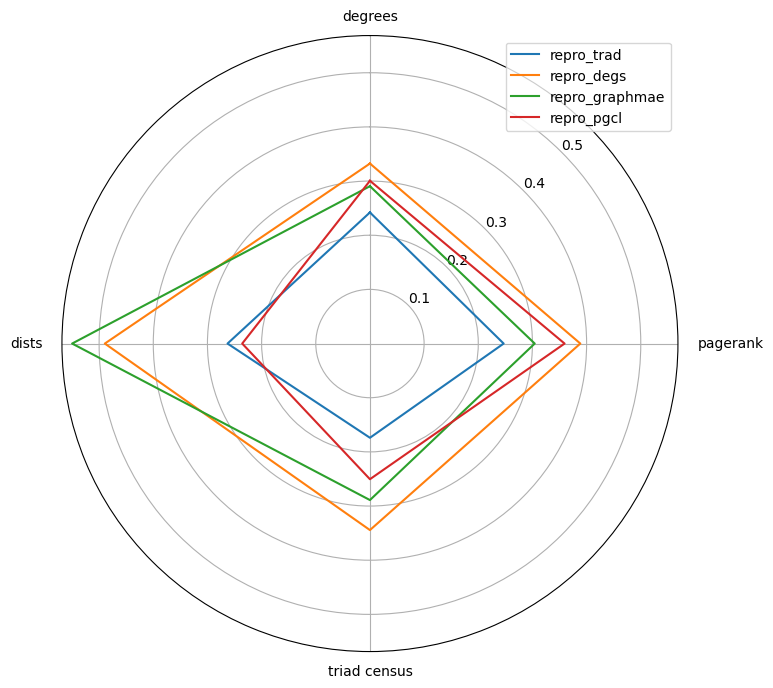

	k_2


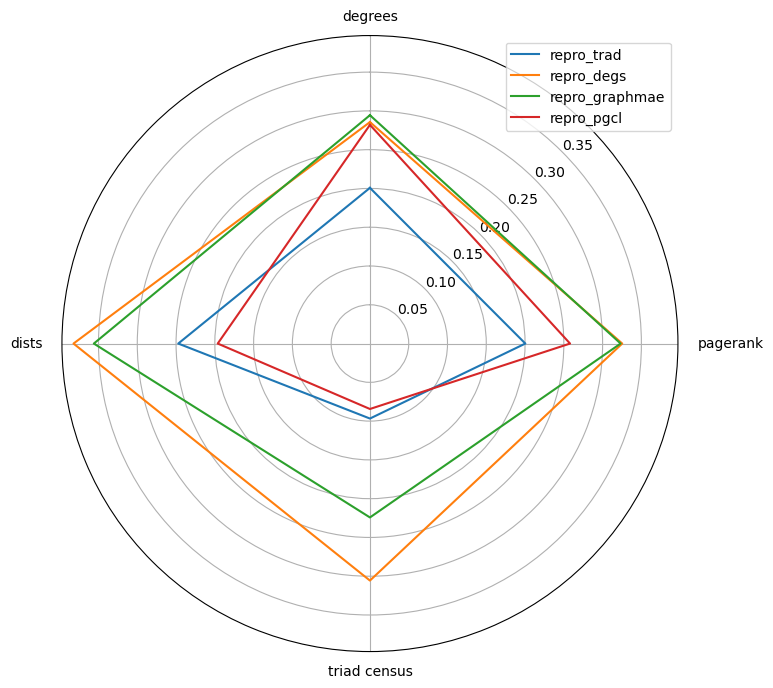

	k_3


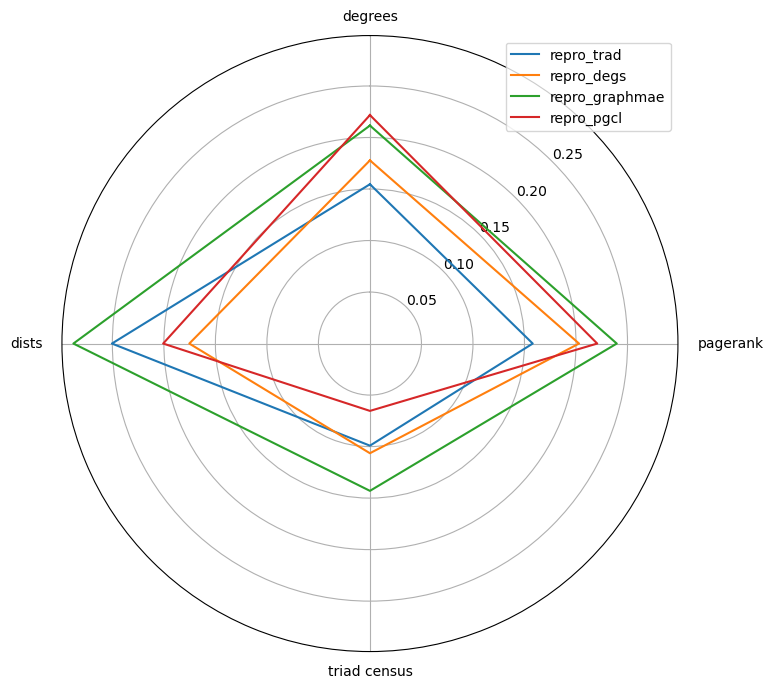

ID
	id_1


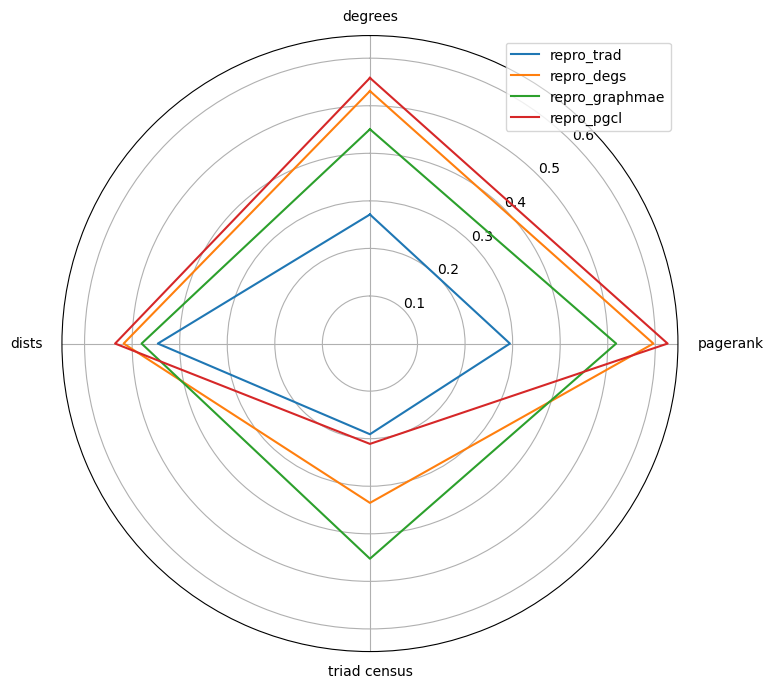

	id_2


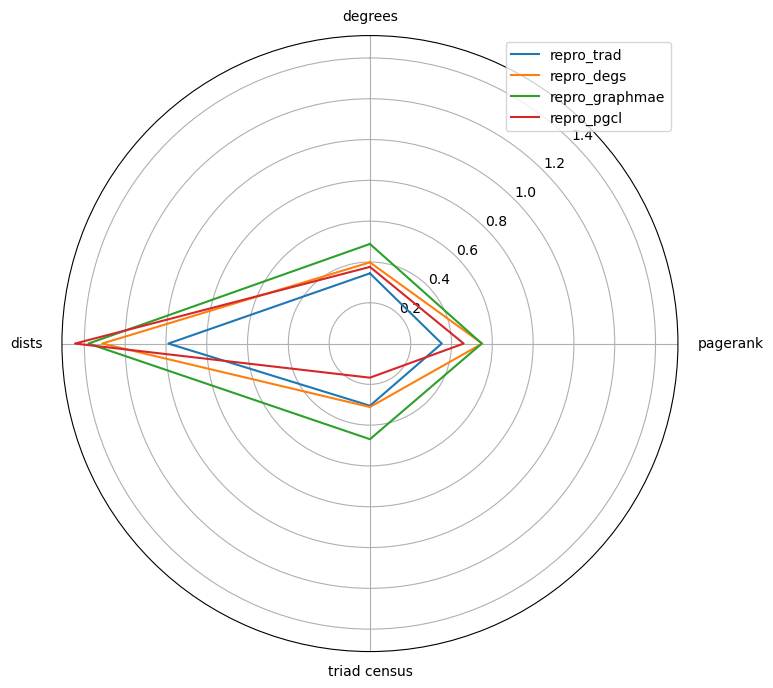

	id_3


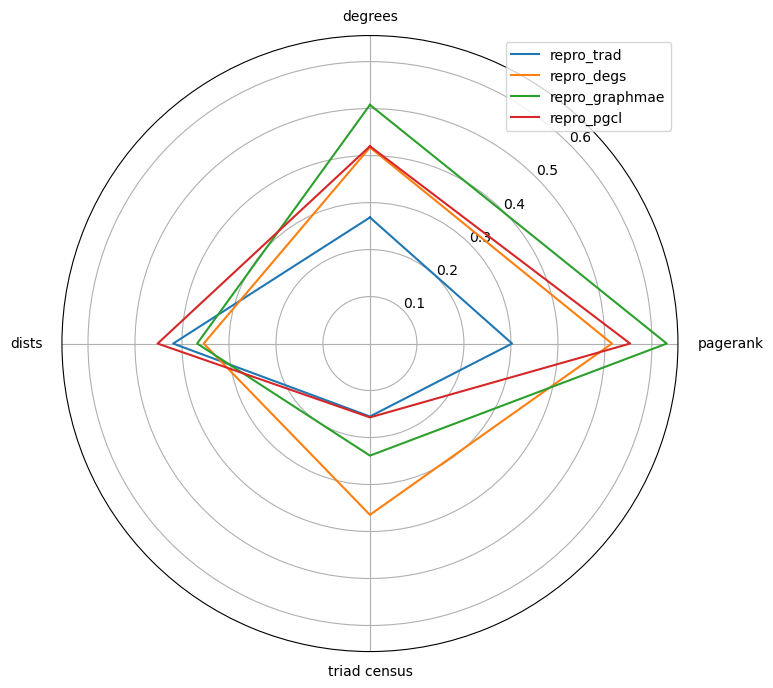

d
	d_1


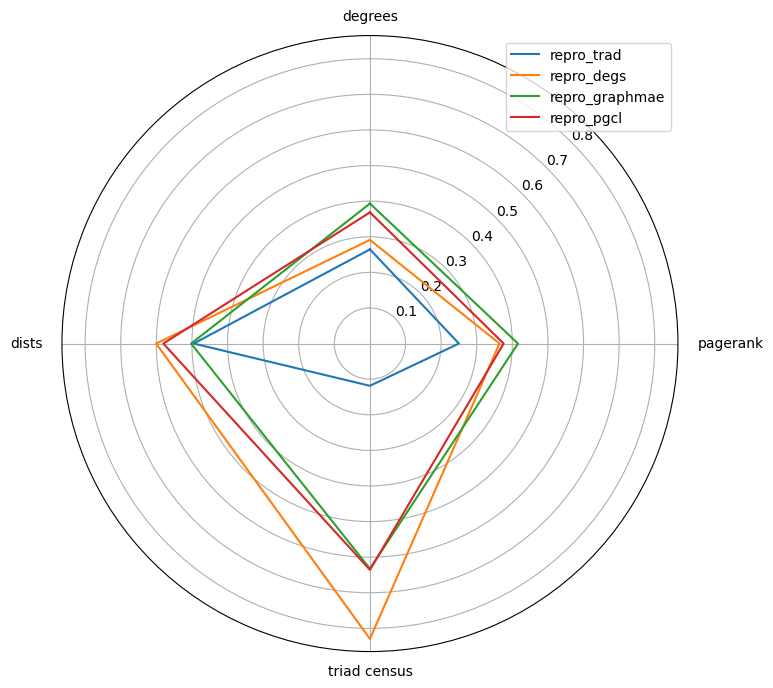

	d_2


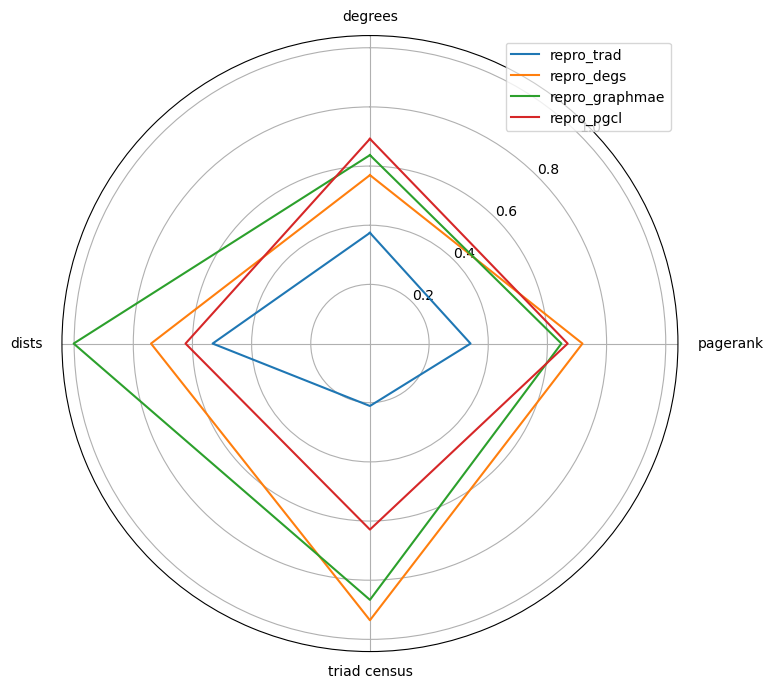

	d_3


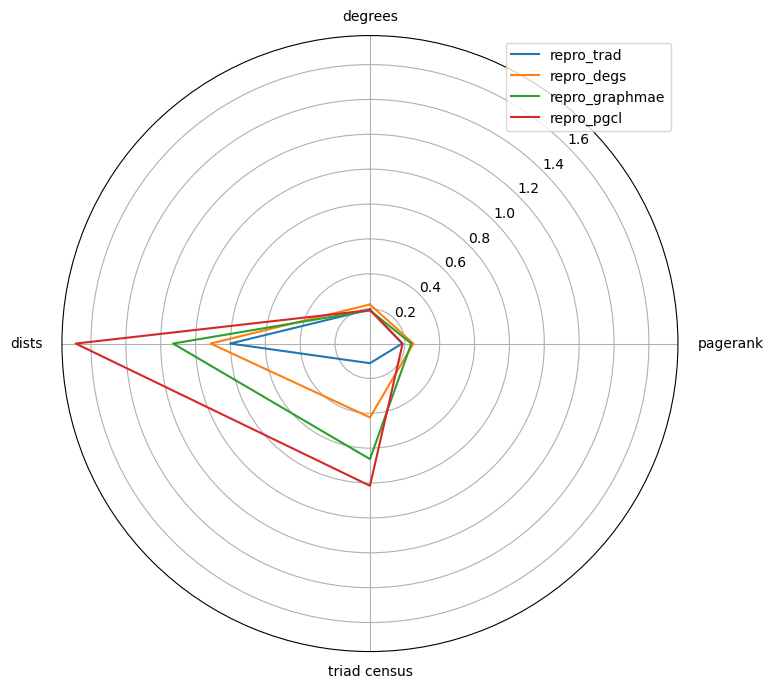

In [312]:
for fam in av_results.keys():
    print("{}".format(fam))
    
    for net_name in av_results[fam].keys():
        print("\t{}".format(net_name))

        fig = plt.figure(figsize=(8,8))
        ax_radar = fig.add_subplot(projection='polar')
        
        models_names =list(av_results[fam][net_name].keys())

        av_distances = [
            av_results[fam][net_name][m]
            for m in models_names
        ]
        
        radar_from_dists(distances=av_distances
                         , ax=ax_radar
                         , labels=models_names
                         , ticks_labels=["degrees", "pagerank", "triad census", "dists"]
                        )
        plt.legend()
        plt.show()

# 🛠 Average training improvement

$$ \mathrm{\%\ rel\ improvement} = \frac{b_i - u_i}{u_i}\times 100 $$

With : 
- $b_i$ mean of best scores for data $i$
- $u_i$ mean of untrained scores for data $i$

In [1]:
import pandas as pd

In [30]:
PATH_RES = "DL_module/saved/repro/models/GraphMAE/"
untrained_name = "untrained_results.csv"
best_name = "best_results.csv"

In [31]:
means_untrained = pd.read_csv(PATH_RES+untrained_name, index_col=0).mean(axis=1)
means_best = pd.read_csv(PATH_RES+best_name, index_col=0).mean(axis=1)

In [33]:
((means_best-means_untrained)*100)#.mean()

REDDIT-BINARY                             2.470000
COLLAB                                    0.920000
IMDB-BINARY                               0.280000
IMDB-MULTI                               -0.040000
PROTEINS                                  0.324324
DD                                       -0.407359
../data/data_gnns/graphs_catalogue.csv    0.790268
dtype: float64

## Quick fitted generators quality assessment

In [2]:
from os import listdir
from synthetic.generator import load_generator

### ER

In [212]:
family = "ER"
net_name = "c1"

def solution_assessment(prog_str:str):
    """ Returns True is string is a number. """
    try:
        float(prog_str)
        return True
    except ValueError:
        return False

#### - trad2014

In [700]:
experiments_name = "repro_trad"

path_to_assess = "data/{}/{}/".format(experiments_name, family)

####

path_to_load = [
    path_to_assess+"{netname}_{netid}.{expid}".format(netname=net_name,netid=i+1,expid=j)+'/bestprog.txt'
    for i in range(3) for j in range(10) 
]

found_generators = [
    load_generator(path, directed=False, gen_type='exo')
    for path in path_to_load
]

#valid_generators = [
#    np.any([str(gen.prog)== s for s in solutions])
#    for gen in found_generators
#]

valid_generators = [
    solution_assessment(str(gen.prog))
    for gen in found_generators
]

print('(min) accuracy : {} '.format(np.sum(valid_generators)/len(valid_generators)))

for i in range(3):
    print("\t",np.sum(valid_generators[i*10:(i+1)*10])/10)
    print(">"+"\n>".join([str(gen.prog)+" ✅"
                          if solution_assessment(str(gen.prog))
                          else 'complex  ...' if gen.prog.size() > 10
                          else str(gen.prog)
                          for gen in found_generators[i*10:(i+1)*10]
                         ]))

(min) accuracy : 0.4 
	 0.3
>complex  ...
>(LOG 0.7254004589442619)
>complex  ...
>7.0 ✅
>3.0 ✅
>0.18326506820476995 ✅
>(EXP 
 (< 0.012219709343304408 0.0 0.502138542048856 8.0))
>$dist
>(^ 3.0 0.9734456817733799)
>complex  ...
	 0.3
>(* 0.7251608183840453 
 (LOG 0.1692368490686189))
>(^ 
 (+ 0.6011338531357928 0.038151250384159785) 
 (MIN 0.8280599020084767 $targ))
>complex  ...
>0.8962930889334381 ✅
>(LOG 
 (+ 0.16093498504357862 8.0))
>complex  ...
>0.6126441789261022 ✅
>0.8328499487745058 ✅
>complex  ...
>complex  ...
	 0.6
>0.956639917127919 ✅
>1.0 ✅
>complex  ...
>(+ 0.9934875765027612 0.0)
>2.0 ✅
>complex  ...
>0.017875896133014213 ✅
>0.29919014120805465 ✅
>7.0 ✅
>(< 
 (LOG 0.9648487056951133) $orig 0.16677634653232143 0.5033042732195364)


#### - deep

In [665]:
experiments_name = "repro_tests_GraphMAE_GCN64"

path_to_assess = "data/{}/{}/".format(experiments_name, family)

####

path_to_load = [
    path_to_assess+"{netname}_{netid}.{expid}".format(netname=net_name,netid=i+1,expid=j)+'/bestprog.txt'
    for i in range(3) for j in range(10) 
]

found_generators = [
    load_generator(path, directed=False, gen_type='exo')
    for path in path_to_load
]

#valid_generators = [
#    np.any([str(gen.prog)== s for s in solutions])
#    for gen in found_generators
#]

valid_generators = [
    solution_assessment(str(gen.prog))
    for gen in found_generators
]

print('(min) accuracy : {} '.format(np.sum(valid_generators)/len(valid_generators)))

for i in range(3):
    print("\t",np.sum(valid_generators[i*10:(i+1)*10])/10)
    print(">"+"\n>".join([str(gen.prog)+" ✅"
                          if solution_assessment(str(gen.prog))
                          else 'complex  ...' if gen.prog.size() > 10
                          else str(gen.prog)
                          for gen in found_generators[i*10:(i+1)*10]
                         ]))

(min) accuracy : 0.3 
	 0.2
>(+ 9.0 
 (/ $targ 
  (== $targ_deg 0.0 $orig $orig)))
>(- 
 (ZER 0.6985031576607793 0.7481529470232298 4.0) 
 (ZER $orig_deg $orig 6.0))
>(- 
 (> 0.0 $dist $orig $targ) 
 (ABS $targ))
>complex  ...
>(AFF 0.871481982051174 6.0 
 (/ 8.0 
  (ZER 2.0 0.0 0.6249308440640977)))
>complex  ...
>(MIN 3.0 
 (LOG $targ))
>complex  ...
>0.0 ✅
>0.7025513035057309 ✅
	 0.4
>0.2442343776894309 ✅
>complex  ...
>complex  ...
>$dist
>5.0 ✅
>(+ 
 (> 9.0 3.0 7.0 $dist) 
 (- $targ 0.0))
>0.6458435237663114 ✅
>0.0 ✅
>(ABS 0.571732409841597)
>(^ 0.0 1.0)
	 0.3
>(LOG $orig)
>complex  ...
>$dist
>(ABS 0.0)
>(< 0.2622921056280241 $targ 0.3763939901312947 $targ_deg)
>(ABS 0.5146957282669586)
>3.0 ✅
>complex  ...
>9.0 ✅
>2.0 ✅


#### - pgcl

In [224]:
experiments_name = "repro_tests_PGCL_default"

path_to_assess = "data/{}/{}/".format(experiments_name, family)

####

path_to_load = [
    path_to_assess+"{netname}_{netid}.{expid}".format(netname=net_name,netid=i+1,expid=j)+'/bestprog.txt'
    for i in range(3) for j in range(10) 
]

found_generators = [
    load_generator(path, directed=False, gen_type='exo')
    for path in path_to_load
]

#valid_generators = [
#    np.any([str(gen.prog)== s for s in solutions])
#    for gen in found_generators
#]

valid_generators = [
    solution_assessment(str(gen.prog))
    for gen in found_generators
]

print('(min) accuracy : {} '.format(np.sum(valid_generators)/len(valid_generators)))

for i in range(3):
    print("\t",np.sum(valid_generators[i*10:(i+1)*10])/10)
    print(">"+"\n>".join([str(gen.prog)+" ✅"
                          if solution_assessment(str(gen.prog))
                          else 'complex  ...' if gen.prog.size() > 10
                          else str(gen.prog)
                          for gen in found_generators[i*10:(i+1)*10]
                         ]))

(min) accuracy : 0.2 
	 0.2
>(/ 0.0 
 (MAX 0.9590173458241308 0.1756142450419027))
>(* 0.0 1.0)
>complex  ...
>(ABS 0.0)
>(ZER 2.0 
 (^ 0.35693376672069954 $orig_deg) 0.6249308440640977)
>complex  ...
>(* 
 (ABS 3.0) 0.22673238477773405)
>0.8232805865447131 ✅
>0.10134619141575096 ✅
>complex  ...
	 0.1
>(== $dist 0.7400824175622324 0.689952561222824 0.4176866742043024)
>9.0 ✅
>complex  ...
>(LOG $orig)
>complex  ...
>(LOG 
 (< $orig 
  (^ $orig $targ_deg) 0.897528718981448 0.6254367282132188))
>(LOG 
 (MIN 
  (== 7.0 0.0 $dist $orig_deg) 
  (LOG 0.11770152527743716)))
>complex  ...
>complex  ...
>(/ 0.6104076192041548 
 (ABS 
  (== 0.7920242394902075 6.0 0.631279600522077 0.0)))
	 0.3
>0.6561087391662421 ✅
>0.0 ✅
>(ABS 0.9665338349373265)
>6.0 ✅
>(- 8.0 2.0)
>complex  ...
>complex  ...
>complex  ...
>(ZER 
 (EXP 
  (== 0.23799790214192507 $orig 0.6326573111539228 0.5684577813080842)) $orig 0.9736999758262541)
>(LOG 
 (- 
  (EXP 0.9831872607146026) 
  (MIN $dist $dist)))


#### trad_degs

In [710]:
experiments_name = "repro_trad_degs"

path_to_assess = "data/{}/{}/".format(experiments_name, family)

####

path_to_load = [
    path_to_assess+"{netname}_{netid}.{expid}".format(netname=net_name,netid=i+1,expid=j)+'/bestprog.txt'
    for i in range(3) for j in range(10) 
]

found_generators = [
    load_generator(path, directed=False, gen_type='exo')
    for path in path_to_load
]

#valid_generators = [
#    np.any([str(gen.prog)== s for s in solutions])
#    for gen in found_generators
#]

valid_generators = [
    solution_assessment(str(gen.prog))
    for gen in found_generators
]

print('(min) accuracy : {} '.format(np.sum(valid_generators)/len(valid_generators)))

for i in range(3):
    print("\t",np.sum(valid_generators[i*10:(i+1)*10])/10)
    print(">"+"\n>".join([str(gen.prog)+" ✅"
                          if solution_assessment(str(gen.prog))
                          else 'complex  ...' if gen.prog.size() > 10
                          else str(gen.prog)
                          for gen in found_generators[i*10:(i+1)*10]
                         ]))

(min) accuracy : 0.5666666666666667 
	 0.5
>0.08958408026233688 ✅
>(LOG 
 (MIN $orig_deg 0.5088738219734134))
>0.7883722764552863 ✅
>0.5852673471472217 ✅
>complex  ...
>(ZER 0.11515007407037459 4.0 6.0)
>(+ 
 (MAX 8.0 $orig_deg) 
 (AFF 0.11213782695381525 0.6359465318087344 7.0))
>0.8152588324064589 ✅
>complex  ...
>0.29246402405488214 ✅
	 0.6
>0.9754928563657478 ✅
>(LOG $orig)
>6.0 ✅
>0.12065249963578495 ✅
>(LOG $targ)
>complex  ...
>5.0 ✅
>0.19062817534843135 ✅
>0.020594576568816025 ✅
>complex  ...
	 0.6
>3.0 ✅
>complex  ...
>9.0 ✅
>complex  ...
>0.931523426129297 ✅
>(- 0.0 8.0)
>4.0 ✅
>(EXP $dist)
>0.0 ✅
>0.06580973315915961 ✅


### `ID` - GraphMAE

In [231]:
import numpy as np

family = "ID"
net_name = "id"

solutions = ["$orig", "$targ"]

def solution_assessment(prog_str:str
                        , solutions = solutions
                       ):

    return np.any([str(prog_str)==s for s in solutions])

In [232]:
experiments_name = "repro_GraphMAE"

path_to_assess = "data/{}/{}/".format(experiments_name, family)

####

path_to_load = [
    path_to_assess+"{netname}_{netid}.{expid}".format(netname=net_name,netid=i+1,expid=j)+'/bestprog.txt'
    for i in range(3) for j in range(10) 
]

found_generators = [
    load_generator(path, directed=False, gen_type='exo')
    for path in path_to_load
]

#valid_generators = [
#    np.any([str(gen.prog)== s for s in solutions])
#    for gen in found_generators
#]

valid_generators = [
    solution_assessment(str(gen.prog))
    for gen in found_generators
]

print('(min) accuracy : {} '.format(np.sum(valid_generators)/len(valid_generators)))

for i in range(3):
    print("\t",np.sum(valid_generators[i*10:(i+1)*10])/10)
    print(">"+"\n>".join([str(gen.prog)+" ✅"
                          if solution_assessment(str(gen.prog))
                          else 'complex  ...' if gen.prog.size() > 10
                          else str(gen.prog)
                          for gen in found_generators[i*10:(i+1)*10]
                         ]))

(min) accuracy : 0.43333333333333335 
	 0.3
>$targ ✅
>(+ 
 (- $targ 2.0) 
 (+ 2.0 $orig_deg))
>$targ ✅
>complex  ...
>(MAX $orig 
 (^ 3.0 0.0))
>(< 0.5023308904011059 0.10763275075944112 $dist $targ)
>complex  ...
>complex  ...
>$targ ✅
>complex  ...
	 0.4
>complex  ...
>complex  ...
>$orig ✅
>$orig ✅
>complex  ...
>(MAX 
 (EXP 0.3449229848671994) 
 (== $orig $targ 0.2198939606185467 $orig))
>$orig ✅
>$targ ✅
>(ABS 
 (^ $targ_deg 0.7432885622729473))
>(ZER 
 (- $orig $orig_deg) $orig $targ)
	 0.6
>(LOG 
 (LOG $orig))
>$orig ✅
>$targ ✅
>$targ ✅
>$targ ✅
>$orig ✅
>(^ 
 (EXP $targ_deg) 
 (+ $targ $targ_deg))
>complex  ...
>complex  ...
>$targ ✅


In [233]:
#1) O  X  O  X  O  O  X. X. O. X
#.    i+k
#2) X. X. O. O. X  O. O. O. X  O
#.                         k^a
#3) X  O. O  O. O. O. X. X. X. O
#.loglog
17/30

0.5666666666666667

### Best generators

In [30]:
family = "ER"

#experiments_name = "repro_trad"
#experiments_name = "repro_tests_GraphMAE_GCN64"
#experiments_name = "repro_trad_degs"
#

experiments_name = "repro_pgcl"
#experiments_name = "repro_graphmae"
#experiments_name = "repro_degs"

path_to_assess = "data/{}/{}/".format(experiments_name, family)

####
best_runs = retrieve_best_runs(
    results_dir=path_to_assess,
    n_exps=10,
    experiments_names=None,
    csv_loss_name="evo.csv",
    loss_col = "best_fit",
    optim="min",
    include_prog=True
)

for k, v in best_runs.items():
    print("========================\n\t{}\nloss: {}\n\n{}\n".format(
        k,
        v["best_fit"],
        v["prog"],
    ))

	c1_2
loss: 0.0013759125722572

(LOG 
 (MIN 
  (== 7.0 0.0 $dist $orig_deg) 
  (LOG 0.11770152527743716)))

	c1_1
loss: 0.0006714091869071

(* 0.0 1.0)

	c1_3
loss: 0.0009271308081224

(< 
 (EXP 
  (== 9.0 $targ 8.0 $orig)) 
 (+ 
  (- $orig 0.0) 
  (== $orig_deg 
   (EXP 
    (* 
     (+ $targ 0.8213998483747524) 
     (> $orig_deg 0.0 $targ_deg 7.0))) $dist 1.0)) 
 (AFF 
  (MAX $targ 0.8393116845075718) 
  (< $orig $dist $orig 0.0) 
  (MIN $orig_deg $dist)) 
 (ZER 
  (== 0.9285628713148448 8.0 
   (* 4.0 0.0) 4.0) 
  (EXP $orig) 
  (AFF 9.0 0.3200750182726667 4.0)))



In [ ]:

  (AFF 9.0 0.3200750182726667 4.0)

In [25]:
0.5436856017265077**8.0 > 0.008760044277748902

False

In [28]:
2/9

0.2222222222222222